## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

### Find correction coefficients

In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import glob
import cv2
from tqdm import tqdm
from moviepy.editor import VideoFileClip

%matplotlib inline

print("Done")

Done


Computer camera calibration coefficients

In [58]:
nx, ny = 9, 6  #chessboard size

imagepoints = []
objectpoints = []

objp = np.zeros((nx * ny, 3), dtype=np.float32)
objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

images = glob.glob("camera_cal/calibration*")

with tqdm(total=len(images), desc="Calibration camera") as pbar:
    for image_path in images:
        img = cv2.imread(image_path)

        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
        if ret == True:
            objectpoints.append(objp)
            imagepoints.append(corners)
        pbar.update(1)
        
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objectpoints, imagepoints, (720, 1280), None, None)

print("Done")

Calibration camera:   0%|          | 0/20 [00:00<?, ?it/s]

Calibration camera:   5%|▌         | 1/20 [00:00<00:09,  2.10it/s]

Calibration camera:  10%|█         | 2/20 [00:01<00:09,  1.89it/s]

Calibration camera:  15%|█▌        | 3/20 [00:01<00:08,  2.05it/s]

Calibration camera:  20%|██        | 4/20 [00:01<00:06,  2.35it/s]

Calibration camera:  35%|███▌      | 7/20 [00:02<00:04,  2.98it/s]

Calibration camera:  40%|████      | 8/20 [00:02<00:04,  2.64it/s]

Calibration camera:  45%|████▌     | 9/20 [00:02<00:03,  2.81it/s]

Calibration camera:  50%|█████     | 10/20 [00:03<00:02,  3.35it/s]

Calibration camera:  55%|█████▌    | 11/20 [00:03<00:02,  3.50it/s]

Calibration camera:  60%|██████    | 12/20 [00:03<00:02,  3.63it/s]

Calibration camera:  65%|██████▌   | 13/20 [00:03<00:01,  3.81it/s]

Calibration camera:  70%|███████   | 14/20 [00:04<00:01,  4.24it/s]

Calibration camera:  75%|███████▌  | 15/20 [00:04<00:01,  4.18it/s]

Calibration camera:  80%|████████  | 16/20 [00:04<00:00,  4.19it/s]

Calibration camera:  85%|████████▌ | 17/20 [00:04<00:00,  3.63it/s]

Calibration camera:  90%|█████████ | 18/20 [00:05<00:00,  2.81it/s]

Calibration camera:  95%|█████████▌| 19/20 [00:05<00:00,  2.90it/s]

Calibration camera: 100%|██████████| 20/20 [00:06<00:00,  3.03it/s]

Done


Result of calibration

Done


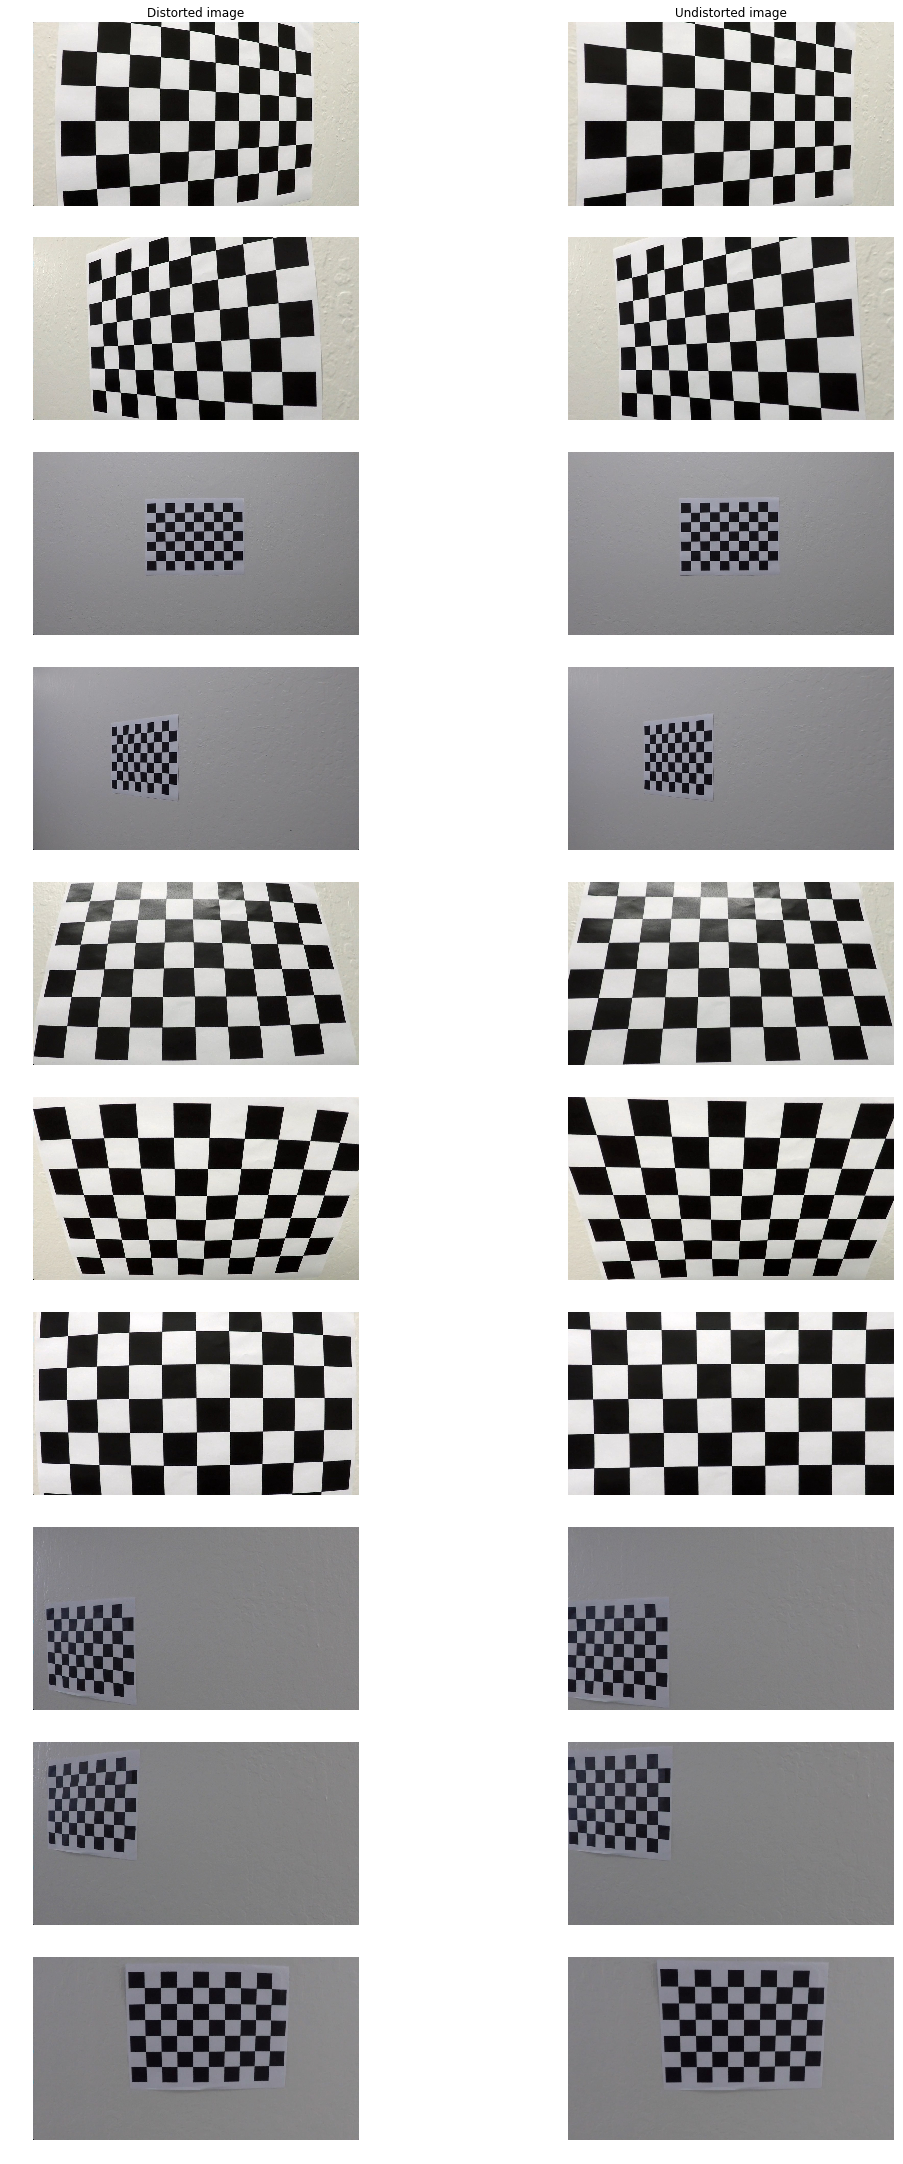

In [61]:
def undist(img):
    return cv2.undistort(img, mtx, dist, None, mtx)


rows = len(images) // 2
columns = 2

fig, ax = plt.subplots(rows, columns)
fig.set_size_inches(15, 30)
fig.tight_layout()

dist_img = mpimg.imread("camera_cal/calibration1.jpg")
undist_img = undist(dist_img)

index = 0

for row in range(rows):
    if row == 0:
        ax[0][0].set_title("Distorted image")
        ax[0][1].set_title("Undistorted image")

    ax[row][0].axis("off")
    ax[row][1].axis("off")
    
    img = mpimg.imread(images[index])
    ax[row][0].imshow(img)
    ax[row][1].imshow(undist(img))
    index += 1

print("Done")


### Example of correction test image

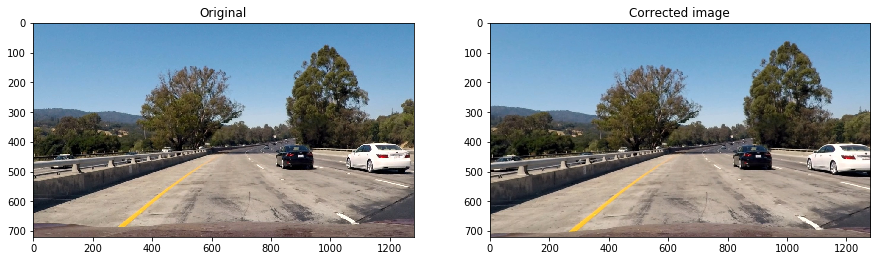

In [62]:
test_img = mpimg.imread("test_images/test1.jpg")
fig, ax = plt.subplots(1, 2)

fig.set_size_inches(15, 30)
ax[0].imshow(test_img)
ax[0].set_title("Original")
ax[1].imshow(undist(test_img))
ax[1].set_title("Corrected image")

##Create threshold binary image. 

There will be used two types of threshold binary image creation and his combination:
- Sobel operator
- Color threshold
- Sobel operator + color threshold

### Sobel operator
There are three methods how apply sobel operator :
- Apply sobel operator in direction horizonal or vertical (x, y)
- Operator Sobel apply in x and y directrion then computes the magnitude of the gradient
- Sobel operator which will be contain angle of line in the picture, will be used arctan

Done


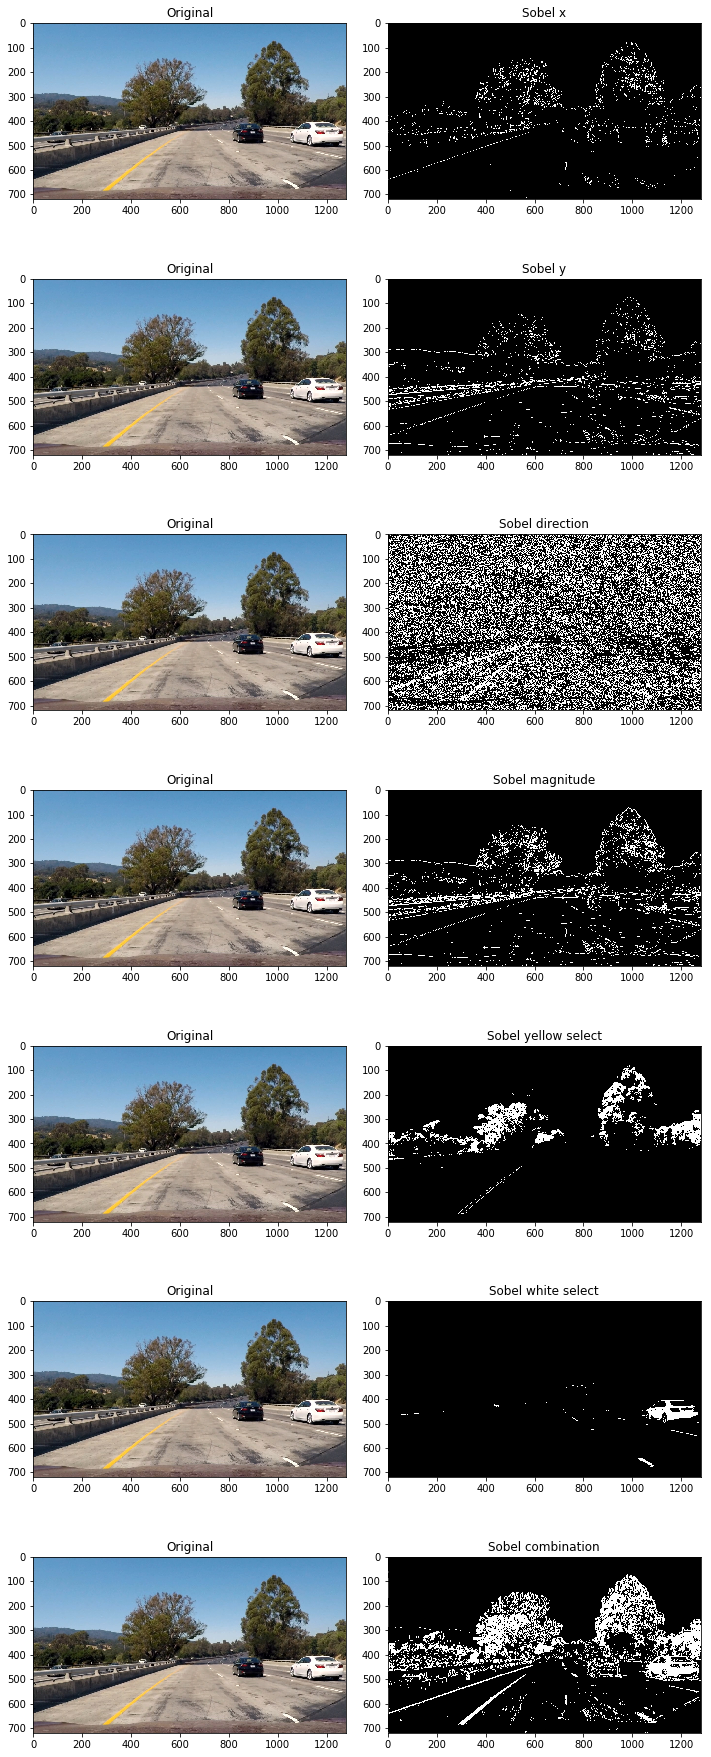

In [92]:
def sobel(img, sobel_kernel=3, orient='x', thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' ororient_x = 0
    orient_y = 0
    if orient == 'x':
        orient_x = 1
        orient_y = 0
    else:
        orient_x = 0
        orient_y = 1

    sobel_img = cv2.Sobel(gray, cv2.CV_64F, orient_x, orient_y, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel_img)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
    # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled)
    sbinary[(scaled > thresh[0]) & (scaled < thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return sbinary


def sobel_mag(img, sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)  #x
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)  #y
    # 3) Calculate the magnitude 
    sobel_res = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled = np.uint8(255 * sobel_res / np.max(sobel_res))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled)
    binary_output[(scaled >= thresh[0]) & (scaled <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    return binary_output


def sobel_dir(img, sobel_kernel=3, thresh=(0, np.pi / 2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    # Return the binary image
    return binary_output

def sobel_hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # 2) Apply a threshold to the S channel
    s = hls[:,:,2]
    binary_output = np.zeros_like(s)
    binary_output[(s >= thresh[0]) & (s <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output


def sobel_comb(img, ksize=3, thresh=(20, 100), thresh_color=(0, 255)):
    sobel_x = sobel(img, orient='x', sobel_kernel=ksize, thresh=thresh)
    sobel_s = sobel_hls_select(img, thresh=thresh_color)
    sobel_wy = comb_thresh(img)
    combined_binary = np.zeros_like(sobel_x)
    combined_binary[(sobel_s == 1) | (sobel_x == 1) | (sobel_wy == 1)] = 1
    return combined_binary


def select_yellow(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    lower = np.array([20,60,60])
    upper = np.array([38,174, 250])
    mask = cv2.inRange(hsv, lower, upper)
    return mask


def select_white(image):
    lower = np.array([202,202,202])
    upper = np.array([255,255,255])
    mask = cv2.inRange(image, lower, upper)
    return mask


def comb_thresh(image):
  yellow = select_yellow(image)
  white = select_white(image)

  combined_binary = np.zeros_like(yellow)
  combined_binary[(yellow >= 1) | (white >= 1)] = 1

  return combined_binary


test_img = mpimg.imread("test_images/test1.jpg")

sobelx_img = sobel(test_img, orient='x', thresh=(30, 100))
sobely_img = sobel(test_img, orient='y', thresh=(30, 100))
sobel_dir_img = sobel_dir(test_img, sobel_kernel=15, thresh=(0.7, 1.3))
sobel_mag_img = sobel_mag(test_img, sobel_kernel=3, thresh=(30, 100))
sobel_yellow_img = select_yellow(test_img)
sobel_white_img = select_white(test_img)
sobel_comb_img = sobel_comb(test_img, ksize=15, thresh=(20, 100), thresh_color=(180, 255))

rows = 7
cols = 2

fig, ax = plt.subplots(rows, cols)

fig.set_size_inches(10, 25)
fig.tight_layout()

for index in range(rows):
    ax[index][0].set_title("Original")
    ax[index][0].imshow(test_img)

ax[0][1].set_title("Sobel x")
ax[0][1].imshow(sobelx_img, cmap='gray')

ax[1][1].set_title("Sobel y")
ax[1][1].imshow(sobely_img, cmap='gray')

ax[2][1].set_title("Sobel direction")
ax[2][1].imshow(sobel_dir_img, cmap='gray')

ax[3][1].set_title("Sobel magnitude")
ax[3][1].imshow(sobel_mag_img, cmap='gray')

ax[4][1].set_title("Sobel yellow select")
ax[4][1].imshow(sobel_yellow_img, cmap='gray')

ax[5][1].set_title("Sobel white select")
ax[5][1].imshow(sobel_white_img, cmap='gray')

ax[6][1].set_title("Sobel combination")
ax[6][1].imshow(sobel_comb_img, cmap='gray')

print("Done")

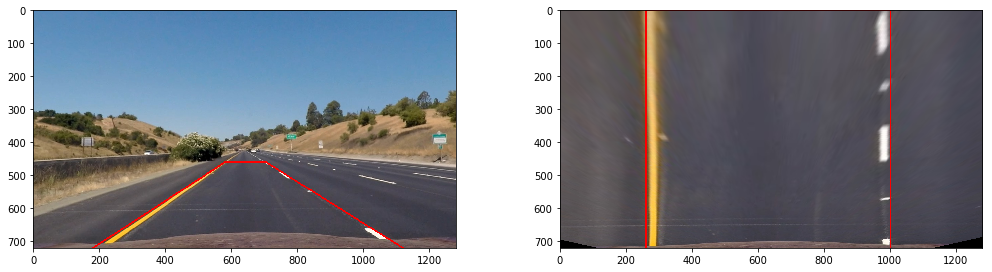

In [65]:
def bird_eye_transform(img, src, dst, width=1280, height=720):
    transform_matrix = cv2.getPerspectiveTransform(src, dst)
    transformed = cv2.warpPerspective(img, transform_matrix, (width, height), flags=cv2.INTER_LINEAR)
    return transformed

src = [[180, 720], [580, 460], [705, 460], [1120, 720]]
dst = [[260, 720], [260, 0], [1000, 0], [1000, 720]]

fig, ax = plt.subplots(1, 2)
fig.tight_layout()
fig.set_size_inches(15, 10)
img = undist(mpimg.imread("test_images/straight_lines1.jpg"))
line_img = np.copy(img)
mask_points = np.array(src, dtype=np.int32).reshape((-1, 1, 2))
dst_line_points = np.array(dst, dtype=np.int32).reshape((-1, 1, 2))

transformed_img = bird_eye_transform(img, np.float32(src), np.float32(dst))

cv2.polylines(line_img, [mask_points], False, (255, 0, 0), thickness=3, lineType=cv2.FILLED)
cv2.polylines(transformed_img, [dst_line_points], False, (255, 0, 0), thickness=3, lineType=cv2.FILLED)

ax[0].imshow(line_img, cmap='gray')
ax[1].imshow(transformed_img, cmap='gray')


## Detect lane pixels and fit to find the lane boundary.

(1280,)


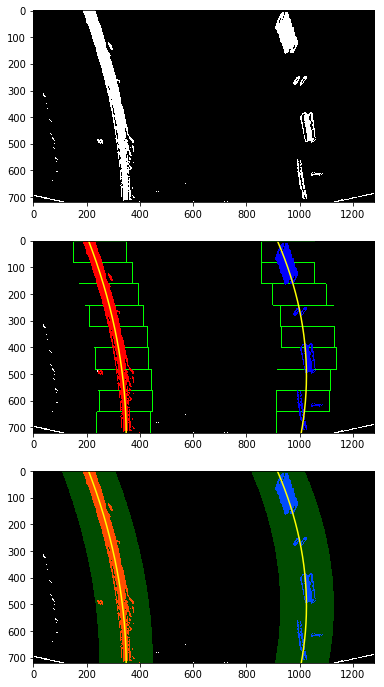

In [85]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

#Transform image and apply gradient threshold
def prepare_image(img):
    undist_img = undist(img)
    binary_warped = bird_eye_transform(undist_img, np.float32(src), np.float32(dst))
    binary_warped = sobel_comb(binary_warped, ksize=15, thresh=(20, 100), thresh_color=(180, 255))
    return binary_warped, undist_img

def find_lines(binary_warped):
    histogram = np.sum(binary_warped[binary_warped.shape[0] // 2:, :], axis=0)
    #plt.plot(histogram)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped)) * 255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0] / 2)
    print(histogram.shape)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0] / nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window + 1) * window_height
        win_y_high = binary_warped.shape[0] - window * window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high),
                      (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high),
                      (0, 255, 0), 2)
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                          (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                           (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
   
    return (left_fit, right_fit, left_fitx, right_fitx, ploty, out_img)   

def find_lines_next_frame(binary_warped, left_fit, right_fit):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return left_fit, right_fit, left_fitx, right_fitx, ploty, result

fig, ax = plt.subplots(3, 1)
fig.set_size_inches(8, 12)
image = mpimg.imread("test_images/test2.jpg")
binary_warped, undist_img = prepare_image(image)
ax[0].imshow(binary_warped, cmap="gray")

(left_fit, right_fit, left_fitx, right_fitx, ploty, out_img) = find_lines(binary_warped) 
(left_fit, right_fit, left_fitx, right_fitx, ploty, result) = find_lines_next_frame(binary_warped, left_fit, right_fit)   
   
ax[1].imshow(out_img)
ax[1].plot(left_fitx, ploty, color='yellow')
ax[1].plot(right_fitx, ploty, color='yellow')

ax[2].imshow(result)
ax[2].plot(left_fitx, ploty, color='yellow')
ax[2].plot(right_fitx, ploty, color='yellow')



## Determine the curvature of the lane and vehicle position with respect to center. 

(1280,)
1909.48617261 1253.37455978


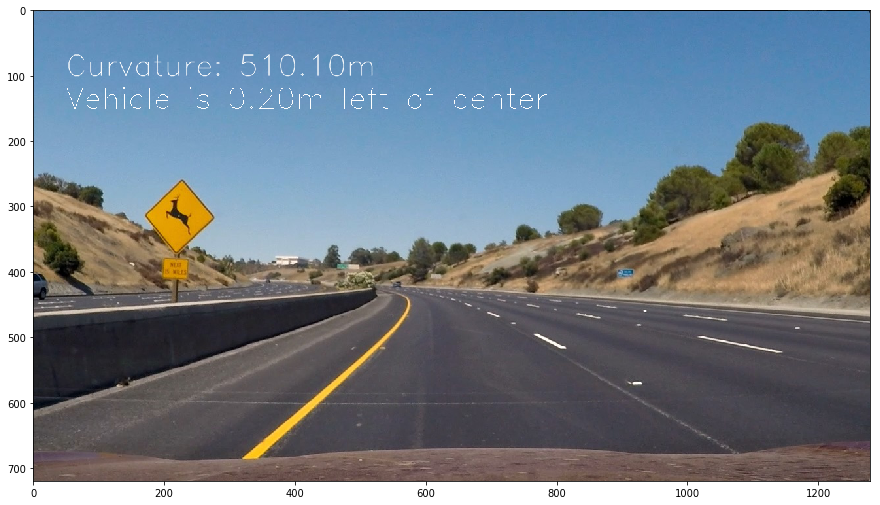

In [73]:
def curvature(left_fit, right_fit, leftx, rightx, ploty):
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2 * left_fit[0] * y_eval + left_fit[1]) ** 2) ** 1.5) / np.absolute(2 * left_fit[0])
    right_curverad = ((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) / np.absolute(2 * right_fit[0])
    print(left_curverad, right_curverad)

    ym_per_pix = 30 / 720  # meters per pixel in y dimension
    xm_per_pix = 3.7 / 700  # meters per pixel in x dimension

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty * ym_per_pix, leftx * xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty * ym_per_pix, rightx * xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2 * left_fit_cr[0] * y_eval * ym_per_pix + left_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * left_fit_cr[0])
    right_curverad = ((1 + (2 * right_fit_cr[0] * y_eval * ym_per_pix + right_fit_cr[1]) ** 2) ** 1.5) / np.absolute(
        2 * right_fit_cr[0])

    curverad = (left_curverad + right_curverad) / 2

    rightx_int = right_fit[0] * 720 ** 2 + right_fit[1] * 720 + right_fit[2]
    leftx_int = left_fit[0] * 720 ** 2 + left_fit[1] * 720 + left_fit[2]

    position = (rightx_int + leftx_int) / 2
    distance_from_center = abs((640 - position) * xm_per_pix)

    return curverad, distance_from_center, position


def draw_curvature(img, curv, distance_from_center, position):
    cv2.putText(img, "Curvature: {0:.2f}m".format(curv), (50, 100), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255),
                lineType=cv2.LINE_AA)

    # Print distance from center on video
    if position > 640:
        cv2.putText(img, 'Vehicle is {:.2f}m left of center'.format(distance_from_center), (50, 150),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1.5, (255, 255, 255))
    else:
        cv2.putText(img, 'Vehicle is {:.2f}m right of center'.format(distance_from_center), (50, 150),
                    cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255))
    return img

original_img = mpimg.imread("test_images/test2.jpg")
binary_warped, undist_img = prepare_image(np.copy(original_img))
(left_fit, right_fit, right_fitx, left_fitx, ploty, debug_img) = find_lines(binary_warped)
(curv, distance_from_center, position) = curvature(left_fit, right_fit, left_fitx, right_fitx, ploty)
plt.figure(figsize=(15, 20))
plt.imshow(draw_curvature(original_img, curv, distance_from_center, position))


## Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


(1280,)
3136.26868739 1049.39795403
(720,)


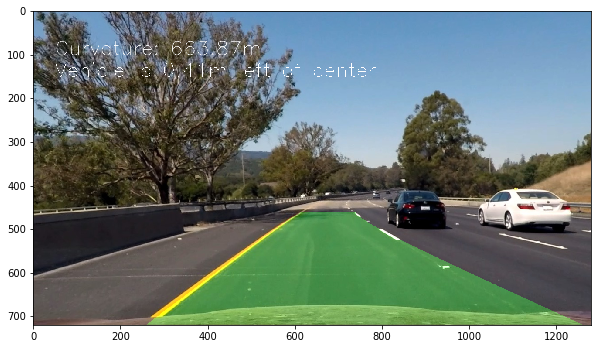

In [75]:
# Create an image to draw the lines on 


def draw_debug_info(image, binary_warped, left_fitx, right_fitx, ploty, curv, distance_from_center, position):
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    print(right_fitx.shape)
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    transform_matrix = cv2.getPerspectiveTransform(np.float32(dst), np.float32(src))
    newwarp = cv2.warpPerspective(color_warp, transform_matrix, (image.shape[1], image.shape[0]))
    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)
    result = draw_curvature(result, curv, distance_from_center, position)
    return result


def process_pipeline(img):
    binary_warped, undist_img = prepare_image(img)
    (left_fit, right_fit, right_fitx, left_fitx, ploty, debug_img) = find_lines(binary_warped)
    curv, distance_from_center, position = curvature(left_fit, right_fit, right_fitx, left_fitx, ploty)
    img = draw_debug_info(undist_img, binary_warped, left_fitx, right_fitx, ploty, curv, distance_from_center, position)
    return img


original_img = mpimg.imread("test_images/test6.jpg")
plt.figure(figsize=(10, 15))
plt.imshow(process_pipeline(original_img))


In [87]:
challenge_output = 'project_processed.mp4'
clip3 = VideoFileClip('project_video.mp4')
first_frame = clip3.get_frame(0)

(left_fitx, right_fitx, left_line, right_line, ploty, debug_img) = find_lines(prepare_image(first_frame)[0])

def process_pipeline_next(img):
    binary_warped, undist_img = prepare_image(img)
    global left_line, right_line
    (left_line, right_line, left_fitx, right_fitx, ploty, debug_img) = \
        find_lines_next_frame(binary_warped, left_line, right_line)
    return draw_debug_info(undist_img, binary_warped, left_fitx, right_fitx, ploty)


challenge_clip = clip3.fl_image(process_pipeline)
%time challenge_clip.write_videofile(challenge_output, audio=False)

(1280,)
(1280,)
1830.16224895 5673.58138511
(720,)
[MoviePy] >>>> Building video project_processed.mp4


[MoviePy] Writing video project_processed.mp4


  0%|          | 0/1261 [00:00<?, ?it/s]

  0%|          | 1/1261 [00:00<02:30,  8.38it/s]

(1280,)
1830.16224895 5673.58138511
(720,)


  0%|          | 2/1261 [00:00<02:31,  8.32it/s]

(1280,)
1814.43680655 5378.96336789
(720,)


  0%|          | 3/1261 [00:00<02:32,  8.24it/s]

(1280,)
1740.49996388 2516.27610923
(720,)


  0%|          | 4/1261 [00:00<02:40,  7.85it/s]

(1280,)
1689.56940304 2133.12601801
(720,)


  0%|          | 5/1261 [00:00<02:41,  7.77it/s]

(1280,)
1804.83908761 2212.74343952
(720,)


  0%|          | 6/1261 [00:00<02:52,  7.27it/s]

(1280,)
1800.87169687 2202.71269849
(720,)


(1280,)
1907.07675564 2413.27065711
(720,)


  1%|          | 7/1261 [00:00<02:59,  6.97it/s]

  1%|          | 8/1261 [00:01<03:03,  6.81it/s]

(1280,)
1943.66940965 7010.73467379
(720,)


  1%|          | 9/1261 [00:01<02:58,  7.02it/s]

(1280,)
1941.62560029 7425.4635472
(720,)


  1%|          | 10/1261 [00:01<02:54,  7.16it/s]

(1280,)
2086.3857335 6034.94707787
(720,)


  1%|          | 11/1261 [00:01<02:52,  7.27it/s]

(1280,)
2170.60089595 4885.25997448
(720,)


  1%|          | 12/1261 [00:01<02:48,  7.40it/s]

(1280,)
2360.89713281 318569.409402
(720,)


  1%|          | 13/1261 [00:01<02:46,  7.51it/s]

(1280,)
2368.85750215 15805.7874485
(720,)


  1%|          | 14/1261 [00:01<02:43,  7.65it/s]

(1280,)
2418.57491499 20308.4165014
(720,)


  1%|          | 15/1261 [00:02<02:43,  7.61it/s]

(1280,)
2509.41208044 3900.43662642
(720,)


  1%|▏         | 16/1261 [00:02<02:42,  7.66it/s]

(1280,)
2513.96175555 2836.41111601
(720,)


  1%|▏         | 17/1261 [00:02<02:43,  7.63it/s]

(1280,)
2664.2826328 3151.16655839
(720,)


  1%|▏         | 18/1261 [00:02<02:41,  7.69it/s]

(1280,)
2948.2985863 3573.89459736
(720,)


  2%|▏         | 19/1261 [00:02<02:41,  7.69it/s]

(1280,)
3096.40744715 3094.56198753
(720,)


  2%|▏         | 20/1261 [00:02<02:39,  7.76it/s]

(1280,)
3374.24260829 3154.16920447
(720,)


  2%|▏         | 21/1261 [00:02<02:39,  7.76it/s]

(1280,)
3678.17137586 4100.70543247
(720,)


  2%|▏         | 22/1261 [00:02<02:40,  7.70it/s]

(1280,)
3559.86512562 3762.71089273
(720,)


  2%|▏         | 23/1261 [00:03<02:42,  7.64it/s]

(1280,)
3599.88704998 3645.53519433
(720,)


  2%|▏         | 24/1261 [00:03<02:42,  7.63it/s]

(1280,)
3286.81872241 3391.61542299
(720,)


  2%|▏         | 25/1261 [00:03<02:41,  7.68it/s]

(1280,)
2898.07707428 2537.58871298
(720,)


  2%|▏         | 26/1261 [00:03<02:42,  7.62it/s]

(1280,)
2910.41976738 3256.59851775
(720,)


  2%|▏         | 27/1261 [00:03<02:41,  7.65it/s]

(1280,)
2582.53034225 3776.71654591
(720,)


  2%|▏         | 28/1261 [00:03<02:41,  7.66it/s]

(1280,)
2583.76243904 5250.1916662
(720,)


  2%|▏         | 29/1261 [00:03<02:40,  7.68it/s]

(1280,)
2427.63919278 4157.6144638
(720,)


  2%|▏         | 30/1261 [00:03<02:40,  7.66it/s]

(1280,)
2274.578161 2099.00260884
(720,)


  2%|▏         | 31/1261 [00:04<02:40,  7.68it/s]

(1280,)
2066.49222449 2248.08292625
(720,)


  3%|▎         | 32/1261 [00:04<02:38,  7.73it/s]

(1280,)
1898.80544879 2195.6817762
(720,)


  3%|▎         | 33/1261 [00:04<02:39,  7.68it/s]

(1280,)
1932.45328217 2561.45394671
(720,)


  3%|▎         | 34/1261 [00:04<02:39,  7.67it/s]

(1280,)
1814.06813849 3269.01090436
(720,)


  3%|▎         | 35/1261 [00:04<02:38,  7.72it/s]

(1280,)
1772.69280338 2563.58460929
(720,)


  3%|▎         | 36/1261 [00:04<02:38,  7.71it/s]

(1280,)
1699.45692508 1940.61042509
(720,)


  3%|▎         | 37/1261 [00:04<02:37,  7.78it/s]

(1280,)
1561.46698121 2244.12320372
(720,)


  3%|▎         | 38/1261 [00:05<02:35,  7.87it/s]

(1280,)
1464.8004667 2709.96084413
(720,)


  3%|▎         | 39/1261 [00:05<02:35,  7.84it/s]

(1280,)
1361.84820794 1787.26296098
(720,)


  3%|▎         | 40/1261 [00:05<02:36,  7.82it/s]

(1280,)
1393.21579725 1588.85752547
(720,)


  3%|▎         | 41/1261 [00:05<02:36,  7.81it/s]

(1280,)
1386.06313873 1689.26836427
(720,)


  3%|▎         | 42/1261 [00:05<02:36,  7.79it/s]

(1280,)
1392.40375709 1831.87117453
(720,)


  3%|▎         | 43/1261 [00:05<02:40,  7.58it/s]

(1280,)
1447.17438606 1913.07406992
(720,)


  3%|▎         | 44/1261 [00:05<02:40,  7.60it/s]

(1280,)
1486.18525414 1900.59293602
(720,)


  4%|▎         | 45/1261 [00:05<02:40,  7.60it/s]

(1280,)
1552.25036587 2022.72633593
(720,)


  4%|▎         | 46/1261 [00:06<02:39,  7.60it/s]

(1280,)
1606.00946107 2017.86379973
(720,)


  4%|▎         | 47/1261 [00:06<02:41,  7.52it/s]

(1280,)
1679.37117894 2106.18473423
(720,)


  4%|▍         | 48/1261 [00:06<02:46,  7.30it/s]

(1280,)
1688.27335482 2279.78947108
(720,)


  4%|▍         | 49/1261 [00:06<02:53,  7.00it/s]

(1280,)
1836.61879136 2641.2769257
(720,)


  4%|▍         | 50/1261 [00:06<02:47,  7.21it/s]

(1280,)
1938.25421982 2120.69195026
(720,)


  4%|▍         | 51/1261 [00:06<02:48,  7.19it/s]

(1280,)
2067.62010384 2931.52388203
(720,)


  4%|▍         | 52/1261 [00:06<02:48,  7.16it/s]

(1280,)
2173.11708926 2935.3343066
(720,)


  4%|▍         | 53/1261 [00:07<02:50,  7.09it/s]

(1280,)
2242.69702234 1910.41722755
(720,)


  4%|▍         | 54/1261 [00:07<02:48,  7.16it/s]

(1280,)
2443.02882671 1775.95606865
(720,)


  4%|▍         | 55/1261 [00:07<02:49,  7.10it/s]

(1280,)
3142.63974531 1895.52697612
(720,)


(1280,)
3250.72693162 2092.60003064
(720,)


  4%|▍         | 56/1261 [00:07<03:02,  6.61it/s]

(1280,)
3317.85853857 2136.55945862
(720,)


  5%|▍         | 57/1261 [00:07<03:04,  6.54it/s]

  5%|▍         | 58/1261 [00:07<02:59,  6.69it/s]

(1280,)
3389.67920492 2347.88148403
(720,)


  5%|▍         | 59/1261 [00:07<02:53,  6.95it/s]

(1280,)
2821.99995333 1780.37716217
(720,)


(1280,)
2625.05843668 3059.98729545
(720,)


  5%|▍         | 60/1261 [00:08<03:02,  6.59it/s]

(1280,)
2419.00276433 3860.53407132
(720,)


  5%|▍         | 61/1261 [00:08<03:04,  6.50it/s]

  5%|▍         | 62/1261 [00:08<02:58,  6.72it/s]

(1280,)
2268.4024999 2877.75542667
(720,)


  5%|▍         | 63/1261 [00:08<02:53,  6.91it/s]

(1280,)
2189.05360199 4374.98104042
(720,)


  5%|▌         | 64/1261 [00:08<02:51,  6.98it/s]

(1280,)
2057.44530981 1972.6219829
(720,)


  5%|▌         | 65/1261 [00:08<02:54,  6.86it/s]

(1280,)
2053.25802775 2227.44757753
(720,)


  5%|▌         | 66/1261 [00:08<02:56,  6.76it/s]

(1280,)
2024.27662095 2553.38846698
(720,)


  5%|▌         | 67/1261 [00:09<02:56,  6.76it/s]

(1280,)
2008.23840953 2721.98943102
(720,)


(1280,)
2264.37812015 2962.8551012


  5%|▌         | 68/1261 [00:09<03:07,  6.37it/s]

  5%|▌         | 69/1261 [00:09<03:04,  6.48it/s]

(720,)
(1280,)
2243.9015334 3310.65489332
(720,)


  6%|▌         | 70/1261 [00:09<03:00,  6.59it/s]

(1280,)
2388.32264156 3481.6875341
(720,)
(1280,)
2629.84339081 3657.65667783
(720,)


  6%|▌         | 71/1261 [00:09<03:04,  6.44it/s]

  6%|▌         | 72/1261 [00:09<03:00,  6.57it/s]

  6%|▌         | 73/1261 [00:10<02:56,  6.73it/s]

(1280,)
2793.44960443 2529.66904564
(720,)
(1280,)
3018.53393197 1990.37566843
(720,)


  6%|▌         | 74/1261 [00:10<02:53,  6.83it/s]

  6%|▌         | 75/1261 [00:10<02:49,  7.01it/s]

(1280,)
3179.40556336 2304.38209149
(720,)
(1280,)
3469.30271097 2696.05048188
(720,)


  6%|▌         | 76/1261 [00:10<02:50,  6.95it/s]

  6%|▌         | 77/1261 [00:10<02:46,  7.10it/s]

(1280,)
3700.41743763 1958.95501033
(720,)
(1280,)
4515.36085464 2300.94463411
(720,)


  6%|▌         | 78/1261 [00:10<02:43,  7.25it/s]

  6%|▋         | 79/1261 [00:10<02:44,  7.18it/s]

(1280,)
4585.04997097 2091.9956344
(720,)
(1280,)
4159.84960114 1665.2335006
(720,)


  6%|▋         | 80/1261 [00:11<02:45,  7.15it/s]

(1280,)
4364.22411784 1793.66103541
(720,)
(1280,)
6272.98671762 1932.87462999


  6%|▋         | 81/1261 [00:11<03:01,  6.50it/s]

  7%|▋         | 82/1261 [00:11<03:07,  6.29it/s]

(720,)
(1280,)
5925.50971551 2052.72978632
(720,)


  7%|▋         | 83/1261 [00:11<03:09,  6.23it/s]

  7%|▋         | 84/1261 [00:11<03:05,  6.36it/s]

(1280,)
5342.84305708 2389.26984605
(720,)
(1280,)
5497.55599442 2554.76381333
(720,)


  7%|▋         | 85/1261 [00:11<03:01,  6.48it/s]

  7%|▋         | 86/1261 [00:11<02:58,  6.57it/s]

(1280,)
4611.75039901 3047.30489473
(720,)
(1280,)
3865.43530885 3122.98185571
(720,)


  7%|▋         | 87/1261 [00:12<02:54,  6.74it/s]

  7%|▋         | 88/1261 [00:12<02:52,  6.78it/s]

(1280,)
3081.45097798 2668.84194754
(720,)
(1280,)
2483.91456585 3982.75213316
(720,)


  7%|▋         | 89/1261 [00:12<02:53,  6.74it/s]

  7%|▋         | 90/1261 [00:12<02:50,  6.86it/s]

(1280,)
2221.33450632 2832.76959859
(720,)
(1280,)
2110.75378476 2008.97054421
(720,)


  7%|▋         | 91/1261 [00:12<02:48,  6.95it/s]

  7%|▋         | 92/1261 [00:12<02:47,  6.99it/s]

(1280,)
1881.56355171 2066.02232562
(720,)
(1280,)
1940.82751991 2186.15538095
(720,)


  7%|▋         | 93/1261 [00:12<02:47,  6.99it/s]

  7%|▋         | 94/1261 [00:13<02:44,  7.10it/s]

(1280,)
2002.05043569 2366.39172053
(720,)
(1280,)
2096.99372222 2589.0168974
(720,)


  8%|▊         | 95/1261 [00:13<02:41,  7.23it/s]

  8%|▊         | 96/1261 [00:13<02:39,  7.31it/s]

(1280,)
2221.78256193 2780.01630705
(720,)
(1280,)
2375.52855068 3743.56058582
(720,)


  8%|▊         | 97/1261 [00:13<02:39,  7.31it/s]

  8%|▊         | 98/1261 [00:13<02:42,  7.14it/s]

(1280,)
2346.9156146 3648.9930442
(720,)
(1280,)
2399.42181842 3526.45795789
(720,)


  8%|▊         | 99/1261 [00:13<02:40,  7.25it/s]

  8%|▊         | 100/1261 [00:13<02:39,  7.26it/s]

(1280,)
2409.97136347 2839.37296296
(720,)
(1280,)
2386.49493855 3098.89936233
(720,)


  8%|▊         | 101/1261 [00:14<02:40,  7.23it/s]

  8%|▊         | 102/1261 [00:14<02:38,  7.30it/s]

(1280,)
2260.93177252 2865.65046766
(720,)
(1280,)
2192.12241307 2376.7389061
(720,)


  8%|▊         | 103/1261 [00:14<02:39,  7.26it/s]

  8%|▊         | 104/1261 [00:14<02:45,  6.99it/s]

(1280,)
2067.99973005 1817.21562143
(720,)
(1280,)
2087.00778209 1847.60089507
(720,)


  8%|▊         | 105/1261 [00:14<02:50,  6.77it/s]

  8%|▊         | 106/1261 [00:14<02:52,  6.71it/s]

(1280,)
2226.26291549 1998.33967143
(720,)
(1280,)
2428.92272974 2092.25520969
(720,)


  8%|▊         | 107/1261 [00:14<02:55,  6.56it/s]

(1280,)
2382.75379334 2152.05493199
(720,)


  9%|▊         | 108/1261 [00:15<03:18,  5.82it/s]

(1280,)
2302.78380247 2303.11638671
(720,)
(1280,)
2420.77903945 3592.96035133
(720,)


  9%|▊         | 109/1261 [00:15<03:15,  5.89it/s]

  9%|▊         | 110/1261 [00:15<03:11,  6.02it/s]

(1280,)
2373.73510295 4236.54219943
(720,)
(1280,)
2257.87910953 4854.17442506
(720,)


  9%|▉         | 111/1261 [00:15<03:16,  5.87it/s]

  9%|▉         | 112/1261 [00:15<03:16,  5.84it/s]

  9%|▉         | 113/1261 [00:16<03:09,  6.05it/s]

(1280,)
2394.80991412 4211.965102
(720,)
(1280,)
2151.83138381 2320.17749923
(720,)


  9%|▉         | 114/1261 [00:16<03:03,  6.24it/s]

(1280,)
2018.56346472 2298.75856575
(720,)
(1280,)

  9%|▉         | 115/1261 [00:16<03:17,  5.79it/s]

  9%|▉         | 116/1261 [00:16<03:09,  6.03it/s]


1827.12526179 2004.14151236
(720,)
(1280,)
1761.52751767 1484.08952521
(720,)


  9%|▉         | 117/1261 [00:16<03:29,  5.46it/s]

(1280,)
1790.56902647 1596.21985444
(720,)


  9%|▉         | 118/1261 [00:17<04:06,  4.63it/s]

(1280,)
1853.17855985 1664.20756442
(720,)


  9%|▉         | 119/1261 [00:17<04:09,  4.57it/s]

(1280,)
1801.88078116 1699.13216905
(720,)
(1280,)


 10%|▉         | 120/1261 [00:17<03:59,  4.76it/s]

 10%|▉         | 121/1261 [00:17<03:46,  5.02it/s]

1766.73910277 1780.37410583
(720,)
(1280,)
1867.04953332 1920.30567262
(720,)


 10%|▉         | 122/1261 [00:17<03:39,  5.18it/s]

(1280,)
1813.10901383 1984.17864423
(720,)
(1280,)


 10%|▉         | 123/1261 [00:17<03:36,  5.26it/s]

 10%|▉         | 124/1261 [00:18<03:21,  5.65it/s]

1718.7158042 1729.03090929
(720,)
(1280,)
1689.54034337 2111.61162497
(720,)


 10%|▉         | 125/1261 [00:18<03:11,  5.94it/s]

 10%|▉         | 126/1261 [00:18<03:00,  6.27it/s]

(1280,)
1662.7152104 2201.78215235
(720,)
(1280,)
1761.61759765 2419.40928591
(720,)


 10%|█         | 127/1261 [00:18<02:54,  6.51it/s]

 10%|█         | 128/1261 [00:18<02:51,  6.61it/s]

(1280,)
1688.87257271 1489.8860508
(720,)
(1280,)
1738.39971607 1571.52371622
(720,)


 10%|█         | 129/1261 [00:18<02:50,  6.65it/s]

 10%|█         | 130/1261 [00:18<02:46,  6.78it/s]

(1280,)
1726.62651647 1554.30139786
(720,)
(1280,)
1814.2569087 1677.31751808
(720,)


 10%|█         | 131/1261 [00:19<02:44,  6.89it/s]

 10%|█         | 132/1261 [00:19<02:44,  6.88it/s]

(1280,)
1961.00550629 1815.43589557
(720,)
(1280,)
1946.13467619 1765.73673491
(720,)


 11%|█         | 133/1261 [00:19<02:40,  7.02it/s]

 11%|█         | 134/1261 [00:19<02:37,  7.13it/s]

(1280,)
1995.14104668 1686.22564441
(720,)
(1280,)
1936.83135841 1426.86756041
(720,)


 11%|█         | 135/1261 [00:19<02:42,  6.94it/s]

 11%|█         | 136/1261 [00:19<02:42,  6.94it/s]

(1280,)
1980.25566499 1399.42883349
(720,)
(1280,)
2062.07381325 1599.73175828
(720,)


 11%|█         | 137/1261 [00:19<02:38,  7.07it/s]

 11%|█         | 138/1261 [00:20<02:38,  7.07it/s]

(1280,)
2091.8001679 1983.34179469
(720,)
(1280,)
2193.57831234 2405.42721582
(720,)


 11%|█         | 139/1261 [00:20<02:40,  7.00it/s]

(1280,)
2226.11833557 2678.18042022
(720,)
(1280,)
2318.06719959 3178.65918424
(720,)


 11%|█         | 140/1261 [00:20<02:45,  6.78it/s]

 11%|█         | 141/1261 [00:20<02:41,  6.94it/s]

 11%|█▏        | 142/1261 [00:20<02:37,  7.12it/s]

(1280,)
2271.45076894 2802.66110839
(720,)
(1280,)
2456.59509062 2402.89350573
(720,)


 11%|█▏        | 143/1261 [00:20<02:36,  7.16it/s]

 11%|█▏        | 144/1261 [00:20<02:35,  7.17it/s]

(1280,)
2646.40904731 2735.88303971
(720,)
(1280,)
2618.91383523 3081.43183727
(720,)


 11%|█▏        | 145/1261 [00:21<02:33,  7.28it/s]

 12%|█▏        | 146/1261 [00:21<02:34,  7.24it/s]

(1280,)
2878.52466176 2879.94360682
(720,)
(1280,)
3030.01892247 2309.05365913
(720,)


 12%|█▏        | 147/1261 [00:21<02:35,  7.18it/s]

 12%|█▏        | 148/1261 [00:21<02:34,  7.21it/s]

(1280,)
3006.29582178 1964.53158789
(720,)
(1280,)
2823.20940667 2181.49688549
(720,)


 12%|█▏        | 149/1261 [00:21<02:33,  7.23it/s]

 12%|█▏        | 150/1261 [00:21<02:30,  7.36it/s]

(1280,)
2763.85710594 2838.83070954
(720,)
(1280,)
2788.14510543 2729.80048537
(720,)


 12%|█▏        | 151/1261 [00:21<02:30,  7.38it/s]

 12%|█▏        | 152/1261 [00:22<02:33,  7.23it/s]

(1280,)
3015.80803808 2278.13613601
(720,)
(1280,)
2749.96590235 1822.67845776
(720,)


 12%|█▏        | 153/1261 [00:22<02:31,  7.30it/s]

 12%|█▏        | 154/1261 [00:22<02:33,  7.22it/s]

(1280,)
2446.41523543 1719.88038137
(720,)
(1280,)
2530.99837937 1902.60389026
(720,)


 12%|█▏        | 155/1261 [00:22<02:34,  7.18it/s]

 12%|█▏        | 156/1261 [00:22<02:34,  7.18it/s]

(1280,)
2724.20649244 2091.05994975
(720,)
(1280,)
2672.71030504 2277.45125355
(720,)


 12%|█▏        | 157/1261 [00:22<02:35,  7.11it/s]

 13%|█▎        | 158/1261 [00:22<02:33,  7.19it/s]

(1280,)
2599.15980692 2239.1479261
(720,)
(1280,)
2373.98378054 2402.22885472
(720,)


 13%|█▎        | 159/1261 [00:23<02:31,  7.27it/s]

 13%|█▎        | 160/1261 [00:23<02:33,  7.16it/s]

(1280,)
2357.86074941 1934.85272281
(720,)
(1280,)
2214.48475443 2182.84590315
(720,)


 13%|█▎        | 161/1261 [00:23<02:31,  7.28it/s]

 13%|█▎        | 162/1261 [00:23<02:31,  7.28it/s]

(1280,)
2247.57711531 2872.77420476
(720,)
(1280,)
2206.94560497 3714.18263093
(720,)


 13%|█▎        | 163/1261 [00:23<02:32,  7.21it/s]

 13%|█▎        | 164/1261 [00:23<02:31,  7.24it/s]

(1280,)
2160.42882317 5292.13425114
(720,)
(1280,)
2057.65299538 9992.93322095
(720,)


 13%|█▎        | 165/1261 [00:23<02:29,  7.32it/s]

 13%|█▎        | 166/1261 [00:24<02:29,  7.32it/s]

(1280,)
1867.03792228 2073.13130421
(720,)
(1280,)
2088.29761281 2317.44237838
(720,)


 13%|█▎        | 167/1261 [00:24<02:28,  7.39it/s]

 13%|█▎        | 168/1261 [00:24<02:28,  7.35it/s]

(1280,)
2023.91109113 2288.67241512
(720,)
(1280,)
2324.74224944 2599.78851334
(720,)


 13%|█▎        | 169/1261 [00:24<02:28,  7.38it/s]

 13%|█▎        | 170/1261 [00:24<02:27,  7.39it/s]

(1280,)
2460.76995241 2550.51491243
(720,)
(1280,)
2677.30458541 2530.8569529
(720,)


 14%|█▎        | 171/1261 [00:24<02:27,  7.41it/s]

 14%|█▎        | 172/1261 [00:24<02:29,  7.27it/s]

(1280,)
2914.46880875 2327.88487007
(720,)
(1280,)
2731.44199003 1881.8491136
(720,)


 14%|█▎        | 173/1261 [00:24<02:28,  7.32it/s]

 14%|█▍        | 174/1261 [00:25<02:29,  7.28it/s]

(1280,)
2754.26510276 1356.65484661
(720,)
(1280,)
2535.5937788 1346.34568326
(720,)


 14%|█▍        | 175/1261 [00:25<02:30,  7.21it/s]

 14%|█▍        | 176/1261 [00:25<02:30,  7.22it/s]

(1280,)
2405.25727333 1175.37366411
(720,)
(1280,)
2347.78246662 924.286279381
(720,)


 14%|█▍        | 177/1261 [00:25<02:28,  7.28it/s]

 14%|█▍        | 178/1261 [00:25<02:27,  7.34it/s]

(1280,)
2453.72899789 972.424441427
(720,)
(1280,)
2377.89591141 1040.863768
(720,)


 14%|█▍        | 179/1261 [00:25<02:27,  7.31it/s]

 14%|█▍        | 180/1261 [00:25<02:27,  7.33it/s]

(1280,)
2443.22112048 1116.6293309
(720,)
(1280,)
2556.5533283 1234.51664978
(720,)


 14%|█▍        | 181/1261 [00:26<02:30,  7.20it/s]

 14%|█▍        | 182/1261 [00:26<02:28,  7.24it/s]

(1280,)
2170.63442498 1251.20579702
(720,)
(1280,)
2164.70489741 1358.30202245
(720,)


 15%|█▍        | 183/1261 [00:26<02:27,  7.30it/s]

 15%|█▍        | 184/1261 [00:26<02:27,  7.28it/s]

(1280,)
1972.38164251 1394.55138764
(720,)
(1280,)
1722.91949999 1606.36577971
(720,)


 15%|█▍        | 185/1261 [00:26<02:27,  7.31it/s]

 15%|█▍        | 186/1261 [00:26<02:27,  7.30it/s]

(1280,)
1582.43183906 1502.12293842
(720,)
(1280,)
1422.57492518 1202.53958195
(720,)


 15%|█▍        | 187/1261 [00:26<02:25,  7.38it/s]

 15%|█▍        | 188/1261 [00:27<02:29,  7.20it/s]

(1280,)
1429.65415569 1166.80256062
(720,)
(1280,)
1386.82064319 1308.32265548
(720,)


 15%|█▍        | 189/1261 [00:27<02:30,  7.10it/s]

 15%|█▌        | 190/1261 [00:27<02:29,  7.16it/s]

(1280,)
1375.96946425 1336.2065172
(720,)
(1280,)
1431.19184699 1465.39139621
(720,)


 15%|█▌        | 191/1261 [00:27<02:26,  7.29it/s]

 15%|█▌        | 192/1261 [00:27<02:26,  7.29it/s]

(1280,)
1379.54513427 1609.03470121
(720,)
(1280,)
1524.12595317 1808.67084026
(720,)


 15%|█▌        | 193/1261 [00:27<02:25,  7.33it/s]

 15%|█▌        | 194/1261 [00:27<02:22,  7.48it/s]

(1280,)
1570.85097639 1799.78248059
(720,)
(1280,)
1655.60529219 1772.40033002
(720,)


 15%|█▌        | 195/1261 [00:27<02:19,  7.62it/s]

 16%|█▌        | 196/1261 [00:28<02:18,  7.71it/s]

(1280,)
1765.12287537 1672.73277157
(720,)
(1280,)
1977.27500438 2019.44783995
(720,)


 16%|█▌        | 197/1261 [00:28<02:17,  7.73it/s]

 16%|█▌        | 198/1261 [00:28<02:16,  7.78it/s]

(1280,)
2175.53789647 3038.18567462
(720,)
(1280,)
2470.06625241 3203.80026141
(720,)


 16%|█▌        | 199/1261 [00:28<02:15,  7.86it/s]

 16%|█▌        | 200/1261 [00:28<02:14,  7.88it/s]

(1280,)
2680.06087387 4212.98153518
(720,)
(1280,)
2815.97042478 4130.24388914
(720,)


 16%|█▌        | 201/1261 [00:28<02:15,  7.80it/s]

 16%|█▌        | 202/1261 [00:28<02:13,  7.91it/s]

(1280,)
3001.72537745 2941.76384127
(720,)
(1280,)
2822.56071087 3129.27608621
(720,)


 16%|█▌        | 203/1261 [00:28<02:14,  7.89it/s]

 16%|█▌        | 204/1261 [00:29<02:23,  7.38it/s]

(1280,)
2474.71596425 2744.99153078
(720,)
(1280,)
2306.52634844 1812.58988187
(720,)


 16%|█▋        | 205/1261 [00:29<02:24,  7.33it/s]

 16%|█▋        | 206/1261 [00:29<02:26,  7.20it/s]

(1280,)
2335.9072289 1838.13383043
(720,)
(1280,)
2169.18416526 1942.06637122
(720,)


 16%|█▋        | 207/1261 [00:29<02:32,  6.93it/s]

 16%|█▋        | 208/1261 [00:29<02:32,  6.91it/s]

(1280,)
1964.75182706 1892.73368475
(720,)
(1280,)
1868.54364851 1554.24107304
(720,)


 17%|█▋        | 209/1261 [00:29<02:30,  6.98it/s]

 17%|█▋        | 210/1261 [00:29<02:26,  7.18it/s]

(1280,)
1924.7127197 1585.75437945
(720,)
(1280,)
1954.44832977 1445.39152051
(720,)


 17%|█▋        | 211/1261 [00:30<02:23,  7.30it/s]

 17%|█▋        | 212/1261 [00:30<02:24,  7.25it/s]

(1280,)
1992.62039813 1592.81697682
(720,)
(1280,)
1862.89471812 2075.48864942
(720,)


 17%|█▋        | 213/1261 [00:30<02:21,  7.39it/s]

 17%|█▋        | 214/1261 [00:30<02:18,  7.54it/s]

(1280,)
1840.66154286 2359.74159562
(720,)
(1280,)
1717.8725775 2722.56953165
(720,)


 17%|█▋        | 215/1261 [00:30<02:18,  7.56it/s]

(1280,)
1682.48117814 1817.32047151
(720,)
(1280,)
1719.65983323 1924.96832859
(720,)


 17%|█▋        | 216/1261 [00:30<02:29,  6.99it/s]

 17%|█▋        | 217/1261 [00:30<02:34,  6.76it/s]

 17%|█▋        | 218/1261 [00:31<02:34,  6.77it/s]

(1280,)
1724.96837555 2192.30558248
(720,)
(1280,)
1874.42882386 2305.10342203
(720,)


 17%|█▋        | 219/1261 [00:31<02:29,  6.99it/s]

 17%|█▋        | 220/1261 [00:31<02:25,  7.15it/s]

(1280,)
1866.31994761 2464.07764662
(720,)
(1280,)
1977.5476093 2484.99533235
(720,)


 18%|█▊        | 221/1261 [00:31<02:28,  7.00it/s]

 18%|█▊        | 222/1261 [00:31<02:26,  7.08it/s]

(1280,)
2046.47082609 1627.87854252
(720,)
(1280,)
2222.55243708 1689.18371991
(720,)


 18%|█▊        | 223/1261 [00:31<02:27,  7.05it/s]

 18%|█▊        | 224/1261 [00:31<02:28,  7.00it/s]

(1280,)
2291.20663506 1665.11265422
(720,)
(1280,)
2149.88754429 2408.13264234
(720,)


 18%|█▊        | 225/1261 [00:32<02:27,  7.04it/s]

 18%|█▊        | 226/1261 [00:32<02:26,  7.07it/s]

(1280,)
2139.62213853 2517.08575971
(720,)
(1280,)
2047.51069027 2090.13113034
(720,)


 18%|█▊        | 227/1261 [00:32<02:24,  7.15it/s]

 18%|█▊        | 228/1261 [00:32<02:24,  7.17it/s]

(1280,)
2234.55361731 1993.09385275
(720,)
(1280,)
2395.45282491 2143.92921344
(720,)


 18%|█▊        | 229/1261 [00:32<02:23,  7.21it/s]

 18%|█▊        | 230/1261 [00:32<02:21,  7.30it/s]

(1280,)
2582.71974459 2357.71966909
(720,)
(1280,)
2657.28783796 2410.60650974
(720,)


 18%|█▊        | 231/1261 [00:32<02:20,  7.31it/s]

 18%|█▊        | 232/1261 [00:33<02:23,  7.19it/s]

(1280,)
2884.57988089 2322.59624812
(720,)
(1280,)
3063.65134965 2469.37655157
(720,)


 18%|█▊        | 233/1261 [00:33<02:21,  7.27it/s]

 19%|█▊        | 234/1261 [00:33<02:20,  7.33it/s]

(1280,)
3017.17989502 1859.11510813
(720,)
(1280,)
3042.40970228 1801.04895264
(720,)


 19%|█▊        | 235/1261 [00:33<02:22,  7.18it/s]

 19%|█▊        | 236/1261 [00:33<02:22,  7.21it/s]

(1280,)
2921.42806752 1754.04424044
(720,)
(1280,)
2738.95065382 2000.54237227
(720,)


 19%|█▉        | 237/1261 [00:33<02:21,  7.25it/s]

 19%|█▉        | 238/1261 [00:33<02:20,  7.29it/s]

(1280,)
2691.58499736 2028.04981916
(720,)
(1280,)
2245.08813328 1306.16961597
(720,)


 19%|█▉        | 239/1261 [00:34<02:19,  7.35it/s]

 19%|█▉        | 240/1261 [00:34<02:21,  7.22it/s]

(1280,)
2356.97843656 1381.33943147
(720,)
(1280,)
2338.97026963 1482.38750976
(720,)


 19%|█▉        | 241/1261 [00:34<02:20,  7.25it/s]

 19%|█▉        | 242/1261 [00:34<02:19,  7.28it/s]

(1280,)
2608.78764631 1540.74773595
(720,)
(1280,)
2703.05939691 1640.8557681
(720,)


 19%|█▉        | 243/1261 [00:34<02:18,  7.35it/s]

 19%|█▉        | 244/1261 [00:34<02:19,  7.31it/s]

(1280,)
2448.10902499 1677.98559877
(720,)
(1280,)
2382.91954247 1709.6017331
(720,)


 19%|█▉        | 245/1261 [00:34<02:19,  7.31it/s]

 20%|█▉        | 246/1261 [00:34<02:21,  7.15it/s]

(1280,)
2229.16053504 1807.60803167
(720,)
(1280,)
2108.73998183 1761.40925262
(720,)


 20%|█▉        | 247/1261 [00:35<02:21,  7.17it/s]

 20%|█▉        | 248/1261 [00:35<02:23,  7.08it/s]

(1280,)
2085.30385647 1743.4499925
(720,)
(1280,)
1938.09296329 1259.2942444
(720,)


 20%|█▉        | 249/1261 [00:35<02:22,  7.13it/s]

 20%|█▉        | 250/1261 [00:35<02:23,  7.07it/s]

(1280,)
1991.97652319 1106.41468133
(720,)
(1280,)
1849.38145676 1212.16378304
(720,)


 20%|█▉        | 251/1261 [00:35<02:22,  7.07it/s]

 20%|█▉        | 252/1261 [00:35<02:23,  7.03it/s]

(1280,)
1983.2508958 1349.77165994
(720,)
(1280,)
2060.56912072 1602.1692181
(720,)


 20%|██        | 253/1261 [00:35<02:23,  7.04it/s]

 20%|██        | 254/1261 [00:36<02:21,  7.13it/s]

(1280,)
2193.09151725 1786.63133871
(720,)
(1280,)
2278.83919387 1862.53917203
(720,)


 20%|██        | 255/1261 [00:36<02:22,  7.07it/s]

 20%|██        | 256/1261 [00:36<02:21,  7.08it/s]

(1280,)
2429.69888823 1931.89627971
(720,)
(1280,)
2461.54707928 1727.42414796
(720,)


 20%|██        | 257/1261 [00:36<02:20,  7.17it/s]

 20%|██        | 258/1261 [00:36<02:18,  7.22it/s]

(1280,)
2376.64708325 1090.8838838
(720,)
(1280,)
2411.88741265 1107.40730488
(720,)


 21%|██        | 259/1261 [00:36<02:17,  7.28it/s]

 21%|██        | 260/1261 [00:36<02:16,  7.32it/s]

(1280,)
2467.76551531 1162.67589586
(720,)
(1280,)
2436.79869697 1189.2393588
(720,)


 21%|██        | 261/1261 [00:37<02:15,  7.36it/s]

 21%|██        | 262/1261 [00:37<02:14,  7.43it/s]

(1280,)
2520.0222316 1346.55581143
(720,)
(1280,)
2607.33012432 1223.76547161
(720,)


 21%|██        | 263/1261 [00:37<02:14,  7.44it/s]

 21%|██        | 264/1261 [00:37<02:15,  7.36it/s]

(1280,)
2696.73415721 1432.6433588
(720,)
(1280,)
2687.86708018 1596.08659188
(720,)


 21%|██        | 265/1261 [00:37<02:14,  7.39it/s]

 21%|██        | 266/1261 [00:37<02:14,  7.41it/s]

(1280,)
2853.59018743 1707.32942929
(720,)
(1280,)
2812.68112937 1893.94136602
(720,)


 21%|██        | 267/1261 [00:37<02:16,  7.30it/s]

 21%|██▏       | 268/1261 [00:38<02:15,  7.31it/s]

(1280,)
2700.89826164 2067.24988808
(720,)
(1280,)
2589.06756905 2193.36622798
(720,)


 21%|██▏       | 269/1261 [00:38<02:16,  7.24it/s]

(1280,)
2729.45619465 2361.15442272
(720,)
(1280,)
2569.91732191 3956.17062302
(720,)


 21%|██▏       | 270/1261 [00:38<02:22,  6.93it/s]

 21%|██▏       | 271/1261 [00:38<02:43,  6.04it/s]

(1280,)
2334.41584075 2017.62680807
(720,)


 22%|██▏       | 272/1261 [00:38<03:19,  4.97it/s]

(1280,)
2247.25288058 2306.48287161
(720,)


 22%|██▏       | 273/1261 [00:39<03:35,  4.58it/s]

(1280,)
2227.14119089 2219.11269768
(720,)


 22%|██▏       | 274/1261 [00:39<03:37,  4.53it/s]

(1280,)
2191.00244434 1575.02690395
(720,)


 22%|██▏       | 275/1261 [00:39<03:36,  4.56it/s]

(1280,)
2327.01817243 1707.49131632
(720,)


 22%|██▏       | 276/1261 [00:39<03:35,  4.57it/s]

(1280,)
2462.23316714 1890.3284932
(720,)
(1280,)

 22%|██▏       | 277/1261 [00:39<03:33,  4.61it/s]


2748.26455838 2232.23409283
(720,)
(1280,)
2854.0328402 2340.64338064
(720,)


 22%|██▏       | 278/1261 [00:40<03:24,  4.80it/s]

 22%|██▏       | 279/1261 [00:40<03:17,  4.97it/s]

(1280,)
2821.85694398 2681.30630123
(720,)
(1280,)


 22%|██▏       | 280/1261 [00:40<03:11,  5.12it/s]

2931.72919681 2580.34754573
(720,)
(1280,)
2915.29468665 2238.69578121
(720,)


 22%|██▏       | 281/1261 [00:40<03:06,  5.26it/s]

 22%|██▏       | 282/1261 [00:40<02:57,  5.51it/s]

(1280,)
3181.86269709 2154.43680357
(720,)
(1280,)
3216.18043527 2995.59360208
(720,)


 22%|██▏       | 283/1261 [00:41<02:52,  5.67it/s]

 23%|██▎       | 284/1261 [00:41<02:52,  5.68it/s]

(1280,)
3538.76244144 3681.61560226
(720,)
(1280,)
3459.79493162 3295.14941546
(720,)


 23%|██▎       | 285/1261 [00:41<02:49,  5.75it/s]

 23%|██▎       | 286/1261 [00:41<02:45,  5.89it/s]

 23%|██▎       | 287/1261 [00:41<02:41,  6.04it/s]

(1280,)
3425.17048779 3411.42694874
(720,)
(1280,)
3540.51692805 2414.5484803
(720,)


 23%|██▎       | 288/1261 [00:41<02:39,  6.12it/s]

 23%|██▎       | 289/1261 [00:41<02:36,  6.19it/s]

(1280,)
3816.50026702 2503.55335448
(720,)
(1280,)
4158.85909133 2626.73030088
(720,)


 23%|██▎       | 290/1261 [00:42<02:35,  6.26it/s]

 23%|██▎       | 291/1261 [00:42<02:32,  6.35it/s]

(1280,)
4390.69938607 2841.60499623
(720,)
(1280,)
4555.88484932 3140.08371747
(720,)


 23%|██▎       | 292/1261 [00:42<02:36,  6.19it/s]

(1280,)
4532.6468477 3203.4760526
(720,)
(1280,)


 23%|██▎       | 293/1261 [00:42<02:41,  5.98it/s]

 23%|██▎       | 294/1261 [00:42<02:40,  6.04it/s]

4950.58709787 2730.61033184
(720,)
(1280,)
5520.90112306 2449.41829453
(720,)


 23%|██▎       | 295/1261 [00:42<02:39,  6.05it/s]

(1280,)
4491.445816 2856.50763189
(720,)
(1280,)
3973.9950878 3381.92760177
(720,)


 23%|██▎       | 296/1261 [00:43<02:36,  6.18it/s]

 24%|██▎       | 297/1261 [00:43<02:33,  6.29it/s]

 24%|██▎       | 298/1261 [00:43<02:32,  6.33it/s]

(1280,)
3921.96045781 3561.18258813
(720,)
(1280,)
4397.62375256 2683.27124594
(720,)


 24%|██▎       | 299/1261 [00:43<02:30,  6.40it/s]

 24%|██▍       | 300/1261 [00:43<02:28,  6.49it/s]

(1280,)
4500.57743217 2218.7810348
(720,)
(1280,)
4603.43738871 2585.67346672
(720,)


 24%|██▍       | 301/1261 [00:43<02:27,  6.50it/s]

(1280,)
5130.35517826 3126.19753751
(720,)
(1280,)
6163.44876662 3191.52152801
(720,)


 24%|██▍       | 302/1261 [00:44<02:30,  6.38it/s]

 24%|██▍       | 303/1261 [00:44<02:29,  6.41it/s]

 24%|██▍       | 304/1261 [00:44<02:28,  6.46it/s]

(1280,)
6137.15822056 3769.7491911
(720,)
(1280,)
15603.236976 4760.65043568
(720,)


 24%|██▍       | 305/1261 [00:44<02:29,  6.41it/s]

 24%|██▍       | 306/1261 [00:44<02:27,  6.48it/s]

(1280,)
12373.5229648 44183.6627796
(720,)
(1280,)
7263.32648041 11604.3113045
(720,)


 24%|██▍       | 307/1261 [00:44<02:25,  6.54it/s]

 24%|██▍       | 308/1261 [00:44<02:23,  6.64it/s]

(1280,)
7201.3170547 9052.77201083
(720,)
(1280,)
6420.54180742 10432.6892738
(720,)


 25%|██▍       | 309/1261 [00:45<02:21,  6.72it/s]

 25%|██▍       | 310/1261 [00:45<02:22,  6.70it/s]

(1280,)
5929.13096939 15339.2977493
(720,)
(1280,)
6736.80980262 72736.7248727
(720,)


 25%|██▍       | 311/1261 [00:45<02:23,  6.61it/s]

 25%|██▍       | 312/1261 [00:45<02:24,  6.57it/s]

(1280,)
5931.78370267 10409.4144893
(720,)
(1280,)
7403.98658255 14250.1156184
(720,)


 25%|██▍       | 313/1261 [00:45<02:23,  6.59it/s]

 25%|██▍       | 314/1261 [00:45<02:24,  6.57it/s]

(1280,)
9862.20611469 37494.5753303
(720,)
(1280,)
21938.9837517 49279.9939263
(720,)


 25%|██▍       | 315/1261 [00:46<02:23,  6.60it/s]

 25%|██▌       | 316/1261 [00:46<02:21,  6.67it/s]

(1280,)
19166.0760956 48864.8227628
(720,)
(1280,)
28889.4134766 37987.7223395
(720,)


 25%|██▌       | 317/1261 [00:46<02:21,  6.67it/s]

 25%|██▌       | 318/1261 [00:46<02:22,  6.64it/s]

(1280,)
56994.0942045 4088.89585224
(720,)
(1280,)
46745.4035017 3122.23165354
(720,)


 25%|██▌       | 319/1261 [00:46<02:20,  6.71it/s]

 25%|██▌       | 320/1261 [00:46<02:19,  6.74it/s]

(1280,)
21746.266714 3347.83860963
(720,)
(1280,)
31546.3649151 2676.05713171
(720,)


 25%|██▌       | 321/1261 [00:46<02:19,  6.75it/s]

 26%|██▌       | 322/1261 [00:47<02:21,  6.62it/s]

(1280,)
65648.2807032 3011.62195692
(720,)
(1280,)
22090.4838757 2880.22597078
(720,)


 26%|██▌       | 323/1261 [00:47<02:23,  6.53it/s]

 26%|██▌       | 324/1261 [00:47<02:22,  6.57it/s]

(1280,)
22464.3937543 3438.02549733
(720,)
(1280,)
11849.7358905 3708.36413895
(720,)


 26%|██▌       | 325/1261 [00:47<02:21,  6.61it/s]

 26%|██▌       | 326/1261 [00:47<02:22,  6.57it/s]

(1280,)
22623.1152288 4718.7548797
(720,)
(1280,)
8021.93522504 5487.47872757
(720,)


 26%|██▌       | 327/1261 [00:47<02:21,  6.62it/s]

 26%|██▌       | 328/1261 [00:47<02:20,  6.64it/s]

(1280,)
6241.07658702 6033.78212005
(720,)
(1280,)
5837.2852373 6914.14592462
(720,)


 26%|██▌       | 329/1261 [00:48<02:21,  6.60it/s]

 26%|██▌       | 330/1261 [00:48<02:21,  6.60it/s]

(1280,)
20370.5106228 16151.4384272
(720,)
(1280,)
38771.4413014 8993.84291641
(720,)


 26%|██▌       | 331/1261 [00:48<02:18,  6.70it/s]

 26%|██▋       | 332/1261 [00:48<02:18,  6.71it/s]

(1280,)
848178.426129 27154.4392374
(720,)
(1280,)
48907.1711645 12674.4066552
(720,)


 26%|██▋       | 333/1261 [00:48<02:16,  6.82it/s]

 26%|██▋       | 334/1261 [00:48<02:16,  6.77it/s]

(1280,)
19361.4016056 4790.89320314
(720,)
(1280,)
14936.4902157 6419.14497415
(720,)


 27%|██▋       | 335/1261 [00:49<02:19,  6.66it/s]

 27%|██▋       | 336/1261 [00:49<02:17,  6.71it/s]

(1280,)
13155.337469 10440.9121537
(720,)
(1280,)
15655.9942742 12338.3525179
(720,)


 27%|██▋       | 337/1261 [00:49<02:18,  6.69it/s]

 27%|██▋       | 338/1261 [00:49<02:18,  6.69it/s]

(1280,)
12256.1856524 10493.8271134
(720,)
(1280,)
22506.1429243 12766.4938077
(720,)


 27%|██▋       | 339/1261 [00:49<02:16,  6.75it/s]

 27%|██▋       | 340/1261 [00:49<02:15,  6.78it/s]

(1280,)
74730.859912 28869.9424641
(720,)
(1280,)
70052.788559 81207.6638624
(720,)


 27%|██▋       | 341/1261 [00:49<02:15,  6.78it/s]

 27%|██▋       | 342/1261 [00:50<02:15,  6.80it/s]

(1280,)
14243.6142223 13621.4487549
(720,)
(1280,)
15342.3524993 17937.5178032
(720,)


 27%|██▋       | 343/1261 [00:50<02:14,  6.82it/s]

 27%|██▋       | 344/1261 [00:50<02:14,  6.83it/s]

(1280,)
12391.2518775 15643.3606843
(720,)
(1280,)
11169.8028168 13939.4495733
(720,)


 27%|██▋       | 345/1261 [00:50<02:13,  6.86it/s]

 27%|██▋       | 346/1261 [00:50<02:15,  6.77it/s]

(1280,)
12418.484672 11348.4295899
(720,)
(1280,)
12666.6906455 35863.2212257
(720,)


 28%|██▊       | 347/1261 [00:50<02:15,  6.73it/s]

 28%|██▊       | 348/1261 [00:50<02:14,  6.79it/s]

(1280,)
20531.6180843 12216.9468042
(720,)
(1280,)
11365.6369905 20933.4077498
(720,)


 28%|██▊       | 349/1261 [00:51<02:15,  6.72it/s]

 28%|██▊       | 350/1261 [00:51<02:13,  6.81it/s]

(1280,)
70677.3061639 11629.8641366
(720,)
(1280,)
13206.9736256 13638.7758704
(720,)


 28%|██▊       | 351/1261 [00:51<02:12,  6.85it/s]

 28%|██▊       | 352/1261 [00:51<02:10,  6.97it/s]

(1280,)
99819.5763088 15233.4410355
(720,)
(1280,)
31893.2623582 24598.595854
(720,)


 28%|██▊       | 353/1261 [00:51<02:09,  6.99it/s]

 28%|██▊       | 354/1261 [00:51<02:08,  7.07it/s]

(1280,)
11594.7174599 14776.4470896
(720,)
(1280,)
8531.27912343 10254.2221335
(720,)


 28%|██▊       | 355/1261 [00:51<02:07,  7.10it/s]

 28%|██▊       | 356/1261 [00:52<02:05,  7.19it/s]

(1280,)
7986.43630659 17854.2240442
(720,)
(1280,)
6765.22415674 18763.8870042
(720,)


 28%|██▊       | 357/1261 [00:52<02:06,  7.17it/s]

 28%|██▊       | 358/1261 [00:52<02:04,  7.27it/s]

(1280,)
7669.76037971 16009.5491818
(720,)
(1280,)
9865.24184049 16290.0321506
(720,)


 28%|██▊       | 359/1261 [00:52<02:05,  7.18it/s]

 29%|██▊       | 360/1261 [00:52<02:03,  7.29it/s]

(1280,)
7500.1374411 5029.42101408
(720,)
(1280,)
7406.15475007 8546.41320149
(720,)


 29%|██▊       | 361/1261 [00:52<02:04,  7.24it/s]

 29%|██▊       | 362/1261 [00:52<02:04,  7.23it/s]

(1280,)
12137.1193001 7884.5772232
(720,)
(1280,)
212542.413125 10032.6919143
(720,)


 29%|██▉       | 363/1261 [00:53<02:04,  7.20it/s]

 29%|██▉       | 364/1261 [00:53<02:02,  7.33it/s]

(1280,)
18274.7507397 14008.2452409
(720,)
(1280,)
6636.39129594 14329.3937806
(720,)


 29%|██▉       | 365/1261 [00:53<02:03,  7.26it/s]

 29%|██▉       | 366/1261 [00:53<02:02,  7.28it/s]

(1280,)
4873.85500621 226286.011544
(720,)
(1280,)
4083.33643181 38855.4060201
(720,)


 29%|██▉       | 367/1261 [00:53<02:03,  7.21it/s]

 29%|██▉       | 368/1261 [00:53<02:01,  7.33it/s]

(1280,)
3813.17954314 88615.0438698
(720,)
(1280,)
3341.62747529 14973.9875604
(720,)


 29%|██▉       | 369/1261 [00:53<02:03,  7.25it/s]

 29%|██▉       | 370/1261 [00:54<02:03,  7.23it/s]

(1280,)
3146.29860736 15130.0121101
(720,)
(1280,)
3278.40245875 16873.9892224
(720,)


 29%|██▉       | 371/1261 [00:54<02:04,  7.15it/s]

 30%|██▉       | 372/1261 [00:54<02:03,  7.20it/s]

(1280,)
4125.25696481 15097.9050703
(720,)
(1280,)
4331.61895064 31299.8145578
(720,)


 30%|██▉       | 373/1261 [00:54<02:04,  7.14it/s]

 30%|██▉       | 374/1261 [00:54<02:03,  7.17it/s]

(1280,)
5170.1436992 18642.0941173
(720,)
(1280,)
6296.23942524 38318.2584596
(720,)


 30%|██▉       | 375/1261 [00:54<02:04,  7.11it/s]

 30%|██▉       | 376/1261 [00:54<02:02,  7.21it/s]

(1280,)
5976.53434276 148486.204064
(720,)
(1280,)
15041.9292382 67684.9490689
(720,)


 30%|██▉       | 377/1261 [00:54<02:04,  7.13it/s]

 30%|██▉       | 378/1261 [00:55<02:02,  7.19it/s]

(1280,)
24413.0938905 23271.6124325
(720,)
(1280,)
68015.2367659 22684.6346313
(720,)


 30%|███       | 379/1261 [00:55<02:04,  7.10it/s]

 30%|███       | 380/1261 [00:55<02:01,  7.24it/s]

(1280,)
14606.8350497 17621.6818322
(720,)
(1280,)
11981.8941422 13344.4479715
(720,)


 30%|███       | 381/1261 [00:55<02:03,  7.15it/s]

 30%|███       | 382/1261 [00:55<02:02,  7.15it/s]

(1280,)
11634.8662161 8480.29432453
(720,)
(1280,)
10585.7650975 4977.39206957
(720,)


 30%|███       | 383/1261 [00:55<02:04,  7.03it/s]

 30%|███       | 384/1261 [00:55<02:03,  7.10it/s]

(1280,)
8660.63661537 7098.2515257
(720,)
(1280,)
8139.23172565 15080.1022059
(720,)


 31%|███       | 385/1261 [00:56<02:04,  7.03it/s]

 31%|███       | 386/1261 [00:56<02:04,  7.05it/s]

(1280,)
7562.54190364 13619.8619891
(720,)
(1280,)
9875.90125078 24348.6268321
(720,)


 31%|███       | 387/1261 [00:56<02:03,  7.05it/s]

 31%|███       | 388/1261 [00:56<02:05,  6.97it/s]

(1280,)
16758.4209425 26370.8524648
(720,)
(1280,)
25226.7893202 78996.3154713
(720,)


 31%|███       | 389/1261 [00:56<02:05,  6.94it/s]

 31%|███       | 390/1261 [00:56<02:04,  6.98it/s]

(1280,)
26146.8199871 33124.5724005
(720,)
(1280,)
24252.3600876 46011.822048
(720,)


 31%|███       | 391/1261 [00:56<02:03,  7.02it/s]

 31%|███       | 392/1261 [00:57<02:01,  7.15it/s]

(1280,)
41344.6246808 15813.4101629
(720,)
(1280,)
23511.2427996 12526.8831973
(720,)


 31%|███       | 393/1261 [00:57<02:01,  7.14it/s]

 31%|███       | 394/1261 [00:57<01:59,  7.23it/s]

(1280,)
11892.9836257 24943.9925023
(720,)
(1280,)
9367.56899546 5680.03639176
(720,)


 31%|███▏      | 395/1261 [00:57<01:59,  7.25it/s]

 31%|███▏      | 396/1261 [00:57<01:57,  7.38it/s]

(1280,)
10817.8342006 17068.6554961
(720,)
(1280,)
9569.41799011 9978.36738206
(720,)


 31%|███▏      | 397/1261 [00:57<01:57,  7.36it/s]

 32%|███▏      | 398/1261 [00:57<01:58,  7.30it/s]

(1280,)
7787.04574427 198220.983585
(720,)
(1280,)
9618.84401711 97530.3146074
(720,)


 32%|███▏      | 399/1261 [00:58<01:58,  7.30it/s]

 32%|███▏      | 400/1261 [00:58<01:57,  7.36it/s]

(1280,)
10017.3644983 64096.5740262
(720,)
(1280,)
12211.7656418 40181.6950317
(720,)


 32%|███▏      | 401/1261 [00:58<01:57,  7.33it/s]

 32%|███▏      | 402/1261 [00:58<01:56,  7.38it/s]

(1280,)
11513.3641283 14880.2088931
(720,)
(1280,)
14042.9827109 6447.71550434
(720,)


 32%|███▏      | 403/1261 [00:58<01:57,  7.30it/s]

 32%|███▏      | 404/1261 [00:58<01:56,  7.38it/s]

(1280,)
18688.8995954 5566.75954126
(720,)
(1280,)
24044.9440402 4673.79116465
(720,)


 32%|███▏      | 405/1261 [00:58<01:56,  7.33it/s]

 32%|███▏      | 406/1261 [00:59<01:56,  7.32it/s]

(1280,)
37574.6766859 9532.26925895
(720,)
(1280,)
67660.6855208 17225.6274777
(720,)


 32%|███▏      | 407/1261 [00:59<01:57,  7.28it/s]

 32%|███▏      | 408/1261 [00:59<01:56,  7.31it/s]

(1280,)
138296.610899 8613.58548197
(720,)
(1280,)
64214.2639825 12681.6831415
(720,)


 32%|███▏      | 409/1261 [00:59<02:03,  6.91it/s]

 33%|███▎      | 410/1261 [00:59<02:04,  6.85it/s]

(1280,)
50745.5560349 10689.8808455
(720,)
(1280,)
33705.0494039 20015.9132654
(720,)


 33%|███▎      | 411/1261 [00:59<02:01,  6.97it/s]

 33%|███▎      | 412/1261 [00:59<01:58,  7.17it/s]

(1280,)
18259.5579068 25317.8096643
(720,)
(1280,)
28864.8411209 53498.7086567
(720,)


 33%|███▎      | 413/1261 [01:00<01:58,  7.16it/s]

 33%|███▎      | 414/1261 [01:00<01:56,  7.24it/s]

(1280,)
18243.7829797 86464.7691523
(720,)
(1280,)
19063.3015982 6918.01777807
(720,)


 33%|███▎      | 415/1261 [01:00<01:58,  7.12it/s]

 33%|███▎      | 416/1261 [01:00<01:57,  7.22it/s]

(1280,)
32579.7828183 5667.42985188
(720,)
(1280,)
99560.9890739 6463.02925453
(720,)


 33%|███▎      | 417/1261 [01:00<01:57,  7.17it/s]

 33%|███▎      | 418/1261 [01:00<01:57,  7.16it/s]

(1280,)
14228.2633464 26529.756092
(720,)
(1280,)
8931.97370893 15175.7715587
(720,)


 33%|███▎      | 419/1261 [01:00<02:07,  6.61it/s]

 33%|███▎      | 420/1261 [01:01<02:06,  6.67it/s]

(1280,)
7560.24293986 9859.47269424
(720,)
(1280,)
6275.0517413 9234.6700617
(720,)


 33%|███▎      | 421/1261 [01:01<02:04,  6.75it/s]

 33%|███▎      | 422/1261 [01:01<02:00,  6.98it/s]

(1280,)
5488.62564379 25241.8613326
(720,)
(1280,)
32644.6524342 92729.8527274
(720,)


 34%|███▎      | 423/1261 [01:01<01:58,  7.06it/s]

 34%|███▎      | 424/1261 [01:01<01:57,  7.15it/s]

(1280,)
42397.2433443 22538136.1778
(720,)
(1280,)
11471.873465 204259.810464
(720,)


 34%|███▎      | 425/1261 [01:01<01:57,  7.09it/s]

 34%|███▍      | 426/1261 [01:01<01:55,  7.23it/s]

(1280,)
13081.6078307 14575.3101149
(720,)
(1280,)
9721.4280394 7771.57019046
(720,)


 34%|███▍      | 427/1261 [01:01<01:53,  7.32it/s]

 34%|███▍      | 428/1261 [01:02<01:51,  7.49it/s]

(1280,)
10554.3322895 10024.1587811
(720,)
(1280,)
15894.1619895 10957.3447287
(720,)


 34%|███▍      | 429/1261 [01:02<01:50,  7.53it/s]

 34%|███▍      | 430/1261 [01:02<01:48,  7.66it/s]

(1280,)
13059.3424695 141576.376923
(720,)
(1280,)
13304.0833062 10167.4584347
(720,)


 34%|███▍      | 431/1261 [01:02<01:48,  7.65it/s]

 34%|███▍      | 432/1261 [01:02<01:46,  7.82it/s]

(1280,)
12998.6112833 23949.4306985
(720,)
(1280,)
16259.2534285 16527.2546198
(720,)


 34%|███▍      | 433/1261 [01:02<01:49,  7.57it/s]

 34%|███▍      | 434/1261 [01:02<01:51,  7.44it/s]

(1280,)
16530.7836506 11024.930134
(720,)
(1280,)
22004.4694676 12307.2641956
(720,)


 34%|███▍      | 435/1261 [01:03<01:52,  7.37it/s]

 35%|███▍      | 436/1261 [01:03<01:51,  7.42it/s]

(1280,)
19735.2831952 14358.3126943
(720,)
(1280,)
152870.353726 20056.8227315
(720,)


 35%|███▍      | 437/1261 [01:03<01:52,  7.33it/s]

 35%|███▍      | 438/1261 [01:03<01:52,  7.31it/s]

(1280,)
18807.4881929 27553.3032822
(720,)
(1280,)
20752.5118256 10289.1427089
(720,)


 35%|███▍      | 439/1261 [01:03<01:55,  7.12it/s]

 35%|███▍      | 440/1261 [01:03<01:53,  7.24it/s]

(1280,)
9166.19787781 240829.970441
(720,)
(1280,)
8610.78095166 18495.1607927
(720,)


 35%|███▍      | 441/1261 [01:03<01:51,  7.35it/s]

 35%|███▌      | 442/1261 [01:04<01:52,  7.29it/s]

(1280,)
9110.30299214 12497.2679117
(720,)
(1280,)
8974.77196782 7676.79182704
(720,)


 35%|███▌      | 443/1261 [01:04<01:48,  7.55it/s]

 35%|███▌      | 444/1261 [01:04<01:46,  7.65it/s]

(1280,)
8640.54686638 14480.6468377
(720,)
(1280,)
9172.49157086 24250.075462
(720,)


 35%|███▌      | 445/1261 [01:04<01:45,  7.72it/s]

 35%|███▌      | 446/1261 [01:04<01:45,  7.70it/s]

(1280,)
10552.62771 6454.14553549
(720,)
(1280,)
9635.01097925 8404.26034633
(720,)


 35%|███▌      | 447/1261 [01:04<01:46,  7.65it/s]

 36%|███▌      | 448/1261 [01:04<01:45,  7.74it/s]

(1280,)
10203.8573183 9394.00876877
(720,)
(1280,)
10093.1094592 7534.55563793
(720,)


 36%|███▌      | 449/1261 [01:04<01:43,  7.85it/s]

 36%|███▌      | 450/1261 [01:05<01:41,  7.99it/s]

(1280,)
7919.75638028 3250.53368072
(720,)
(1280,)
10392.6862423 3092.93827587
(720,)


 36%|███▌      | 451/1261 [01:05<01:40,  8.08it/s]

 36%|███▌      | 452/1261 [01:05<01:40,  8.04it/s]

(1280,)
12817.163601 2770.96651334
(720,)
(1280,)
14967.2219391 3616.11269553
(720,)


 36%|███▌      | 453/1261 [01:05<01:41,  7.94it/s]

 36%|███▌      | 454/1261 [01:05<01:44,  7.72it/s]

(1280,)
19397.1238494 6954.13743745
(720,)
(1280,)
24285.72276 14512.5650419
(720,)


 36%|███▌      | 455/1261 [01:05<01:44,  7.72it/s]

 36%|███▌      | 456/1261 [01:05<01:45,  7.60it/s]

(1280,)
418598.692087 5741.53649199
(720,)
(1280,)
31254.4923358 6629.8689224
(720,)


 36%|███▌      | 457/1261 [01:05<01:43,  7.79it/s]

 36%|███▋      | 458/1261 [01:06<01:49,  7.36it/s]

(1280,)
57563.4308583 10702.976638
(720,)
(1280,)
36187.8117432 14524.383727
(720,)


 36%|███▋      | 459/1261 [01:06<01:51,  7.22it/s]

 36%|███▋      | 460/1261 [01:06<01:50,  7.23it/s]

(1280,)
116523.016859 26582.7915242
(720,)
(1280,)
44430.8720107 61619.1214428
(720,)


 37%|███▋      | 461/1261 [01:06<01:49,  7.34it/s]

 37%|███▋      | 462/1261 [01:06<01:48,  7.33it/s]

(1280,)
32979.1712013 11650.7845104
(720,)
(1280,)
11539.6924155 6895.25315878
(720,)


 37%|███▋      | 463/1261 [01:06<01:45,  7.56it/s]

 37%|███▋      | 464/1261 [01:06<01:45,  7.53it/s]

(1280,)
13867.8191545 12867.8507121
(720,)
(1280,)
10045.5449742 21380.4184295
(720,)


 37%|███▋      | 465/1261 [01:07<01:43,  7.67it/s]

 37%|███▋      | 466/1261 [01:07<01:42,  7.74it/s]

(1280,)
5624.87076073 12278.4571827
(720,)
(1280,)
5534.20413131 8889.36183007
(720,)


 37%|███▋      | 467/1261 [01:07<01:42,  7.78it/s]

 37%|███▋      | 468/1261 [01:07<01:42,  7.76it/s]

(1280,)
5662.66839893 5126.78882215
(720,)
(1280,)
5669.18834268 13956.3801444
(720,)


 37%|███▋      | 469/1261 [01:07<01:40,  7.86it/s]

 37%|███▋      | 470/1261 [01:07<01:42,  7.68it/s]

(1280,)
9016.73063468 12030.0274944
(720,)
(1280,)
12564.8279356 11840.3521581
(720,)


 37%|███▋      | 471/1261 [01:07<01:41,  7.75it/s]

 37%|███▋      | 472/1261 [01:07<01:43,  7.59it/s]

(1280,)
11985.8717853 9000.21870942
(720,)
(1280,)
10980.9439471 8386.33578701
(720,)


 38%|███▊      | 473/1261 [01:08<01:41,  7.74it/s]

 38%|███▊      | 474/1261 [01:08<01:42,  7.68it/s]

(1280,)
14005.5987016 5419.66922024
(720,)
(1280,)
25965.5874217 5235.68651431
(720,)


 38%|███▊      | 475/1261 [01:08<01:42,  7.70it/s]

 38%|███▊      | 476/1261 [01:08<01:40,  7.79it/s]

(1280,)
26493.0210715 5385.17028408
(720,)
(1280,)
46435.7070749 6761.34747658
(720,)


 38%|███▊      | 477/1261 [01:08<01:39,  7.92it/s]

 38%|███▊      | 478/1261 [01:08<01:42,  7.66it/s]

(1280,)
27428.1666892 32688.4159733
(720,)
(1280,)
83958.131913 59007.6145349
(720,)


 38%|███▊      | 479/1261 [01:08<01:39,  7.82it/s]

 38%|███▊      | 480/1261 [01:08<01:38,  7.91it/s]

(1280,)
22826.1695969 58580.1631413
(720,)
(1280,)
19498.9794926 31692.0988467
(720,)


 38%|███▊      | 481/1261 [01:09<01:38,  7.95it/s]

 38%|███▊      | 482/1261 [01:09<01:40,  7.77it/s]

(1280,)
16570.0154846 332117.557012
(720,)
(1280,)
8830.25350527 15569.1125052
(720,)


 38%|███▊      | 483/1261 [01:09<01:38,  7.87it/s]

 38%|███▊      | 484/1261 [01:09<01:40,  7.72it/s]

(1280,)
11415.3014763 13026.720575
(720,)
(1280,)
15090.6715512 30643.7926586
(720,)


 38%|███▊      | 485/1261 [01:09<01:38,  7.84it/s]

 39%|███▊      | 486/1261 [01:09<01:42,  7.57it/s]

(1280,)
16115.6416193 89158.8264287
(720,)
(1280,)
20074.3817772 8733.77100327
(720,)


 39%|███▊      | 487/1261 [01:09<01:45,  7.34it/s]

 39%|███▊      | 488/1261 [01:09<01:45,  7.32it/s]

(1280,)
59218.3864059 10565.0698008
(720,)
(1280,)
498862.478914 38607.0580927
(720,)


 39%|███▉      | 489/1261 [01:10<01:42,  7.52it/s]

 39%|███▉      | 490/1261 [01:10<01:41,  7.60it/s]

(1280,)
78423.1663478 16201.6988759
(720,)
(1280,)
230304.233063 15598.927448
(720,)


 39%|███▉      | 491/1261 [01:10<01:39,  7.75it/s]

 39%|███▉      | 492/1261 [01:10<01:39,  7.72it/s]

(1280,)
193966.55503 33356.4187003
(720,)
(1280,)
67550.0230161 13320.1933077
(720,)


 39%|███▉      | 493/1261 [01:10<01:37,  7.87it/s]

 39%|███▉      | 494/1261 [01:10<01:38,  7.82it/s]

(1280,)
47095.3348022 7323.71835131
(720,)
(1280,)
202097.384635 7424.81743057
(720,)


 39%|███▉      | 495/1261 [01:10<01:38,  7.81it/s]

 39%|███▉      | 496/1261 [01:11<01:38,  7.79it/s]

(1280,)
59362.9435607 8798.39096488
(720,)
(1280,)
40197.2837328 8998.3113354
(720,)


 39%|███▉      | 497/1261 [01:11<01:36,  7.91it/s]

 39%|███▉      | 498/1261 [01:11<01:38,  7.73it/s]

(1280,)
35814.4513748 13640.5485486
(720,)
(1280,)
127756.131996 22541.3394345
(720,)


 40%|███▉      | 499/1261 [01:11<01:38,  7.73it/s]

 40%|███▉      | 500/1261 [01:11<01:39,  7.68it/s]

(1280,)
250554.897909 19854.4212904
(720,)
(1280,)
91340.2568162 23981.6441785
(720,)


 40%|███▉      | 501/1261 [01:11<01:39,  7.65it/s]

 40%|███▉      | 502/1261 [01:11<01:40,  7.57it/s]

(1280,)
32397.1745748 16580.9071434
(720,)
(1280,)
71555.305485 32054.3084472
(720,)


 40%|███▉      | 503/1261 [01:11<01:38,  7.72it/s]

 40%|███▉      | 504/1261 [01:12<01:38,  7.68it/s]

(1280,)
32976.3553744 16063.1803529
(720,)
(1280,)
19127.7772558 8966.74671101
(720,)


 40%|████      | 505/1261 [01:12<01:36,  7.83it/s]

 40%|████      | 506/1261 [01:12<01:36,  7.81it/s]

(1280,)
16661.2718518 7762.9668844
(720,)
(1280,)
16167.2886997 12261.728698
(720,)


 40%|████      | 507/1261 [01:12<01:34,  8.00it/s]

 40%|████      | 508/1261 [01:12<01:34,  8.00it/s]

(1280,)
17175.4090911 29658.2114139
(720,)
(1280,)
13717.0520241 3982426.37531
(720,)


 40%|████      | 509/1261 [01:12<01:33,  8.03it/s]

 40%|████      | 510/1261 [01:12<01:34,  7.95it/s]

(1280,)
22027.1017704 135269.390609
(720,)
(1280,)
23134.4568605 61681.0877855
(720,)


 41%|████      | 511/1261 [01:12<01:36,  7.77it/s]

 41%|████      | 512/1261 [01:13<01:36,  7.73it/s]

(1280,)
72841.5704051 28660.9390258
(720,)
(1280,)
33742.098912 14574.8885472
(720,)


 41%|████      | 513/1261 [01:13<01:35,  7.84it/s]

 41%|████      | 514/1261 [01:13<01:37,  7.65it/s]

(1280,)
13930.5643234 21131.4878528
(720,)
(1280,)
17952.5833777 19211.3260332
(720,)


 41%|████      | 515/1261 [01:13<01:37,  7.69it/s]

 41%|████      | 516/1261 [01:13<01:35,  7.77it/s]

(1280,)
12090.0610792 2240711.11297
(720,)
(1280,)
26231.3206036 384982.29419
(720,)


 41%|████      | 517/1261 [01:13<01:35,  7.79it/s]

 41%|████      | 518/1261 [01:13<01:35,  7.77it/s]

(1280,)
73029.4817967 243482.965682
(720,)
(1280,)
59561.8983012 7629.57291063
(720,)


 41%|████      | 519/1261 [01:13<01:35,  7.80it/s]

 41%|████      | 520/1261 [01:14<01:33,  7.89it/s]

(1280,)
152835.523414 7108.73116734
(720,)
(1280,)
32032.2997005 8906.62881152
(720,)


 41%|████▏     | 521/1261 [01:14<01:32,  8.01it/s]

 41%|████▏     | 522/1261 [01:14<01:35,  7.74it/s]

(1280,)
10191.9420673 7164.70722702
(720,)
(1280,)
15415.2484105 28383.1603301
(720,)


 41%|████▏     | 523/1261 [01:14<01:35,  7.75it/s]

 42%|████▏     | 524/1261 [01:14<01:34,  7.77it/s]

(1280,)
43739.2221466 117435.574008
(720,)
(1280,)
52208.5101584 29910.9489115
(720,)


 42%|████▏     | 525/1261 [01:14<01:35,  7.67it/s]

 42%|████▏     | 526/1261 [01:14<01:39,  7.37it/s]

(1280,)
27725.9514656 90942.6369718
(720,)
(1280,)
23891.1147758 10650.0503062
(720,)


 42%|████▏     | 527/1261 [01:15<01:41,  7.23it/s]

 42%|████▏     | 528/1261 [01:15<01:39,  7.36it/s]

(1280,)
23363.2186811 8181.45261101
(720,)
(1280,)
17555.5396784 10224.6349071
(720,)


 42%|████▏     | 529/1261 [01:15<01:40,  7.32it/s]

 42%|████▏     | 530/1261 [01:15<01:38,  7.41it/s]

(1280,)
32741.5679246 8063.52242753
(720,)
(1280,)
44121.4902193 13105.5720584
(720,)


 42%|████▏     | 531/1261 [01:15<01:37,  7.46it/s]

 42%|████▏     | 532/1261 [01:15<01:37,  7.51it/s]

(1280,)
16443.67974 12099.6412889
(720,)
(1280,)
16019.4704071 22173.3410708
(720,)


 42%|████▏     | 533/1261 [01:15<01:34,  7.71it/s]

 42%|████▏     | 534/1261 [01:15<01:34,  7.68it/s]

(1280,)
34939.2505224 3691.25910371
(720,)
(1280,)
16104.728402 2615.1510379
(720,)


 42%|████▏     | 535/1261 [01:16<01:32,  7.82it/s]

 43%|████▎     | 536/1261 [01:16<01:31,  7.94it/s]

(1280,)
16462.4035937 179626.119807
(720,)
(1280,)
6903.44460699 12675.8303373
(720,)


 43%|████▎     | 537/1261 [01:16<01:29,  8.13it/s]

 43%|████▎     | 538/1261 [01:16<01:27,  8.23it/s]

(1280,)
2922.5446952 15470.4583104
(720,)
(1280,)
2979.6262114 6239.55477899
(720,)


 43%|████▎     | 539/1261 [01:16<01:27,  8.28it/s]

 43%|████▎     | 540/1261 [01:16<01:28,  8.12it/s]

(1280,)
2804.53942829 14620.1534107
(720,)
(1280,)
5031.16871461 13407.3302415
(720,)


 43%|████▎     | 541/1261 [01:16<01:27,  8.27it/s]

 43%|████▎     | 542/1261 [01:16<01:25,  8.38it/s]

(1280,)
8593.45970109 15878.5459768
(720,)
(1280,)
28063.641618 19605.9584621
(720,)


 43%|████▎     | 543/1261 [01:17<01:25,  8.39it/s]

 43%|████▎     | 544/1261 [01:17<01:26,  8.29it/s]

(1280,)
455837.596958 14554.7239208
(720,)
(1280,)
17246.9214781 8753.39872073
(720,)


 43%|████▎     | 545/1261 [01:17<01:28,  8.09it/s]

 43%|████▎     | 546/1261 [01:17<01:29,  7.98it/s]

(1280,)
8697.30914487 10965.0585082
(720,)
(1280,)
8549.06933562 5932.80919626
(720,)


 43%|████▎     | 547/1261 [01:17<01:29,  7.96it/s]

 43%|████▎     | 548/1261 [01:17<01:28,  8.02it/s]

(1280,)
42620.1449429 19014.0058886
(720,)
(1280,)
48331.2626657 23907.4831863
(720,)


 44%|████▎     | 549/1261 [01:17<01:28,  8.06it/s]

 44%|████▎     | 550/1261 [01:17<01:28,  7.99it/s]

(1280,)
66903.0678186 2480.99312061
(720,)
(1280,)
15579.0560844 1735.33060979
(720,)


 44%|████▎     | 551/1261 [01:18<01:30,  7.86it/s]

 44%|████▍     | 552/1261 [01:18<01:29,  7.88it/s]

(1280,)
3987.00282403 9711.49527552
(720,)
(1280,)
4791.58545435 3474.3750403
(720,)


 44%|████▍     | 553/1261 [01:18<01:28,  8.01it/s]

 44%|████▍     | 554/1261 [01:18<01:29,  7.93it/s]

(1280,)
3111.95998784 3365.78520361
(720,)
(1280,)
5843.45516468 5465.06284832
(720,)


 44%|████▍     | 555/1261 [01:18<01:29,  7.87it/s]

 44%|████▍     | 556/1261 [01:18<01:30,  7.82it/s]

(1280,)
6480.39429775 4565.37510553
(720,)
(1280,)
6152.21761334 2475.32048058
(720,)


 44%|████▍     | 557/1261 [01:18<01:30,  7.75it/s]

 44%|████▍     | 558/1261 [01:18<01:29,  7.87it/s]

(1280,)
12257.302571 3724.62849399
(720,)
(1280,)
61363.8127903 3163.82841671
(720,)


 44%|████▍     | 559/1261 [01:19<01:29,  7.80it/s]

 44%|████▍     | 560/1261 [01:19<01:29,  7.87it/s]

(1280,)
17437.0528272 2454.44685603
(720,)
(1280,)
13362.5916001 4019.43441314
(720,)


 44%|████▍     | 561/1261 [01:19<01:27,  7.97it/s]

 45%|████▍     | 562/1261 [01:19<01:27,  8.00it/s]

(1280,)
4650.4682226 4141.86685028
(720,)
(1280,)
10263.376539 3095.39129384
(720,)


 45%|████▍     | 563/1261 [01:19<01:26,  8.05it/s]

 45%|████▍     | 564/1261 [01:19<01:26,  8.05it/s]

(1280,)
2761.37292376 3551.72266096
(720,)
(1280,)
2589.28944582 2994.50198722
(720,)


 45%|████▍     | 565/1261 [01:19<01:28,  7.89it/s]

 45%|████▍     | 566/1261 [01:19<01:27,  7.94it/s]

(1280,)
3067.72128734 64095.0351386
(720,)
(1280,)
185540.2619 26756.2155486
(720,)


 45%|████▍     | 567/1261 [01:20<01:29,  7.80it/s]

 45%|████▌     | 568/1261 [01:20<01:29,  7.75it/s]

(1280,)
1686.0155295 4530.17444263
(720,)
(1280,)
1095.4613675 1720.95125541
(720,)


 45%|████▌     | 569/1261 [01:20<01:29,  7.72it/s]

 45%|████▌     | 570/1261 [01:20<01:29,  7.74it/s]

(1280,)
1993.18131536 2287.51700498
(720,)
(1280,)
1155.28864937 4311.60807346
(720,)


 45%|████▌     | 571/1261 [01:20<01:27,  7.89it/s]

 45%|████▌     | 572/1261 [01:20<01:29,  7.69it/s]

(1280,)
1604.13318284 48576.3761623
(720,)
(1280,)
3209.60429309 6058.84947457
(720,)


 45%|████▌     | 573/1261 [01:20<01:29,  7.72it/s]

 46%|████▌     | 574/1261 [01:20<01:27,  7.89it/s]

(1280,)
18128.4940765 1964.85965802
(720,)
(1280,)
6183.05644924 2750.46432071
(720,)


 46%|████▌     | 575/1261 [01:21<01:24,  8.07it/s]

 46%|████▌     | 576/1261 [01:21<01:26,  7.94it/s]

(1280,)
4673.01219045 2747.35992363
(720,)
(1280,)
6696.95500949 5162.23235791
(720,)


 46%|████▌     | 577/1261 [01:21<01:26,  7.91it/s]

 46%|████▌     | 578/1261 [01:21<01:27,  7.83it/s]

(1280,)
2745.74801464 3047.47576291
(720,)
(1280,)
4584.20305121 2158.14433557
(720,)


 46%|████▌     | 579/1261 [01:21<01:26,  7.88it/s]

 46%|████▌     | 580/1261 [01:21<01:25,  7.92it/s]

(1280,)
2571.42508905 1282.61889125
(720,)
(1280,)
3578.96886652 1075.54123045
(720,)


 46%|████▌     | 581/1261 [01:21<01:26,  7.88it/s]

 46%|████▌     | 582/1261 [01:21<01:26,  7.88it/s]

(1280,)
3750.97872652 832.244978419
(720,)
(1280,)
3647.1662893 820.079957275
(720,)


 46%|████▌     | 583/1261 [01:22<01:26,  7.84it/s]

 46%|████▋     | 584/1261 [01:22<01:24,  8.06it/s]

(1280,)
2287.88553212 1045.38979019
(720,)
(1280,)
3065.39944645 6238.24027593
(720,)


 46%|████▋     | 585/1261 [01:22<01:23,  8.13it/s]

 46%|████▋     | 586/1261 [01:22<01:21,  8.33it/s]

(1280,)
11740.8052079 8042.13997897
(720,)
(1280,)
2503.63323481 4266.54814729
(720,)


 47%|████▋     | 587/1261 [01:22<01:21,  8.25it/s]

 47%|████▋     | 588/1261 [01:22<01:21,  8.28it/s]

(1280,)
2008.27628303 2765.78723693
(720,)
(1280,)
2986.15006239 1912.32335233
(720,)


 47%|████▋     | 589/1261 [01:22<01:23,  8.03it/s]

 47%|████▋     | 590/1261 [01:22<01:25,  7.82it/s]

(1280,)
2215.30535561 1574.40807257
(720,)
(1280,)
3578.38180276 1907.06419459
(720,)


 47%|████▋     | 591/1261 [01:23<01:24,  7.93it/s]

 47%|████▋     | 592/1261 [01:23<01:24,  7.89it/s]

(1280,)
3351.17108386 1966.00002593
(720,)
(1280,)
22017.4394722 3114.35585484
(720,)


 47%|████▋     | 593/1261 [01:23<01:27,  7.67it/s]

 47%|████▋     | 594/1261 [01:23<01:26,  7.68it/s]

(1280,)
2626.35395931 2188.53294227
(720,)
(1280,)
13957.1132252 6951.82618433
(720,)


 47%|████▋     | 595/1261 [01:23<01:25,  7.83it/s]

 47%|████▋     | 596/1261 [01:23<01:25,  7.76it/s]

(1280,)
5846.55369209 5449.49181726
(720,)
(1280,)
7023.11774702 3441.00098613
(720,)


 47%|████▋     | 597/1261 [01:23<01:25,  7.74it/s]

 47%|████▋     | 598/1261 [01:23<01:25,  7.78it/s]

(1280,)
2896.36144788 3437.17682212
(720,)
(1280,)
6216.83409182 1943.72197995
(720,)


 48%|████▊     | 599/1261 [01:24<01:24,  7.83it/s]

 48%|████▊     | 600/1261 [01:24<01:24,  7.80it/s]

(1280,)
21380.3008692 18462.4455024
(720,)
(1280,)
5810.41718286 17764.8618027
(720,)


 48%|████▊     | 601/1261 [01:24<01:26,  7.65it/s]

 48%|████▊     | 602/1261 [01:24<01:26,  7.66it/s]

(1280,)
18508.6788845 25180.4950881
(720,)
(1280,)
13963.9238016 32719.2735697
(720,)


 48%|████▊     | 603/1261 [01:24<01:25,  7.68it/s]

(1280,)
62373.9708778 5162.14650994
(720,)
(1280,)
10126.9102756 8361.9983834
(720,)


 48%|████▊     | 604/1261 [01:24<01:33,  7.03it/s]

 48%|████▊     | 605/1261 [01:24<01:33,  6.99it/s]

 48%|████▊     | 606/1261 [01:25<01:33,  7.04it/s]

(1280,)
3033.14243569 7136.53575544
(720,)
(1280,)
1773.22615846 4169.90421718
(720,)


 48%|████▊     | 607/1261 [01:25<01:36,  6.79it/s]

(1280,)
1627.85543434 4346.99566794
(720,)
(1280,)
1754.76330852 5929.83280083
(720,)


 48%|████▊     | 608/1261 [01:25<01:38,  6.64it/s]

 48%|████▊     | 609/1261 [01:25<01:38,  6.62it/s]

 48%|████▊     | 610/1261 [01:25<01:36,  6.77it/s]

(1280,)
1838.9789163 2160.40459882
(720,)
(1280,)
2209.39077767 1977.05391647
(720,)


 48%|████▊     | 611/1261 [01:25<01:35,  6.81it/s]

(1280,)
2153.64791168 1621.29330228
(720,)
(1280,)
2201.54293984 1120.36127618
(720,)


 49%|████▊     | 612/1261 [01:26<01:38,  6.58it/s]

 49%|████▊     | 613/1261 [01:26<01:40,  6.46it/s]

(1280,)
2495.31265913 1774.7377618
(720,)
(1280,)
2190.65313868 1430.99578291
(720,)


 49%|████▊     | 614/1261 [01:26<01:41,  6.35it/s]

 49%|████▉     | 615/1261 [01:26<01:42,  6.28it/s]

(1280,)
2515.69378565 1418.55967257
(720,)
(1280,)
2234.22378358 1932.4748125
(720,)


 49%|████▉     | 616/1261 [01:26<01:45,  6.09it/s]

 49%|████▉     | 617/1261 [01:26<01:44,  6.16it/s]

 49%|████▉     | 618/1261 [01:26<01:40,  6.37it/s]

(1280,)
1867.9808113 33724.8151659
(720,)
(1280,)
1556.21183298 2295.20258072
(720,)


 49%|████▉     | 619/1261 [01:27<01:40,  6.36it/s]

 49%|████▉     | 620/1261 [01:27<01:38,  6.49it/s]

(1280,)
1439.66249984 3047.0882247
(720,)
(1280,)
1547.70807474 2909.91088939
(720,)


 49%|████▉     | 621/1261 [01:27<01:36,  6.60it/s]

 49%|████▉     | 622/1261 [01:27<01:36,  6.65it/s]

(1280,)
1535.58509673 3972.82808446
(720,)
(1280,)
1593.90163518 5405.81687664
(720,)


 49%|████▉     | 623/1261 [01:27<01:35,  6.69it/s]

 49%|████▉     | 624/1261 [01:27<01:34,  6.75it/s]

(1280,)
1587.08605747 7233.6009084
(720,)
(1280,)
1553.68684406 5987.91722977
(720,)


 50%|████▉     | 625/1261 [01:28<01:30,  7.02it/s]

 50%|████▉     | 626/1261 [01:28<01:27,  7.25it/s]

(1280,)
1525.03544936 3373.35462637
(720,)
(1280,)
1358.32868707 3520.26110127
(720,)


 50%|████▉     | 627/1261 [01:28<01:27,  7.26it/s]

 50%|████▉     | 628/1261 [01:28<01:29,  7.09it/s]

(1280,)
1360.48846665 3490.8381235
(720,)
(1280,)
1447.33962388 3305.88826482
(720,)


 50%|████▉     | 629/1261 [01:28<01:27,  7.22it/s]

 50%|████▉     | 630/1261 [01:28<01:25,  7.35it/s]

(1280,)
1503.16324756 2141.70887198
(720,)
(1280,)
1888.26964782 1143.13498084
(720,)


 50%|█████     | 631/1261 [01:28<01:27,  7.20it/s]

 50%|█████     | 632/1261 [01:28<01:26,  7.26it/s]

(1280,)
2160.72729551 1026.87855381
(720,)
(1280,)
2056.041658 1249.87253308
(720,)


 50%|█████     | 633/1261 [01:29<01:24,  7.41it/s]

 50%|█████     | 634/1261 [01:29<01:25,  7.37it/s]

(1280,)
1961.56940738 1480.21048486
(720,)
(1280,)
1811.11027963 2645.74835775
(720,)


 50%|█████     | 635/1261 [01:29<01:24,  7.39it/s]

 50%|█████     | 636/1261 [01:29<01:26,  7.24it/s]

(1280,)
1731.62925568 2808.74542293
(720,)
(1280,)
1924.3854289 2230.54274857
(720,)


 51%|█████     | 637/1261 [01:29<01:30,  6.90it/s]

 51%|█████     | 638/1261 [01:29<01:30,  6.92it/s]

(1280,)
2092.38517624 1830.18898647
(720,)
(1280,)
2444.78707322 1812.69910698
(720,)


 51%|█████     | 639/1261 [01:29<01:31,  6.79it/s]

 51%|█████     | 640/1261 [01:30<01:29,  6.92it/s]

(1280,)
2886.49193842 1946.8499399
(720,)
(1280,)
3309.84183798 1995.50520266
(720,)


 51%|█████     | 641/1261 [01:30<01:28,  6.99it/s]

 51%|█████     | 642/1261 [01:30<01:25,  7.21it/s]

(1280,)
2947.09499508 1786.00625551
(720,)
(1280,)
2375.77555442 1133.63594948
(720,)


 51%|█████     | 643/1261 [01:30<01:23,  7.36it/s]

 51%|█████     | 644/1261 [01:30<01:26,  7.13it/s]

(1280,)
2337.86671834 1080.51796481
(720,)
(1280,)
2453.80130483 1410.13421348
(720,)


 51%|█████     | 645/1261 [01:30<01:32,  6.66it/s]

(1280,)
2594.82031702 1699.34880436
(720,)
(1280,)


 51%|█████     | 646/1261 [01:31<01:37,  6.29it/s]

 51%|█████▏    | 647/1261 [01:31<01:40,  6.14it/s]

2369.1754923 1750.0776917
(720,)
(1280,)
2556.31772719 1935.56612094
(720,)


 51%|█████▏    | 648/1261 [01:31<01:35,  6.40it/s]

 51%|█████▏    | 649/1261 [01:31<01:31,  6.68it/s]

(1280,)
2625.29106532 2648.14391489
(720,)
(1280,)
2862.98817845 2709.3726195
(720,)


 52%|█████▏    | 650/1261 [01:31<01:38,  6.20it/s]

(1280,)
3950.15975859 2719.12143935
(720,)
(1280,)
3339.81415004 2570.64457917
(720,)


 52%|█████▏    | 651/1261 [01:31<01:38,  6.17it/s]

 52%|█████▏    | 652/1261 [01:31<01:37,  6.24it/s]

 52%|█████▏    | 653/1261 [01:32<01:34,  6.41it/s]

(1280,)
2530.0476224 2543.43918676
(720,)
(1280,)
2712.56806872 1890.34139278
(720,)


 52%|█████▏    | 654/1261 [01:32<01:29,  6.79it/s]

 52%|█████▏    | 655/1261 [01:32<01:26,  6.99it/s]

(1280,)
2139.92469677 1311.59428412
(720,)
(1280,)
2076.47892307 1151.30569445
(720,)


 52%|█████▏    | 656/1261 [01:32<01:27,  6.93it/s]

 52%|█████▏    | 657/1261 [01:32<01:27,  6.91it/s]

(1280,)
2055.06279401 1556.88255993
(720,)
(1280,)
1929.04715685 1850.2602275
(720,)


 52%|█████▏    | 658/1261 [01:32<01:25,  7.07it/s]

 52%|█████▏    | 659/1261 [01:32<01:23,  7.21it/s]

(1280,)
1936.76208355 2323.5470994
(720,)
(1280,)
1952.68913368 2400.36279823
(720,)


 52%|█████▏    | 660/1261 [01:33<01:20,  7.43it/s]

 52%|█████▏    | 661/1261 [01:33<01:18,  7.61it/s]

(1280,)
2013.37092208 3411.71532014
(720,)
(1280,)
2045.34400733 3680.12594085
(720,)


 52%|█████▏    | 662/1261 [01:33<01:21,  7.39it/s]

 53%|█████▎    | 663/1261 [01:33<01:24,  7.10it/s]

(1280,)
1947.11833078 4017.86518513
(720,)
(1280,)
1915.72011458 3546.79651238
(720,)


 53%|█████▎    | 664/1261 [01:33<01:22,  7.23it/s]

 53%|█████▎    | 665/1261 [01:33<01:21,  7.33it/s]

(1280,)
2228.177315 3630.46579112
(720,)
(1280,)
2285.80854236 2329.20062665
(720,)


 53%|█████▎    | 666/1261 [01:33<01:21,  7.28it/s]

 53%|█████▎    | 667/1261 [01:34<01:25,  6.94it/s]

(1280,)
2558.65225406 1972.02129335
(720,)
(1280,)
1997.07649571 930.454115729
(720,)


 53%|█████▎    | 668/1261 [01:34<01:24,  7.05it/s]

 53%|█████▎    | 669/1261 [01:34<01:22,  7.14it/s]

(1280,)
2008.70933244 1198.45656458
(720,)
(1280,)
2152.54997282 1487.94286476
(720,)


 53%|█████▎    | 670/1261 [01:34<01:21,  7.27it/s]

 53%|█████▎    | 671/1261 [01:34<01:24,  6.96it/s]

(1280,)
2353.98680196 1977.86719794
(720,)
(1280,)
2350.51901406 1774.73517294
(720,)


 53%|█████▎    | 672/1261 [01:34<01:23,  7.04it/s]

 53%|█████▎    | 673/1261 [01:34<01:20,  7.32it/s]

(1280,)
2538.86987975 1971.72992111
(720,)
(1280,)
2826.97555242 2755.21816341
(720,)


 53%|█████▎    | 674/1261 [01:34<01:17,  7.55it/s]

 54%|█████▎    | 675/1261 [01:35<01:15,  7.75it/s]

(1280,)
3270.04018302 3251.99147979
(720,)
(1280,)
3490.44100966 3221.7652289
(720,)


 54%|█████▎    | 676/1261 [01:35<01:15,  7.79it/s]

 54%|█████▎    | 677/1261 [01:35<01:16,  7.62it/s]

(1280,)
3740.86737908 2960.70314039
(720,)
(1280,)
3633.68117243 2803.1224679
(720,)


 54%|█████▍    | 678/1261 [01:35<01:19,  7.31it/s]

 54%|█████▍    | 679/1261 [01:35<01:21,  7.14it/s]

(1280,)
3670.87505408 2541.60640783
(720,)
(1280,)
2836.68367693 1142.18855409
(720,)


 54%|█████▍    | 680/1261 [01:35<01:18,  7.41it/s]

 54%|█████▍    | 681/1261 [01:35<01:16,  7.60it/s]

(1280,)
3016.0038244 1144.19244536
(720,)
(1280,)
3146.45779407 1499.16791278
(720,)


 54%|█████▍    | 682/1261 [01:36<01:18,  7.42it/s]

 54%|█████▍    | 683/1261 [01:36<01:20,  7.21it/s]

(1280,)
3739.80251725 1957.28963074
(720,)
(1280,)
3753.05287405 1879.90585882
(720,)


 54%|█████▍    | 684/1261 [01:36<01:20,  7.20it/s]

 54%|█████▍    | 685/1261 [01:36<01:21,  7.10it/s]

(1280,)
3579.47139957 1855.66970708
(720,)
(1280,)
3660.6435798 2413.44882491
(720,)


 54%|█████▍    | 686/1261 [01:36<01:23,  6.89it/s]

 54%|█████▍    | 687/1261 [01:36<01:23,  6.89it/s]

(1280,)
3624.91106189 2709.69590052
(720,)
(1280,)
4004.73717155 2834.91776068
(720,)


 55%|█████▍    | 688/1261 [01:36<01:21,  7.06it/s]

 55%|█████▍    | 689/1261 [01:37<01:20,  7.15it/s]

(1280,)
4093.60740988 2906.2898852
(720,)
(1280,)
4288.26478931 2933.72600913
(720,)


 55%|█████▍    | 690/1261 [01:37<01:19,  7.18it/s]

 55%|█████▍    | 691/1261 [01:37<01:19,  7.20it/s]

(1280,)
3075.3625044 2766.91056601
(720,)
(1280,)
2532.43870418 1771.60573262
(720,)


 55%|█████▍    | 692/1261 [01:37<01:20,  7.05it/s]

 55%|█████▍    | 693/1261 [01:37<01:19,  7.12it/s]

(1280,)
1886.74390081 1352.87478772
(720,)
(1280,)
1804.18329601 1794.98926898
(720,)


 55%|█████▌    | 694/1261 [01:37<01:16,  7.42it/s]

 55%|█████▌    | 695/1261 [01:37<01:16,  7.41it/s]

(1280,)
1765.66111645 2356.21333275
(720,)
(1280,)
1803.9774733 2415.14046274
(720,)


 55%|█████▌    | 696/1261 [01:38<01:16,  7.40it/s]

 55%|█████▌    | 697/1261 [01:38<01:14,  7.59it/s]

(1280,)
1903.94100783 2043.21426832
(720,)
(1280,)
2000.19817409 3882.14233151
(720,)


 55%|█████▌    | 698/1261 [01:38<01:12,  7.79it/s]

 55%|█████▌    | 699/1261 [01:38<01:10,  7.98it/s]

(1280,)
2005.78135291 3322.32620187
(720,)
(1280,)
2085.32994507 3448.11691152
(720,)


 56%|█████▌    | 700/1261 [01:38<01:11,  7.84it/s]

 56%|█████▌    | 701/1261 [01:38<01:12,  7.77it/s]

(1280,)
2074.30452033 2651.52539
(720,)
(1280,)
2135.34093311 2591.79416546
(720,)


 56%|█████▌    | 702/1261 [01:38<01:12,  7.67it/s]

 56%|█████▌    | 703/1261 [01:38<01:14,  7.54it/s]

(1280,)
2198.99574208 2631.51173421
(720,)
(1280,)
2226.54789805 1899.24729163
(720,)


 56%|█████▌    | 704/1261 [01:39<01:15,  7.39it/s]

 56%|█████▌    | 705/1261 [01:39<01:16,  7.27it/s]

(1280,)
2035.6758299 1386.2448038
(720,)
(1280,)
2134.47590735 1770.65226683
(720,)


 56%|█████▌    | 706/1261 [01:39<01:16,  7.27it/s]

(1280,)
2274.91586147 1756.08328399
(720,)
(1280,)
2406.50715826 1793.93325337
(720,)


 56%|█████▌    | 707/1261 [01:39<01:20,  6.88it/s]

 56%|█████▌    | 708/1261 [01:39<01:20,  6.84it/s]

 56%|█████▌    | 709/1261 [01:39<01:17,  7.15it/s]

(1280,)
2592.37430137 1764.6189679
(720,)
(1280,)
2660.43588672 2356.49266531
(720,)


 56%|█████▋    | 710/1261 [01:39<01:15,  7.28it/s]

 56%|█████▋    | 711/1261 [01:40<01:15,  7.31it/s]

(1280,)
2483.24369044 2402.11225906
(720,)
(1280,)
2518.52663128 2390.54800264
(720,)


 56%|█████▋    | 712/1261 [01:40<01:14,  7.34it/s]

 57%|█████▋    | 713/1261 [01:40<01:14,  7.34it/s]

(1280,)
2658.22758846 2387.93631707
(720,)
(1280,)
2911.16731929 2402.16930247
(720,)


 57%|█████▋    | 714/1261 [01:40<01:13,  7.45it/s]

 57%|█████▋    | 715/1261 [01:40<01:11,  7.65it/s]

(1280,)
2870.17240999 2213.59215247
(720,)
(1280,)
2895.00650491 1955.45113403
(720,)


 57%|█████▋    | 716/1261 [01:40<01:13,  7.40it/s]

 57%|█████▋    | 717/1261 [01:40<01:13,  7.41it/s]

(1280,)
2355.36687313 1710.81340257
(720,)
(1280,)
2459.01947322 1580.06445665
(720,)


 57%|█████▋    | 718/1261 [01:40<01:12,  7.51it/s]

 57%|█████▋    | 719/1261 [01:41<01:12,  7.53it/s]

(1280,)
2646.2058212 1699.21921067
(720,)
(1280,)
2908.52945539 1791.32075139
(720,)


 57%|█████▋    | 720/1261 [01:41<01:11,  7.56it/s]

 57%|█████▋    | 721/1261 [01:41<01:11,  7.56it/s]

(1280,)
2876.67098033 1701.27893222
(720,)
(1280,)
2753.71846596 1670.86060831
(720,)


 57%|█████▋    | 722/1261 [01:41<01:12,  7.47it/s]

 57%|█████▋    | 723/1261 [01:41<01:13,  7.33it/s]

(1280,)
2767.40447642 2037.76695867
(720,)
(1280,)
2580.89937643 2639.43084451
(720,)


 57%|█████▋    | 724/1261 [01:41<01:13,  7.33it/s]

 57%|█████▋    | 725/1261 [01:41<01:12,  7.34it/s]

(1280,)
2800.54203782 2882.0022293
(720,)
(1280,)
2581.70321931 2816.35257395
(720,)


 58%|█████▊    | 726/1261 [01:42<01:12,  7.40it/s]

 58%|█████▊    | 727/1261 [01:42<01:12,  7.38it/s]

(1280,)
2540.34477522 2422.54460988
(720,)
(1280,)
2768.55806778 1868.45716842
(720,)


 58%|█████▊    | 728/1261 [01:42<01:11,  7.42it/s]

 58%|█████▊    | 729/1261 [01:42<01:11,  7.39it/s]

(1280,)
2142.51489925 1130.72583271
(720,)
(1280,)
2008.71966551 1056.30347224
(720,)


 58%|█████▊    | 730/1261 [01:42<01:10,  7.53it/s]

 58%|█████▊    | 731/1261 [01:42<01:11,  7.44it/s]

(1280,)
2026.50298166 1086.32754471
(720,)
(1280,)
2047.61159102 1593.71425119
(720,)


 58%|█████▊    | 732/1261 [01:42<01:11,  7.40it/s]

 58%|█████▊    | 733/1261 [01:42<01:10,  7.46it/s]

(1280,)
2048.01221932 1618.58763778
(720,)
(1280,)
1975.60210154 1570.92620176
(720,)


 58%|█████▊    | 734/1261 [01:43<01:10,  7.48it/s]

 58%|█████▊    | 735/1261 [01:43<01:11,  7.32it/s]

(1280,)
2086.48002465 2308.18366008
(720,)
(1280,)
2092.49556971 2431.69018791
(720,)


 58%|█████▊    | 736/1261 [01:43<01:11,  7.39it/s]

 58%|█████▊    | 737/1261 [01:43<01:11,  7.38it/s]

(1280,)
2052.82366153 2467.65030424
(720,)
(1280,)
2059.7699985 2456.51963341
(720,)


 59%|█████▊    | 738/1261 [01:43<01:10,  7.37it/s]

 59%|█████▊    | 739/1261 [01:43<01:11,  7.34it/s]

(1280,)
1998.52061034 2070.63745713
(720,)
(1280,)
1982.19503112 1717.3842892
(720,)


 59%|█████▊    | 740/1261 [01:43<01:10,  7.38it/s]

 59%|█████▉    | 741/1261 [01:44<01:09,  7.43it/s]

(1280,)
1904.25933015 1165.66648517
(720,)
(1280,)
1941.1263492 1342.36572782
(720,)


 59%|█████▉    | 742/1261 [01:44<01:09,  7.42it/s]

 59%|█████▉    | 743/1261 [01:44<01:11,  7.28it/s]

(1280,)
1952.04852486 1369.48406705
(720,)
(1280,)
1908.09616994 1464.98919269
(720,)


 59%|█████▉    | 744/1261 [01:44<01:11,  7.28it/s]

 59%|█████▉    | 745/1261 [01:44<01:09,  7.38it/s]

(1280,)
1902.76559932 1510.2330491
(720,)
(1280,)
1956.59741795 1575.06056537
(720,)


 59%|█████▉    | 746/1261 [01:44<01:09,  7.40it/s]

 59%|█████▉    | 747/1261 [01:44<01:10,  7.26it/s]

(1280,)
2122.13901776 1800.52588723
(720,)
(1280,)
2314.61112861 1876.04301189
(720,)


 59%|█████▉    | 748/1261 [01:45<01:10,  7.29it/s]

 59%|█████▉    | 749/1261 [01:45<01:09,  7.39it/s]

(1280,)
2513.89781189 1952.2547005
(720,)
(1280,)
2582.31316743 2031.78859554
(720,)


 59%|█████▉    | 750/1261 [01:45<01:07,  7.53it/s]

 60%|█████▉    | 751/1261 [01:45<01:07,  7.53it/s]

(1280,)
2726.57714866 1752.67847306
(720,)
(1280,)
2932.90435307 1573.51429492
(720,)


 60%|█████▉    | 752/1261 [01:45<01:07,  7.55it/s]

 60%|█████▉    | 753/1261 [01:45<01:06,  7.68it/s]

(1280,)
2753.00128845 1069.06012156
(720,)
(1280,)
2743.19513115 974.465888708
(720,)


 60%|█████▉    | 754/1261 [01:45<01:06,  7.66it/s]

 60%|█████▉    | 755/1261 [01:45<01:07,  7.49it/s]

(1280,)
2761.19133499 1123.93084709
(720,)
(1280,)
2773.428103 1158.24618742
(720,)


 60%|█████▉    | 756/1261 [01:46<01:07,  7.50it/s]

 60%|██████    | 757/1261 [01:46<01:07,  7.44it/s]

(1280,)
2638.05134568 1242.84300431
(720,)
(1280,)
2908.16977342 1189.7667698
(720,)


 60%|██████    | 758/1261 [01:46<01:08,  7.30it/s]

 60%|██████    | 759/1261 [01:46<01:08,  7.30it/s]

(1280,)
2678.19873318 1333.31505866
(720,)
(1280,)
3064.49669176 2177.87944704
(720,)


 60%|██████    | 760/1261 [01:46<01:07,  7.43it/s]

 60%|██████    | 761/1261 [01:46<01:04,  7.70it/s]

(1280,)
3242.31752611 2584.22448896
(720,)
(1280,)
2683.97566408 2659.91448693
(720,)


 60%|██████    | 762/1261 [01:46<01:03,  7.85it/s]

 61%|██████    | 763/1261 [01:46<01:03,  7.82it/s]

(1280,)
2589.19534343 2402.58333829
(720,)
(1280,)
2750.36629499 2011.1154841
(720,)


 61%|██████    | 764/1261 [01:47<01:02,  7.90it/s]

 61%|██████    | 765/1261 [01:47<01:01,  8.01it/s]

(1280,)
2113.68468155 1062.46113098
(720,)
(1280,)
2140.65144785 1027.40257053
(720,)


 61%|██████    | 766/1261 [01:47<01:01,  8.03it/s]

 61%|██████    | 767/1261 [01:47<01:01,  7.98it/s]

(1280,)
1919.75490357 1062.20198285
(720,)
(1280,)
1873.94187307 1380.52039187
(720,)


 61%|██████    | 768/1261 [01:47<01:01,  8.00it/s]

 61%|██████    | 769/1261 [01:47<01:01,  8.05it/s]

(1280,)
1831.71209639 1469.34699089
(720,)
(1280,)
1827.42319631 1342.99378922
(720,)


 61%|██████    | 770/1261 [01:47<01:01,  7.95it/s]

 61%|██████    | 771/1261 [01:47<01:01,  7.97it/s]

(1280,)
1845.96914556 2257.05750292
(720,)
(1280,)
1862.10946486 2810.92907917
(720,)


 61%|██████    | 772/1261 [01:48<01:01,  7.95it/s]

 61%|██████▏   | 773/1261 [01:48<01:00,  8.02it/s]

(1280,)
2028.78142715 3126.08653204
(720,)
(1280,)
2095.18955975 3127.37172077
(720,)


 61%|██████▏   | 774/1261 [01:48<01:01,  7.91it/s]

 61%|██████▏   | 775/1261 [01:48<01:01,  7.95it/s]

(1280,)
2127.23703912 2647.08586599
(720,)
(1280,)
2151.40553906 2133.12022892
(720,)


 62%|██████▏   | 776/1261 [01:48<01:01,  7.95it/s]

 62%|██████▏   | 777/1261 [01:48<01:01,  7.87it/s]

(1280,)
1873.44245506 1376.92850886
(720,)
(1280,)
1844.45703245 1259.88868936
(720,)


 62%|██████▏   | 778/1261 [01:48<01:00,  7.95it/s]

 62%|██████▏   | 779/1261 [01:49<01:00,  8.00it/s]

(1280,)
1951.69452659 1350.9452353
(720,)
(1280,)
2055.48579748 1348.3595772
(720,)


 62%|██████▏   | 780/1261 [01:49<01:00,  8.00it/s]

 62%|██████▏   | 781/1261 [01:49<00:59,  8.09it/s]

(1280,)
2145.35671101 1325.35445402
(720,)
(1280,)
2374.14909173 1265.20018447
(720,)


 62%|██████▏   | 782/1261 [01:49<01:00,  7.94it/s]

 62%|██████▏   | 783/1261 [01:49<01:00,  7.95it/s]

(1280,)
2745.36850756 1382.79569769
(720,)
(1280,)
2881.86149712 2239.73190395
(720,)


 62%|██████▏   | 784/1261 [01:49<01:00,  7.94it/s]

 62%|██████▏   | 785/1261 [01:49<00:58,  8.10it/s]

(1280,)
3037.24791763 2400.75143259
(720,)
(1280,)
3097.10074958 2422.81261748
(720,)


 62%|██████▏   | 786/1261 [01:49<00:58,  8.14it/s]

 62%|██████▏   | 787/1261 [01:49<00:57,  8.24it/s]

(1280,)
3223.06501017 2212.2913098
(720,)
(1280,)
3357.51342087 1899.43104311
(720,)


 62%|██████▏   | 788/1261 [01:50<00:57,  8.26it/s]

 63%|██████▎   | 789/1261 [01:50<00:56,  8.41it/s]

(1280,)
2349.6229641 1115.97244727
(720,)
(1280,)
2490.87315088 1073.36708978
(720,)


 63%|██████▎   | 790/1261 [01:50<00:55,  8.50it/s]

 63%|██████▎   | 791/1261 [01:50<00:55,  8.51it/s]

(1280,)
2612.61118962 1350.5478418
(720,)
(1280,)
2752.11832599 1395.32356213
(720,)


 63%|██████▎   | 792/1261 [01:50<00:55,  8.52it/s]

 63%|██████▎   | 793/1261 [01:50<00:56,  8.29it/s]

(1280,)
3069.77768926 1416.38914858
(720,)
(1280,)
3236.38087143 1463.26680174
(720,)


 63%|██████▎   | 794/1261 [01:50<00:55,  8.37it/s]

 63%|██████▎   | 795/1261 [01:50<00:56,  8.25it/s]

(1280,)
3495.6981481 2417.39236302
(720,)
(1280,)
3801.70187322 2635.86417147
(720,)


 63%|██████▎   | 796/1261 [01:51<00:56,  8.24it/s]

 63%|██████▎   | 797/1261 [01:51<00:56,  8.22it/s]

(1280,)
4178.71538671 2871.2613813
(720,)
(1280,)
4823.5130351 2700.52949533
(720,)


 63%|██████▎   | 798/1261 [01:51<00:56,  8.22it/s]

 63%|██████▎   | 799/1261 [01:51<00:56,  8.14it/s]

(1280,)
5478.44984717 2549.37346009
(720,)
(1280,)
5482.91452766 1961.6854635
(720,)


 63%|██████▎   | 800/1261 [01:51<00:56,  8.16it/s]

 64%|██████▎   | 801/1261 [01:51<00:55,  8.24it/s]

(1280,)
4691.60227575 1358.86561393
(720,)
(1280,)
3800.80056734 1330.38845631
(720,)


 64%|██████▎   | 802/1261 [01:51<00:56,  8.15it/s]

 64%|██████▎   | 803/1261 [01:51<00:56,  8.08it/s]

(1280,)
4914.68657058 1312.49842847
(720,)
(1280,)
4877.65798064 2027.64282007
(720,)


 64%|██████▍   | 804/1261 [01:52<00:56,  8.10it/s]

 64%|██████▍   | 805/1261 [01:52<00:56,  8.14it/s]

(1280,)
4362.86353206 1883.70677274
(720,)
(1280,)
3677.32107448 3102.20193393
(720,)


 64%|██████▍   | 806/1261 [01:52<00:55,  8.18it/s]

 64%|██████▍   | 807/1261 [01:52<00:54,  8.27it/s]

(1280,)
3489.77537358 4174.51159451
(720,)
(1280,)
3444.24790274 5342.51530798
(720,)


 64%|██████▍   | 808/1261 [01:52<00:55,  8.16it/s]

 64%|██████▍   | 809/1261 [01:52<00:55,  8.09it/s]

(1280,)
3146.60029216 4572.13960899
(720,)
(1280,)
3197.48628682 4483.94921698
(720,)


 64%|██████▍   | 810/1261 [01:52<00:54,  8.24it/s]

 64%|██████▍   | 811/1261 [01:52<00:54,  8.19it/s]

(1280,)
2936.96721161 3845.49697707
(720,)
(1280,)
2501.24879192 2226.08004714
(720,)


 64%|██████▍   | 812/1261 [01:53<00:56,  7.96it/s]

 64%|██████▍   | 813/1261 [01:53<00:57,  7.86it/s]

(1280,)
2275.12835558 1354.5611328
(720,)
(1280,)
2162.67395836 1282.7747162
(720,)


 65%|██████▍   | 814/1261 [01:53<00:57,  7.71it/s]

 65%|██████▍   | 815/1261 [01:53<00:56,  7.90it/s]

(1280,)
2143.37890704 1321.09608357
(720,)
(1280,)
2345.32133918 1510.16843247
(720,)


 65%|██████▍   | 816/1261 [01:53<00:54,  8.20it/s]

 65%|██████▍   | 817/1261 [01:53<00:53,  8.24it/s]

(1280,)
2289.90396172 1357.9785438
(720,)
(1280,)
2322.51788483 1587.84606559
(720,)


 65%|██████▍   | 818/1261 [01:53<00:53,  8.23it/s]

 65%|██████▍   | 819/1261 [01:53<00:54,  8.16it/s]

(1280,)
2534.4371165 1857.93782107
(720,)
(1280,)
2642.35718544 1993.75064689
(720,)


 65%|██████▌   | 820/1261 [01:54<00:55,  7.89it/s]

 65%|██████▌   | 821/1261 [01:54<00:56,  7.77it/s]

(1280,)
2725.66387973 2056.73532899
(720,)
(1280,)
3362.13828343 1920.24777972
(720,)


 65%|██████▌   | 822/1261 [01:54<00:57,  7.70it/s]

 65%|██████▌   | 823/1261 [01:54<00:55,  7.90it/s]

(1280,)
3313.68125906 1898.88697903
(720,)
(1280,)
3339.1308588 1628.17770835
(720,)


 65%|██████▌   | 824/1261 [01:54<00:55,  7.82it/s]

 65%|██████▌   | 825/1261 [01:54<00:55,  7.81it/s]

(1280,)
3527.7752644 1529.31672822
(720,)
(1280,)
3716.59750119 1502.05873011
(720,)


 66%|██████▌   | 826/1261 [01:54<00:56,  7.71it/s]

 66%|██████▌   | 827/1261 [01:54<00:56,  7.68it/s]

(1280,)
3539.74236761 1557.27128977
(720,)
(1280,)
3278.27858675 1738.37109666
(720,)


 66%|██████▌   | 828/1261 [01:55<00:55,  7.77it/s]

 66%|██████▌   | 829/1261 [01:55<00:54,  7.92it/s]

(1280,)
3215.94205147 1508.55985137
(720,)
(1280,)
3370.23241224 1537.54218117
(720,)


 66%|██████▌   | 830/1261 [01:55<00:56,  7.61it/s]

(1280,)
2880.28228535 2280.9760099
(720,)
(1280,)
2432.65791852 2346.20560296
(720,)


 66%|██████▌   | 831/1261 [01:55<00:59,  7.20it/s]

 66%|██████▌   | 832/1261 [01:55<00:59,  7.26it/s]

 66%|██████▌   | 833/1261 [01:55<00:59,  7.23it/s]

(1280,)
2955.24192765 2331.04611009
(720,)
(1280,)
2998.55939782 2355.68561828
(720,)


 66%|██████▌   | 834/1261 [01:55<01:02,  6.87it/s]

(1280,)
2808.54516959 2384.93753911
(720,)
(1280,)
2262.127803 1218.62143169


 66%|██████▌   | 835/1261 [01:56<01:03,  6.69it/s]

 66%|██████▋   | 836/1261 [01:56<01:03,  6.69it/s]

 66%|██████▋   | 837/1261 [01:56<01:02,  6.82it/s]

(720,)
(1280,)
2262.63454826 1288.43137737
(720,)
(1280,)
2245.49312039 1246.0125138
(720,)


 66%|██████▋   | 838/1261 [01:56<01:01,  6.84it/s]

 67%|██████▋   | 839/1261 [01:56<01:00,  7.03it/s]

(1280,)
2168.93720543 1365.29605506
(720,)
(1280,)
2272.27237118 2156.12583334
(720,)


 67%|██████▋   | 840/1261 [01:56<00:58,  7.19it/s]

 67%|██████▋   | 841/1261 [01:56<00:58,  7.20it/s]

(1280,)
2217.76919389 2064.62610731
(720,)
(1280,)
2268.68420871 1974.71839867
(720,)


 67%|██████▋   | 842/1261 [01:57<00:59,  7.02it/s]

 67%|██████▋   | 843/1261 [01:57<00:59,  7.03it/s]

(1280,)
2297.55841144 2242.03238877
(720,)
(1280,)
2327.88788886 2340.59057664
(720,)


 67%|██████▋   | 844/1261 [01:57<00:58,  7.08it/s]

 67%|██████▋   | 845/1261 [01:57<00:57,  7.22it/s]

(1280,)
2365.30134001 2228.52693827
(720,)
(1280,)
2113.42924317 3025.04235289
(720,)


 67%|██████▋   | 846/1261 [01:57<00:57,  7.19it/s]

 67%|██████▋   | 847/1261 [01:57<00:58,  7.04it/s]

(1280,)
2170.93597711 2167.41016787
(720,)
(1280,)
2126.10522592 1554.15852126
(720,)


 67%|██████▋   | 848/1261 [01:57<01:01,  6.69it/s]

 67%|██████▋   | 849/1261 [01:58<01:01,  6.67it/s]

(1280,)
2068.75537738 1815.33351032
(720,)
(1280,)
2105.57426762 1893.42171547
(720,)


 67%|██████▋   | 850/1261 [01:58<01:03,  6.44it/s]

 67%|██████▋   | 851/1261 [01:58<01:01,  6.68it/s]

(1280,)
1940.02974619 2217.88538336
(720,)
(1280,)
2410.04348302 2339.40469473
(720,)


 68%|██████▊   | 852/1261 [01:58<00:59,  6.92it/s]

 68%|██████▊   | 853/1261 [01:58<00:58,  7.00it/s]

(1280,)
2852.65091638 2903.8819748
(720,)
(1280,)
3134.28939536 3338.48561451
(720,)


 68%|██████▊   | 854/1261 [01:58<00:57,  7.09it/s]

 68%|██████▊   | 855/1261 [01:58<00:56,  7.15it/s]

(1280,)
3660.01935464 3457.97489763
(720,)
(1280,)
4289.51949193 3061.38513515
(720,)


 68%|██████▊   | 856/1261 [01:59<00:54,  7.38it/s]

 68%|██████▊   | 857/1261 [01:59<00:54,  7.37it/s]

(1280,)
4866.1176385 3632.90163195
(720,)
(1280,)
5187.01807409 4224.07111908
(720,)


 68%|██████▊   | 858/1261 [01:59<00:54,  7.35it/s]

 68%|██████▊   | 859/1261 [01:59<00:57,  7.05it/s]

(1280,)
4209.18881017 1874.91468592
(720,)
(1280,)
3684.76856038 1641.10111809
(720,)


 68%|██████▊   | 860/1261 [01:59<00:57,  7.00it/s]

 68%|██████▊   | 861/1261 [01:59<00:58,  6.81it/s]

(1280,)
3291.45920366 1502.32369269
(720,)
(1280,)
3358.37593956 1505.87676565
(720,)


 68%|██████▊   | 862/1261 [01:59<00:59,  6.75it/s]

 68%|██████▊   | 863/1261 [02:00<00:57,  6.94it/s]

(1280,)
3632.48874387 1553.23696707
(720,)
(1280,)
3646.71666106 1517.77076008
(720,)


 69%|██████▊   | 864/1261 [02:00<00:56,  7.02it/s]

 69%|██████▊   | 865/1261 [02:00<00:56,  6.97it/s]

(1280,)
3240.74087431 2129.4169846
(720,)
(1280,)
3204.08561505 2311.37521663
(720,)


 69%|██████▊   | 866/1261 [02:00<00:56,  7.03it/s]

 69%|██████▉   | 867/1261 [02:00<00:54,  7.24it/s]

(1280,)
3374.32416095 2119.93906568
(720,)
(1280,)
3755.13097992 2119.94950489
(720,)


 69%|██████▉   | 868/1261 [02:00<00:58,  6.77it/s]

(1280,)
3834.43908561 2066.18389165
(720,)
(1280,)


 69%|██████▉   | 869/1261 [02:00<01:02,  6.31it/s]

3897.24705451 1945.49183284
(720,)
(1280,)
3225.82025537 1390.31100886


 69%|██████▉   | 870/1261 [02:01<01:06,  5.88it/s]

 69%|██████▉   | 871/1261 [02:01<01:04,  6.00it/s]

(720,)
(1280,)
2859.91546869 1269.29437631
(720,)


 69%|██████▉   | 872/1261 [02:01<01:02,  6.24it/s]

 69%|██████▉   | 873/1261 [02:01<01:00,  6.45it/s]

(1280,)
3375.72631564 1240.19804947
(720,)
(1280,)
2928.23721298 1324.21728219
(720,)


 69%|██████▉   | 874/1261 [02:01<00:59,  6.55it/s]

 69%|██████▉   | 875/1261 [02:01<00:57,  6.66it/s]

(1280,)
3005.54681308 1448.98023419
(720,)
(1280,)
3299.17289 1222.18658618
(720,)


 69%|██████▉   | 876/1261 [02:02<01:00,  6.34it/s]

(1280,)
3055.63821133 1814.58810612
(720,)
(1280,)
3400.76367804 2698.10478492
(720,)


 70%|██████▉   | 877/1261 [02:02<00:59,  6.47it/s]

 70%|██████▉   | 878/1261 [02:02<00:58,  6.57it/s]

 70%|██████▉   | 879/1261 [02:02<00:56,  6.80it/s]

(1280,)
3010.63772789 2763.96532791
(720,)
(1280,)
2946.37192875 2661.62433702
(720,)


 70%|██████▉   | 880/1261 [02:02<00:54,  7.01it/s]

 70%|██████▉   | 881/1261 [02:02<00:53,  7.05it/s]

(1280,)
2722.86774207 2491.44974384
(720,)
(1280,)
2833.95191734 2528.4980885
(720,)


 70%|██████▉   | 882/1261 [02:02<00:54,  7.00it/s]

 70%|███████   | 883/1261 [02:03<00:52,  7.15it/s]

(1280,)
2631.96598605 1760.42395183
(720,)
(1280,)
2420.84614341 1809.53416841
(720,)


 70%|███████   | 884/1261 [02:03<00:54,  6.88it/s]

(1280,)
2503.36833137 1700.15068475
(720,)
(1280,)
2686.13415707 1900.40619156
(720,)


 70%|███████   | 885/1261 [02:03<00:56,  6.67it/s]

 70%|███████   | 886/1261 [02:03<00:57,  6.47it/s]

 70%|███████   | 887/1261 [02:03<00:56,  6.67it/s]

(1280,)
2722.24596062 1818.29396034
(720,)
(1280,)
3252.16696583 1761.14295269
(720,)


 70%|███████   | 888/1261 [02:03<00:56,  6.64it/s]

 70%|███████   | 889/1261 [02:03<00:55,  6.75it/s]

(1280,)
4135.53701293 2461.28089907
(720,)
(1280,)
4895.67046627 2416.43166118
(720,)


 71%|███████   | 890/1261 [02:04<00:54,  6.78it/s]

 71%|███████   | 891/1261 [02:04<00:53,  6.97it/s]

(1280,)
5643.00583398 2400.38333587
(720,)
(1280,)
7569.83878908 2383.59256992
(720,)


 71%|███████   | 892/1261 [02:04<00:53,  6.90it/s]

 71%|███████   | 893/1261 [02:04<00:53,  6.86it/s]

(1280,)
8688.74239178 3185.66967418
(720,)
(1280,)
9850.96742815 2459.9626132
(720,)


 71%|███████   | 894/1261 [02:04<00:53,  6.82it/s]

 71%|███████   | 895/1261 [02:04<00:52,  6.92it/s]

(1280,)
4424.44256597 1124.65575742
(720,)
(1280,)
5786.23720752 1153.02041515
(720,)


 71%|███████   | 896/1261 [02:05<00:52,  7.01it/s]

 71%|███████   | 897/1261 [02:05<00:51,  7.04it/s]

(1280,)
5696.07384823 1465.75767253
(720,)
(1280,)
5590.04101732 1579.19703986
(720,)


 71%|███████   | 898/1261 [02:05<00:51,  7.00it/s]

 71%|███████▏  | 899/1261 [02:05<00:51,  7.04it/s]

(1280,)
5537.689956 1633.77145987
(720,)
(1280,)
6249.10238255 1785.92287699
(720,)


 71%|███████▏  | 900/1261 [02:05<00:50,  7.11it/s]

 71%|███████▏  | 901/1261 [02:05<00:50,  7.19it/s]

(1280,)
5932.3661519 3219.75391864
(720,)
(1280,)
5635.87535477 3139.61230666
(720,)


 72%|███████▏  | 902/1261 [02:05<00:49,  7.21it/s]

 72%|███████▏  | 903/1261 [02:05<00:50,  7.14it/s]

(1280,)
6260.60737475 3201.74926267
(720,)
(1280,)
7619.7378609 3553.32202591
(720,)


 72%|███████▏  | 904/1261 [02:06<00:50,  7.11it/s]

 72%|███████▏  | 905/1261 [02:06<00:49,  7.22it/s]

(1280,)
6085.14420192 3148.91242603
(720,)
(1280,)
5859.35093006 1798.8833531
(720,)


 72%|███████▏  | 906/1261 [02:06<00:49,  7.17it/s]

 72%|███████▏  | 907/1261 [02:06<00:49,  7.13it/s]

(1280,)
3821.11763507 1271.82743209
(720,)
(1280,)
4102.28762687 1127.73360509
(720,)


 72%|███████▏  | 908/1261 [02:06<00:49,  7.20it/s]

 72%|███████▏  | 909/1261 [02:06<00:48,  7.23it/s]

(1280,)
3386.4382836 1255.31962739
(720,)
(1280,)
3382.12441621 1290.0817716
(720,)


 72%|███████▏  | 910/1261 [02:06<00:49,  7.10it/s]

 72%|███████▏  | 911/1261 [02:07<00:48,  7.23it/s]

(1280,)
3235.49678065 1321.08638446
(720,)
(1280,)
3049.57527543 1696.13808586
(720,)


 72%|███████▏  | 912/1261 [02:07<00:47,  7.32it/s]

 72%|███████▏  | 913/1261 [02:07<00:47,  7.37it/s]

(1280,)
3132.74155158 1783.33515079
(720,)
(1280,)
3182.95065747 1869.71303039
(720,)


 72%|███████▏  | 914/1261 [02:07<00:48,  7.20it/s]

 73%|███████▎  | 915/1261 [02:07<00:47,  7.28it/s]

(1280,)
3514.06089611 1849.88014503
(720,)
(1280,)
3277.91956352 2532.26659609
(720,)


 73%|███████▎  | 916/1261 [02:07<00:47,  7.25it/s]

 73%|███████▎  | 917/1261 [02:07<00:48,  7.03it/s]

(1280,)
2626.19322692 2454.01271093
(720,)
(1280,)
2538.92861821 1664.8600793
(720,)


 73%|███████▎  | 918/1261 [02:08<00:50,  6.75it/s]

 73%|███████▎  | 919/1261 [02:08<00:51,  6.59it/s]

(1280,)
2175.31459273 1044.31839554
(720,)
(1280,)
1994.10949879 1162.06938996
(720,)


 73%|███████▎  | 920/1261 [02:08<00:53,  6.39it/s]

(1280,)
1824.75301703 1556.62827517
(720,)
(1280,)
1787.89765027 1624.40147606


 73%|███████▎  | 921/1261 [02:08<00:53,  6.33it/s]

 73%|███████▎  | 922/1261 [02:08<00:52,  6.45it/s]

(720,)
(1280,)
1956.0295835 2194.67779734
(720,)


 73%|███████▎  | 923/1261 [02:08<00:50,  6.63it/s]

 73%|███████▎  | 924/1261 [02:09<00:50,  6.63it/s]

(1280,)
2151.31721476 3067.42347839
(720,)
(1280,)
2339.74369897 2938.87266918
(720,)


 73%|███████▎  | 925/1261 [02:09<00:49,  6.81it/s]

(1280,)
2460.58394142 2728.89986536
(720,)
(1280,)


 73%|███████▎  | 926/1261 [02:09<00:58,  5.74it/s]

2592.93255028 3966.96675799
(720,)
(1280,)
2705.06399479 4053.09655254
(720,)


 74%|███████▎  | 927/1261 [02:09<00:58,  5.70it/s]

 74%|███████▎  | 928/1261 [02:09<00:55,  5.99it/s]

(1280,)
3207.49792129 2626.35038426
(720,)
(1280,)
3494.65426423

 74%|███████▎  | 929/1261 [02:09<00:58,  5.68it/s]

 1927.42656935
(720,)
(1280,)
2484.06096289 1382.26521999
(720,)


 74%|███████▍  | 930/1261 [02:10<00:58,  5.64it/s]

 74%|███████▍  | 931/1261 [02:10<00:55,  5.91it/s]

(1280,)
2806.89386966 1424.83433245
(720,)
(1280,)
3347.85295839 1422.14588294
(720,)


 74%|███████▍  | 932/1261 [02:10<00:55,  5.96it/s]

 74%|███████▍  | 933/1261 [02:10<00:52,  6.20it/s]

 74%|███████▍  | 934/1261 [02:10<00:51,  6.32it/s]

(1280,)
3637.12405968 1755.97935356
(720,)
(1280,)
3866.78905848 1463.52071422
(720,)


 74%|███████▍  | 935/1261 [02:10<00:52,  6.22it/s]

 74%|███████▍  | 936/1261 [02:11<00:50,  6.49it/s]

(1280,)
4478.13941782 1653.37293282
(720,)
(1280,)
4159.97626645 1799.63824109
(720,)


 74%|███████▍  | 937/1261 [02:11<00:48,  6.72it/s]

 74%|███████▍  | 938/1261 [02:11<00:46,  6.91it/s]

(1280,)
2725.25034506 1728.02044224
(720,)
(1280,)
2683.91589277 2179.67441093
(720,)


 74%|███████▍  | 939/1261 [02:11<00:46,  6.89it/s]

 75%|███████▍  | 940/1261 [02:11<00:47,  6.71it/s]

(1280,)
3903.69062416 2125.87677309
(720,)
(1280,)
2764.10161253 1710.6849713
(720,)


 75%|███████▍  | 941/1261 [02:11<00:48,  6.63it/s]

 75%|███████▍  | 942/1261 [02:11<00:47,  6.78it/s]

(1280,)
2208.80826535 1074.28137084
(720,)
(1280,)
1991.16812409 1058.0093271
(720,)


 75%|███████▍  | 943/1261 [02:12<00:46,  6.89it/s]

 75%|███████▍  | 944/1261 [02:12<00:45,  7.02it/s]

(1280,)
1876.04167508 1186.77722987
(720,)
(1280,)
1970.78431205 1278.28757884
(720,)


 75%|███████▍  | 945/1261 [02:12<00:45,  6.91it/s]

(1280,)
2033.76701875 1596.8359524
(720,)
(1280,)
2156.83292012 2027.76304978
(720,)


 75%|███████▌  | 946/1261 [02:12<00:47,  6.65it/s]

 75%|███████▌  | 947/1261 [02:12<00:48,  6.43it/s]

(1280,)
2280.16429469 2448.53603059
(720,)
(1280,)
2512.13636675 2407.23048488
(720,)


 75%|███████▌  | 948/1261 [02:12<00:48,  6.42it/s]

 75%|███████▌  | 949/1261 [02:12<00:48,  6.40it/s]

(1280,)
2731.95241622 2181.07864035
(720,)
(1280,)
2873.42927804 3083.33189103
(720,)


 75%|███████▌  | 950/1261 [02:13<00:49,  6.33it/s]

 75%|███████▌  | 951/1261 [02:13<00:48,  6.40it/s]

(1280,)
3132.19793679 3266.82280192
(720,)
(1280,)
3193.68122993 1809.50858085
(720,)


 75%|███████▌  | 952/1261 [02:13<00:49,  6.20it/s]

 76%|███████▌  | 953/1261 [02:13<00:48,  6.38it/s]

 76%|███████▌  | 954/1261 [02:13<00:47,  6.43it/s]

(1280,)
2324.97032096 1178.48308544
(720,)
(1280,)
2385.57952798 1202.34259829
(720,)


 76%|███████▌  | 955/1261 [02:13<00:47,  6.39it/s]

 76%|███████▌  | 956/1261 [02:14<00:47,  6.45it/s]

(1280,)
2334.18833136 1184.58485649
(720,)
(1280,)
2262.67684957 1242.79661158
(720,)


 76%|███████▌  | 957/1261 [02:14<00:48,  6.27it/s]

(1280,)
2439.80000606 1244.48108123
(720,)


 76%|███████▌  | 958/1261 [02:14<00:53,  5.66it/s]

(1280,)
2635.88805651 1928.90277856
(720,)
(1280,)
2908.43722301 2468.55262963
(720,)


 76%|███████▌  | 959/1261 [02:14<00:54,  5.58it/s]

 76%|███████▌  | 960/1261 [02:14<00:52,  5.77it/s]

 76%|███████▌  | 961/1261 [02:14<00:50,  5.99it/s]

(1280,)
3327.19144685 2641.61654927
(720,)
(1280,)
3468.47588358 5353.10845017
(720,)


 76%|███████▋  | 962/1261 [02:15<00:51,  5.82it/s]

(1280,)
3776.54540383 4562.87950623
(720,)
(1280,)
3388.76381678 2434.33194459
(720,)


 76%|███████▋  | 963/1261 [02:15<00:50,  5.87it/s]

 76%|███████▋  | 964/1261 [02:15<00:48,  6.14it/s]

(1280,)
3120.2737272 1730.46458435
(720,)
(1280,)
2896.35426888 1151.02940285


 77%|███████▋  | 965/1261 [02:15<00:49,  5.97it/s]

 77%|███████▋  | 966/1261 [02:15<00:47,  6.15it/s]

(720,)
(1280,)
3258.10553712 1115.67033568
(720,)
(1280,)
3329.41085715 1161.18682363
(720,)


 77%|███████▋  | 967/1261 [02:15<00:48,  6.11it/s]

 77%|███████▋  | 968/1261 [02:16<00:47,  6.14it/s]

(1280,)
3389.89570972 1246.3063892
(720,)
(1280,)
4247.92466636 1409.2109563
(720,)


 77%|███████▋  | 969/1261 [02:16<00:46,  6.21it/s]

 77%|███████▋  | 970/1261 [02:16<00:48,  5.95it/s]

(1280,)
5127.98755787 1854.47625467
(720,)
(1280,)


 77%|███████▋  | 971/1261 [02:16<00:49,  5.86it/s]

 77%|███████▋  | 972/1261 [02:16<00:49,  5.88it/s]

7438.6986705 2097.56628349
(720,)
(1280,)
10051.497149 2204.81741254
(720,)


 77%|███████▋  | 973/1261 [02:16<00:48,  5.92it/s]

(1280,)
57856.2111069 2965.33295365
(720,)
(1280,)
17601.8492799 3521.36658881
(720,)


 77%|███████▋  | 974/1261 [02:17<00:48,  5.97it/s]

 77%|███████▋  | 975/1261 [02:17<00:49,  5.82it/s]

(1280,)
27151.9546352 2790.3467273
(720,)
(1280,)


 77%|███████▋  | 976/1261 [02:17<00:48,  5.83it/s]

 77%|███████▋  | 977/1261 [02:17<00:49,  5.76it/s]

6375.63043093 1726.64578362
(720,)
(1280,)
3030.33026287 1375.8794428
(720,)


 78%|███████▊  | 978/1261 [02:17<00:48,  5.79it/s]

(1280,)
2582.65904022 1313.40505577
(720,)
(1280,)
2790.7806887 1580.49364543
(720,)


 78%|███████▊  | 979/1261 [02:17<00:47,  6.00it/s]

 78%|███████▊  | 980/1261 [02:18<00:45,  6.13it/s]

 78%|███████▊  | 981/1261 [02:18<00:44,  6.31it/s]

(1280,)
2358.24271479 1517.53341749
(720,)
(1280,)
7263.85881691 1207.72926644
(720,)


 78%|███████▊  | 982/1261 [02:18<00:43,  6.39it/s]

 78%|███████▊  | 983/1261 [02:18<00:43,  6.46it/s]

(1280,)
4347.53145851 1454.06708208
(720,)
(1280,)
3251.79292234 1509.66958716
(720,)


 78%|███████▊  | 984/1261 [02:18<00:42,  6.54it/s]

 78%|███████▊  | 985/1261 [02:18<00:41,  6.64it/s]

(1280,)
4590.04800145 26118.7776383
(720,)
(1280,)
8885.4845991 6055.2388297
(720,)


 78%|███████▊  | 986/1261 [02:19<00:43,  6.31it/s]

 78%|███████▊  | 987/1261 [02:19<00:42,  6.38it/s]

(1280,)
14324.4455238 10836.8778887
(720,)
(1280,)
6129.41279456 3316.46553507
(720,)


 78%|███████▊  | 988/1261 [02:19<00:41,  6.62it/s]

 78%|███████▊  | 989/1261 [02:19<00:40,  6.70it/s]

(1280,)
2188.52998487 4462.41067483
(720,)
(1280,)
3080.24135716 1220.31336106
(720,)


 79%|███████▊  | 990/1261 [02:19<00:40,  6.67it/s]

 79%|███████▊  | 991/1261 [02:19<00:38,  6.93it/s]

(1280,)
8700.98096511 1254.92843051
(720,)
(1280,)
30026.7293186 584.132413628
(720,)


 79%|███████▊  | 992/1261 [02:19<00:38,  6.99it/s]

 79%|███████▊  | 993/1261 [02:20<00:38,  7.00it/s]

(1280,)
20376.4762888 524.517275991
(720,)
(1280,)
4036.03295042 1083.25265173
(720,)


 79%|███████▉  | 994/1261 [02:20<00:38,  7.02it/s]

 79%|███████▉  | 995/1261 [02:20<00:37,  7.09it/s]

(1280,)
5264.09018786 847.239703272
(720,)
(1280,)
2938.02534709 929.84196071
(720,)


 79%|███████▉  | 996/1261 [02:20<00:36,  7.24it/s]

 79%|███████▉  | 997/1261 [02:20<00:35,  7.38it/s]

(1280,)
1795.47309796 1109.72607186
(720,)
(1280,)
1163.40119592 1185.28791828
(720,)


 79%|███████▉  | 998/1261 [02:20<00:35,  7.41it/s]

 79%|███████▉  | 999/1261 [02:20<00:34,  7.53it/s]

(1280,)
1299.54376907 919.985894234
(720,)
(1280,)
1641.70866197 1529.87171507
(720,)


 79%|███████▉  | 1000/1261 [02:20<00:33,  7.70it/s]

 79%|███████▉  | 1001/1261 [02:21<00:33,  7.70it/s]

(1280,)
1601.20442878 5888.58833433
(720,)
(1280,)
2915.13182153 1066.74953905
(720,)


 79%|███████▉  | 1002/1261 [02:21<00:34,  7.55it/s]

 80%|███████▉  | 1003/1261 [02:21<00:33,  7.62it/s]

(1280,)
2987.3235345 1373.57191134
(720,)
(1280,)
2911.03446497 1212.71762419
(720,)


 80%|███████▉  | 1004/1261 [02:21<00:33,  7.67it/s]

 80%|███████▉  | 1005/1261 [02:21<00:33,  7.55it/s]

(1280,)
3003.50274926 1156.29543521
(720,)
(1280,)
2426.28789156 1269.65670962
(720,)


 80%|███████▉  | 1006/1261 [02:21<00:35,  7.27it/s]

 80%|███████▉  | 1007/1261 [02:21<00:35,  7.17it/s]

(1280,)
1855.66465518 1086.95731472
(720,)
(1280,)
1638.93824045 952.622062702
(720,)


 80%|███████▉  | 1008/1261 [02:22<00:34,  7.40it/s]

 80%|████████  | 1009/1261 [02:22<00:33,  7.58it/s]

(1280,)
1942.78195096 1846.20006791
(720,)
(1280,)
2158.190262 2152.40769638
(720,)


 80%|████████  | 1010/1261 [02:22<00:34,  7.38it/s]

 80%|████████  | 1011/1261 [02:22<00:33,  7.45it/s]

(1280,)
4232.49576392 1986.1479288
(720,)
(1280,)
16776.582196 1785.01562973
(720,)


 80%|████████  | 1012/1261 [02:22<00:33,  7.47it/s]

 80%|████████  | 1013/1261 [02:22<00:33,  7.47it/s]

(1280,)
49595.7523261 2073.91246026
(720,)
(1280,)
25621.2206706 1888.28343232
(720,)


 80%|████████  | 1014/1261 [02:22<00:33,  7.46it/s]

 80%|████████  | 1015/1261 [02:22<00:33,  7.43it/s]

(1280,)
50394.6000607 1125.64078624
(720,)
(1280,)
20010.3129579 1468.45555394
(720,)


 81%|████████  | 1016/1261 [02:23<00:32,  7.51it/s]

 81%|████████  | 1017/1261 [02:23<00:32,  7.57it/s]

(1280,)
4120.27637537 1342.05159164
(720,)
(1280,)
3735.75593682 1603.0638667
(720,)


 81%|████████  | 1018/1261 [02:23<00:32,  7.50it/s]

 81%|████████  | 1019/1261 [02:23<00:32,  7.47it/s]

(1280,)
4293.91602891 1704.82310998
(720,)
(1280,)
3847.93404409 1615.69913798
(720,)


 81%|████████  | 1020/1261 [02:23<00:31,  7.63it/s]

 81%|████████  | 1021/1261 [02:23<00:31,  7.63it/s]

(1280,)
4521.75516597 1308.7237732
(720,)
(1280,)
3062.21749916 1978.2283622
(720,)


 81%|████████  | 1022/1261 [02:23<00:31,  7.50it/s]

 81%|████████  | 1023/1261 [02:24<00:32,  7.42it/s]

(1280,)
2847.21028207 2367.01905947
(720,)
(1280,)
2879.35939869 3557.37467261
(720,)


 81%|████████  | 1024/1261 [02:24<00:32,  7.22it/s]

 81%|████████▏ | 1025/1261 [02:24<00:33,  7.15it/s]

(1280,)
2193.2916506 2619.95678969
(720,)
(1280,)
2308.86736229 2811.02558821
(720,)


 81%|████████▏ | 1026/1261 [02:24<00:32,  7.24it/s]

 81%|████████▏ | 1027/1261 [02:24<00:31,  7.35it/s]

(1280,)
2428.81674539 2852.77374456
(720,)
(1280,)
2163.65504616 2033.09980866
(720,)


 82%|████████▏ | 1028/1261 [02:24<00:31,  7.40it/s]

 82%|████████▏ | 1029/1261 [02:24<00:31,  7.45it/s]

(1280,)
1337.25863291 2049.36124531
(720,)
(1280,)
1551.47685454 6608.75337483
(720,)


 82%|████████▏ | 1030/1261 [02:24<00:30,  7.52it/s]

 82%|████████▏ | 1031/1261 [02:25<00:30,  7.48it/s]

(1280,)
1540.11680205 6588.16139476
(720,)
(1280,)
1733.62407474 3433.91212762
(720,)


 82%|████████▏ | 1032/1261 [02:25<00:30,  7.55it/s]

 82%|████████▏ | 1033/1261 [02:25<00:29,  7.61it/s]

(1280,)
2519.79034133 4533.48468652
(720,)
(1280,)
1939.91023824 3217.9942032
(720,)


 82%|████████▏ | 1034/1261 [02:25<00:30,  7.38it/s]

 82%|████████▏ | 1035/1261 [02:25<00:31,  7.21it/s]

(1280,)
2016.31338563 2150.02337498
(720,)
(1280,)
1484.83385561 1808.77648502
(720,)


 82%|████████▏ | 1036/1261 [02:25<00:31,  7.12it/s]

 82%|████████▏ | 1037/1261 [02:25<00:32,  6.98it/s]

(1280,)
1647.67823597 942.484828489
(720,)
(1280,)
1370.19694064 796.938974651
(720,)


 82%|████████▏ | 1038/1261 [02:26<00:32,  6.78it/s]

(1280,)
1334.29843956 863.984346502
(720,)
(1280,)
1332.06631762 799.248757434
(720,)


 82%|████████▏ | 1039/1261 [02:26<00:33,  6.69it/s]

 82%|████████▏ | 1040/1261 [02:26<00:32,  6.74it/s]

(1280,)
1231.42018151 744.343605956
(720,)
(1280,)
1394.51698036 761.180353347
(720,)


 83%|████████▎ | 1041/1261 [02:26<00:33,  6.64it/s]

 83%|████████▎ | 1042/1261 [02:26<00:32,  6.68it/s]

(1280,)
1962.18057453 844.98014345
(720,)
(1280,)
2124.35986381

 83%|████████▎ | 1043/1261 [02:26<00:34,  6.41it/s]

 83%|████████▎ | 1044/1261 [02:27<00:33,  6.43it/s]

 788.118418147
(720,)
(1280,)
2080.29873541 742.064331181
(720,)


 83%|████████▎ | 1045/1261 [02:27<00:34,  6.28it/s]

(1280,)
1789.31237687 864.848707115
(720,)
(1280,)
1660.60336069 281.833379035
(720,)


 83%|████████▎ | 1046/1261 [02:27<00:33,  6.33it/s]

 83%|████████▎ | 1047/1261 [02:27<00:33,  6.47it/s]

(1280,)
1431.43942384 1010.48551962
(720,)
(1280,)
2104.81705016 1197.20917394
(720,)


 83%|████████▎ | 1048/1261 [02:27<00:33,  6.35it/s]

 83%|████████▎ | 1049/1261 [02:27<00:32,  6.53it/s]

 83%|████████▎ | 1050/1261 [02:27<00:31,  6.76it/s]

(1280,)
2182.24461658 1138.31096139
(720,)
(1280,)
1547.63764035 1638.8321822
(720,)


 83%|████████▎ | 1051/1261 [02:28<00:29,  7.10it/s]

 83%|████████▎ | 1052/1261 [02:28<00:28,  7.21it/s]

(1280,)
1998.01577034 2203.11169045
(720,)
(1280,)
2893.2198698 4255.69458366
(720,)


 84%|████████▎ | 1053/1261 [02:28<00:28,  7.41it/s]

 84%|████████▎ | 1054/1261 [02:28<00:27,  7.41it/s]

(1280,)
2127.84196454 1090.96103673
(720,)
(1280,)
3155.45853471 5038.48785887
(720,)


 84%|████████▎ | 1055/1261 [02:28<00:27,  7.44it/s]

 84%|████████▎ | 1056/1261 [02:28<00:28,  7.30it/s]

(1280,)
6079.95301968 4463.85706119
(720,)
(1280,)
7197.89891976 4959.10510199
(720,)


 84%|████████▍ | 1057/1261 [02:28<00:28,  7.28it/s]

 84%|████████▍ | 1058/1261 [02:29<00:26,  7.54it/s]

(1280,)
7661.37968806 3722.81261924
(720,)
(1280,)
5817.3185428 2750.76799493
(720,)


 84%|████████▍ | 1059/1261 [02:29<00:26,  7.50it/s]

 84%|████████▍ | 1060/1261 [02:29<00:27,  7.39it/s]

(1280,)
5211.10561116 2518.1137552
(720,)
(1280,)
3143.07486848 1761.0871144
(720,)


 84%|████████▍ | 1061/1261 [02:29<00:27,  7.28it/s]

 84%|████████▍ | 1062/1261 [02:29<00:27,  7.13it/s]

(1280,)
2885.20974137 1545.12289912
(720,)
(1280,)
2745.77920518 1492.93217759
(720,)


 84%|████████▍ | 1063/1261 [02:29<00:27,  7.25it/s]

 84%|████████▍ | 1064/1261 [02:29<00:27,  7.19it/s]

(1280,)
2976.17290569 1832.05605352
(720,)
(1280,)
3642.76908906 1779.86968727
(720,)


 84%|████████▍ | 1065/1261 [02:30<00:27,  7.24it/s]

 85%|████████▍ | 1066/1261 [02:30<00:26,  7.43it/s]

(1280,)
4314.25848456 1640.64689083
(720,)
(1280,)
5040.74428871 2006.71942748
(720,)


 85%|████████▍ | 1067/1261 [02:30<00:26,  7.33it/s]

 85%|████████▍ | 1068/1261 [02:30<00:25,  7.46it/s]

(1280,)
5610.30659506 1940.23058153
(720,)
(1280,)
6662.64663423 1850.13865214
(720,)


 85%|████████▍ | 1069/1261 [02:30<00:25,  7.43it/s]

 85%|████████▍ | 1070/1261 [02:30<00:25,  7.55it/s]

(1280,)
8003.55431688 1694.01513434
(720,)
(1280,)
8162.21732697 2375.16892698
(720,)


 85%|████████▍ | 1071/1261 [02:30<00:27,  6.90it/s]

(1280,)
8913.67634083 1715.75854866
(720,)


 85%|████████▌ | 1072/1261 [02:31<00:33,  5.66it/s]

(1280,)
5395.11298611 1172.47910368
(720,)
(1280,)
4542.94919959 1047.11803492


 85%|████████▌ | 1073/1261 [02:31<00:31,  5.93it/s]

 85%|████████▌ | 1074/1261 [02:31<00:29,  6.25it/s]

 85%|████████▌ | 1075/1261 [02:31<00:29,  6.31it/s]

(720,)
(1280,)
2794.5149362 1254.67515708
(720,)
(1280,)
3927.34080088 1282.13441157
(720,)


 85%|████████▌ | 1076/1261 [02:31<00:28,  6.40it/s]

 85%|████████▌ | 1077/1261 [02:31<00:27,  6.67it/s]

(1280,)
4214.89240221 1152.56243157
(720,)
(1280,)
4116.52153991 2373.44302086
(720,)


 85%|████████▌ | 1078/1261 [02:31<00:26,  6.81it/s]

 86%|████████▌ | 1079/1261 [02:32<00:25,  7.09it/s]

(1280,)
4322.98405256 2510.78378686
(720,)
(1280,)
4051.65553644 2590.67876917
(720,)


 86%|████████▌ | 1080/1261 [02:32<00:25,  7.13it/s]

 86%|████████▌ | 1081/1261 [02:32<00:24,  7.31it/s]

(1280,)
4044.08519692 2806.88224123
(720,)
(1280,)
4357.46315431 2765.13952998
(720,)


 86%|████████▌ | 1082/1261 [02:32<00:24,  7.43it/s]

 86%|████████▌ | 1083/1261 [02:32<00:24,  7.35it/s]

(1280,)
3823.21461562 2713.95721648
(720,)
(1280,)
3724.87405773 1349.21207258
(720,)


 86%|████████▌ | 1084/1261 [02:32<00:24,  7.31it/s]

 86%|████████▌ | 1085/1261 [02:32<00:23,  7.39it/s]

(1280,)
3970.63151295 1030.43557895
(720,)
(1280,)
3127.90211651 1133.02302214
(720,)


 86%|████████▌ | 1086/1261 [02:33<00:23,  7.52it/s]

 86%|████████▌ | 1087/1261 [02:33<00:22,  7.59it/s]

(1280,)
3721.1028758 1204.29351274
(720,)
(1280,)
3614.89728716 1218.9413371
(720,)


 86%|████████▋ | 1088/1261 [02:33<00:22,  7.61it/s]

 86%|████████▋ | 1089/1261 [02:33<00:21,  7.85it/s]

(1280,)
3499.20111173 930.546990815
(720,)
(1280,)
3708.65068731 1646.61988104
(720,)


 86%|████████▋ | 1090/1261 [02:33<00:22,  7.68it/s]

 87%|████████▋ | 1091/1261 [02:33<00:22,  7.58it/s]

(1280,)
3477.12825481 1617.66157141
(720,)
(1280,)
3240.4515113 1776.7788608
(720,)


 87%|████████▋ | 1092/1261 [02:33<00:23,  7.17it/s]

 87%|████████▋ | 1093/1261 [02:33<00:23,  7.08it/s]

(1280,)
3976.56506963 1729.09820398
(720,)
(1280,)
3367.59209427 1944.28735671
(720,)


 87%|████████▋ | 1094/1261 [02:34<00:22,  7.27it/s]

 87%|████████▋ | 1095/1261 [02:34<00:22,  7.40it/s]

(1280,)
3667.85906634 1930.60715031
(720,)
(1280,)
4608.75565502 1057.27844884
(720,)


 87%|████████▋ | 1096/1261 [02:34<00:22,  7.37it/s]

 87%|████████▋ | 1097/1261 [02:34<00:21,  7.54it/s]

(1280,)
5363.26502182 1076.37056268
(720,)
(1280,)
10623.7327144 1203.12998205
(720,)


 87%|████████▋ | 1098/1261 [02:34<00:21,  7.65it/s]

 87%|████████▋ | 1099/1261 [02:34<00:21,  7.66it/s]

(1280,)
7481.6710889 1184.00302541
(720,)
(1280,)
12820.1247764 975.535663163
(720,)


 87%|████████▋ | 1100/1261 [02:34<00:20,  7.74it/s]

 87%|████████▋ | 1101/1261 [02:35<00:20,  7.76it/s]

(1280,)
10357.081896 2413.31814982
(720,)
(1280,)
27734.9387417 3102.30283401
(720,)


 87%|████████▋ | 1102/1261 [02:35<00:20,  7.81it/s]

 87%|████████▋ | 1103/1261 [02:35<00:20,  7.89it/s]

(1280,)
32643.0112215 3437.57874982
(720,)
(1280,)
18707.4600239 3548.05323056
(720,)


 88%|████████▊ | 1104/1261 [02:35<00:20,  7.78it/s]

 88%|████████▊ | 1105/1261 [02:35<00:19,  7.80it/s]

(1280,)
9021.26862596 3267.58247235
(720,)
(1280,)
5008.08445066 5117.76842619
(720,)


 88%|████████▊ | 1106/1261 [02:35<00:19,  7.95it/s]

 88%|████████▊ | 1107/1261 [02:35<00:19,  7.84it/s]

(1280,)
3657.88473933 1809.18354497
(720,)
(1280,)
3581.6440568 1184.21481482
(720,)


 88%|████████▊ | 1108/1261 [02:35<00:19,  7.93it/s]

 88%|████████▊ | 1109/1261 [02:36<00:19,  7.66it/s]

(1280,)
2995.16178053 1246.57205773
(720,)
(1280,)
3102.99373873 1271.5329036
(720,)


 88%|████████▊ | 1110/1261 [02:36<00:20,  7.50it/s]

 88%|████████▊ | 1111/1261 [02:36<00:20,  7.26it/s]

(1280,)
3427.11564969 1276.92165782
(720,)
(1280,)
3574.21527713 1040.94070936
(720,)


 88%|████████▊ | 1112/1261 [02:36<00:20,  7.20it/s]

 88%|████████▊ | 1113/1261 [02:36<00:20,  7.19it/s]

(1280,)
3766.77326284 1360.6889739
(720,)
(1280,)
2928.6450863 1407.97754902
(720,)


 88%|████████▊ | 1114/1261 [02:36<00:20,  7.23it/s]

 88%|████████▊ | 1115/1261 [02:36<00:20,  7.25it/s]

(1280,)
2702.36885513 1436.74407956
(720,)
(1280,)
3194.73498685 1362.968845
(720,)


 89%|████████▊ | 1116/1261 [02:37<00:20,  7.24it/s]

 89%|████████▊ | 1117/1261 [02:37<00:19,  7.32it/s]

(1280,)
5285.6822505 1683.19082538
(720,)
(1280,)
6414.59082514 1538.85360022
(720,)


 89%|████████▊ | 1118/1261 [02:37<00:19,  7.25it/s]

 89%|████████▊ | 1119/1261 [02:37<00:19,  7.14it/s]

(1280,)
6472.30320535 1058.46581611
(720,)
(1280,)
6601.39211938 1067.87695951
(720,)


 89%|████████▉ | 1120/1261 [02:37<00:19,  7.06it/s]

 89%|████████▉ | 1121/1261 [02:37<00:19,  7.06it/s]

(1280,)
7869.8649793 1157.30511416
(720,)
(1280,)
9614.21489174 1199.59662615
(720,)


 89%|████████▉ | 1122/1261 [02:37<00:19,  7.04it/s]

 89%|████████▉ | 1123/1261 [02:38<00:20,  6.88it/s]

(1280,)
10790.0545417 1011.07937449
(720,)
(1280,)
10521.7358405 1032.70919221
(720,)


 89%|████████▉ | 1124/1261 [02:38<00:19,  6.96it/s]

 89%|████████▉ | 1125/1261 [02:38<00:19,  7.00it/s]

(1280,)
8216.19773242 2264.74892974
(720,)
(1280,)
6783.22792798 2346.90641541
(720,)


 89%|████████▉ | 1126/1261 [02:38<00:19,  7.08it/s]

 89%|████████▉ | 1127/1261 [02:38<00:19,  7.01it/s]

(1280,)
5528.81745614 2184.61487657
(720,)
(1280,)
3973.77510112 2149.7658584
(720,)


 89%|████████▉ | 1128/1261 [02:38<00:18,  7.06it/s]

 90%|████████▉ | 1129/1261 [02:38<00:18,  7.01it/s]

(1280,)
3596.90590787 1820.64306673
(720,)
(1280,)
2671.50488699 1400.06401906
(720,)


 90%|████████▉ | 1130/1261 [02:39<00:18,  6.90it/s]

 90%|████████▉ | 1131/1261 [02:39<00:19,  6.84it/s]

(1280,)
2227.55598936 1323.70913711
(720,)
(1280,)
2335.75641519 1285.88438603
(720,)


 90%|████████▉ | 1132/1261 [02:39<00:18,  6.91it/s]

 90%|████████▉ | 1133/1261 [02:39<00:18,  7.04it/s]

(1280,)
2742.14487595 1216.64845469
(720,)
(1280,)
3000.24058518 1313.17733725
(720,)


 90%|████████▉ | 1134/1261 [02:39<00:17,  7.14it/s]

 90%|█████████ | 1135/1261 [02:39<00:17,  7.28it/s]

(1280,)
3244.0750166 1542.28095858
(720,)
(1280,)
4273.81386199 2108.61167511
(720,)


 90%|█████████ | 1136/1261 [02:39<00:16,  7.36it/s]

 90%|█████████ | 1137/1261 [02:39<00:16,  7.63it/s]

(1280,)
4421.59942938 2348.86407558
(720,)
(1280,)
5009.61336496 2957.77950029
(720,)


 90%|█████████ | 1138/1261 [02:40<00:16,  7.67it/s]

 90%|█████████ | 1139/1261 [02:40<00:16,  7.48it/s]

(1280,)
6042.47693431 3776.28572733
(720,)
(1280,)
4694.92909499 2790.27689128
(720,)


 90%|█████████ | 1140/1261 [02:40<00:16,  7.54it/s]

 90%|█████████ | 1141/1261 [02:40<00:16,  7.46it/s]

(1280,)
5959.74589317 1836.09802542
(720,)
(1280,)
4975.22504059 1117.94705057
(720,)


 91%|█████████ | 1142/1261 [02:40<00:16,  7.40it/s]

 91%|█████████ | 1143/1261 [02:40<00:16,  7.35it/s]

(1280,)
5701.86332738 1260.563412
(720,)
(1280,)
5651.83366189 1261.09896863
(720,)


 91%|█████████ | 1144/1261 [02:40<00:15,  7.52it/s]

 91%|█████████ | 1145/1261 [02:41<00:15,  7.42it/s]

(1280,)
6213.01175852 1318.89889758
(720,)
(1280,)
5237.63297133 1493.40243879
(720,)


 91%|█████████ | 1146/1261 [02:41<00:15,  7.44it/s]

 91%|█████████ | 1147/1261 [02:41<00:15,  7.32it/s]

(1280,)
6002.85197262 1534.76797232
(720,)
(1280,)
5778.68253511 1740.15792411
(720,)


 91%|█████████ | 1148/1261 [02:41<00:15,  7.42it/s]

 91%|█████████ | 1149/1261 [02:41<00:15,  7.35it/s]

(1280,)
5205.38496125 1981.35176459
(720,)
(1280,)
5179.34761776 1783.40966551
(720,)


 91%|█████████ | 1150/1261 [02:41<00:15,  7.31it/s]

 91%|█████████▏| 1151/1261 [02:41<00:14,  7.42it/s]

(1280,)
4441.91458226 2558.17781505
(720,)
(1280,)
4603.87473806 2082.78304536
(720,)


 91%|█████████▏| 1152/1261 [02:41<00:14,  7.40it/s]

 91%|█████████▏| 1153/1261 [02:42<00:14,  7.43it/s]

(1280,)
4051.01756999 1187.99921202
(720,)
(1280,)
4305.62304833 1122.84701522
(720,)


 92%|█████████▏| 1154/1261 [02:42<00:14,  7.19it/s]

 92%|█████████▏| 1155/1261 [02:42<00:14,  7.26it/s]

(1280,)
4692.63896589 1214.15618139
(720,)
(1280,)
4985.61287373 1323.11891708
(720,)


 92%|█████████▏| 1156/1261 [02:42<00:14,  7.29it/s]

 92%|█████████▏| 1157/1261 [02:42<00:14,  7.29it/s]

(1280,)
4906.82654461 1011.87511738
(720,)
(1280,)
3627.44752852 1025.56391719
(720,)


 92%|█████████▏| 1158/1261 [02:42<00:13,  7.41it/s]

 92%|█████████▏| 1159/1261 [02:42<00:13,  7.29it/s]

(1280,)
3605.37641691 1967.09517503
(720,)
(1280,)
3562.64335255 2017.59386379
(720,)


 92%|█████████▏| 1160/1261 [02:43<00:13,  7.38it/s]

 92%|█████████▏| 1161/1261 [02:43<00:13,  7.15it/s]

(1280,)
2917.3383882 2037.67914733
(720,)
(1280,)
2682.83940125 2218.32672677
(720,)


 92%|█████████▏| 1162/1261 [02:43<00:14,  6.93it/s]

 92%|█████████▏| 1163/1261 [02:43<00:13,  7.00it/s]

(1280,)
2427.69557121 1917.54123103
(720,)
(1280,)
1937.91434612 1262.03887746
(720,)


 92%|█████████▏| 1164/1261 [02:43<00:13,  7.16it/s]

 92%|█████████▏| 1165/1261 [02:43<00:13,  7.18it/s]

(1280,)
2020.18495653 1044.74212481
(720,)
(1280,)
2134.8255529 1226.25525961
(720,)


 92%|█████████▏| 1166/1261 [02:43<00:13,  7.14it/s]

 93%|█████████▎| 1167/1261 [02:44<00:13,  7.14it/s]

(1280,)
2238.24074551 1287.29737483
(720,)
(1280,)
2625.6898694 1268.47883697
(720,)


 93%|█████████▎| 1168/1261 [02:44<00:13,  7.15it/s]

 93%|█████████▎| 1169/1261 [02:44<00:12,  7.33it/s]

(1280,)
2843.64334074 1060.80334578
(720,)
(1280,)
3298.81016803 1747.88746453
(720,)


 93%|█████████▎| 1170/1261 [02:44<00:12,  7.45it/s]

 93%|█████████▎| 1171/1261 [02:44<00:12,  7.45it/s]

(1280,)
3767.35636628 1703.78258367
(720,)
(1280,)
4276.63515306 1659.0969723
(720,)


 93%|█████████▎| 1172/1261 [02:44<00:11,  7.44it/s]

 93%|█████████▎| 1173/1261 [02:44<00:11,  7.56it/s]

(1280,)
4699.81005952 2508.51352194
(720,)
(1280,)
4852.06990574 1929.00175508
(720,)


 93%|█████████▎| 1174/1261 [02:45<00:11,  7.50it/s]

 93%|█████████▎| 1175/1261 [02:45<00:11,  7.40it/s]

(1280,)
3328.24236178 1399.12062818
(720,)
(1280,)
4113.26939037 1102.00053426
(720,)


 93%|█████████▎| 1176/1261 [02:45<00:11,  7.39it/s]

 93%|█████████▎| 1177/1261 [02:45<00:11,  7.21it/s]

(1280,)
4389.5536667 1232.07022408
(720,)
(1280,)
5920.53626469 1242.22682597
(720,)


 93%|█████████▎| 1178/1261 [02:45<00:11,  7.36it/s]

 93%|█████████▎| 1179/1261 [02:45<00:11,  7.45it/s]

(1280,)
5139.61692522 1286.62492341
(720,)
(1280,)
8423.1107242 1497.73504454
(720,)


 94%|█████████▎| 1180/1261 [02:45<00:10,  7.46it/s]

 94%|█████████▎| 1181/1261 [02:45<00:10,  7.43it/s]

(1280,)
10548.8245139 2094.47887976
(720,)
(1280,)
12297.1088184 2335.6756074
(720,)


 94%|█████████▎| 1182/1261 [02:46<00:10,  7.66it/s]

 94%|█████████▍| 1183/1261 [02:46<00:10,  7.73it/s]

(1280,)
10639.0265737 2449.30457356
(720,)
(1280,)
8655.76933018 2542.90144706
(720,)


 94%|█████████▍| 1184/1261 [02:46<00:09,  7.86it/s]

 94%|█████████▍| 1185/1261 [02:46<00:09,  7.87it/s]

(1280,)
6571.96899205 2087.39451564
(720,)
(1280,)
5624.28024376 1534.34892471
(720,)


 94%|█████████▍| 1186/1261 [02:46<00:09,  7.90it/s]

 94%|█████████▍| 1187/1261 [02:46<00:09,  7.88it/s]

(1280,)
4862.18570667 1023.49786491
(720,)
(1280,)
4437.11535498 1033.60690753
(720,)


 94%|█████████▍| 1188/1261 [02:46<00:09,  7.91it/s]

 94%|█████████▍| 1189/1261 [02:46<00:09,  7.84it/s]

(1280,)
3985.77894332 1008.98386245
(720,)
(1280,)
3765.45717737 1022.04276804
(720,)


 94%|█████████▍| 1190/1261 [02:47<00:08,  7.94it/s]

 94%|█████████▍| 1191/1261 [02:47<00:09,  7.61it/s]

(1280,)
3433.308072 977.749070587
(720,)
(1280,)
3616.83132862 1550.52383013
(720,)


 95%|█████████▍| 1192/1261 [02:47<00:09,  7.60it/s]

 95%|█████████▍| 1193/1261 [02:47<00:09,  7.53it/s]

(1280,)
3341.3006595 1712.37046172
(720,)
(1280,)
3279.94228961 1987.01182047
(720,)


 95%|█████████▍| 1194/1261 [02:47<00:08,  7.52it/s]

 95%|█████████▍| 1195/1261 [02:47<00:08,  7.56it/s]

(1280,)
3243.43154299 2635.4671417
(720,)
(1280,)
2332.27788906 2373.50004881
(720,)


 95%|█████████▍| 1196/1261 [02:47<00:08,  7.53it/s]

 95%|█████████▍| 1197/1261 [02:48<00:08,  7.50it/s]

(1280,)
2610.18261087 1779.46585068
(720,)
(1280,)
2529.8842645 1209.00181138
(720,)


 95%|█████████▌| 1198/1261 [02:48<00:08,  7.44it/s]

 95%|█████████▌| 1199/1261 [02:48<00:08,  7.52it/s]

(1280,)
2861.75935778 1141.85278474
(720,)
(1280,)
3272.9611474 1178.62239113
(720,)


 95%|█████████▌| 1200/1261 [02:48<00:08,  7.50it/s]

 95%|█████████▌| 1201/1261 [02:48<00:08,  7.33it/s]

(1280,)
3288.57465284 1211.59699135
(720,)
(1280,)
3978.96404595 1007.47298765
(720,)


 95%|█████████▌| 1202/1261 [02:48<00:07,  7.47it/s]

 95%|█████████▌| 1203/1261 [02:48<00:07,  7.42it/s]

(1280,)
4596.42622625 984.711909017
(720,)
(1280,)
4523.06797256 1189.9538682
(720,)


 95%|█████████▌| 1204/1261 [02:48<00:07,  7.63it/s]

 96%|█████████▌| 1205/1261 [02:49<00:07,  7.80it/s]

(1280,)
4043.35360275 1540.60242034
(720,)
(1280,)
3284.02647429 1485.45498969
(720,)


 96%|█████████▌| 1206/1261 [02:49<00:07,  7.77it/s]

 96%|█████████▌| 1207/1261 [02:49<00:07,  7.71it/s]

(1280,)
2847.48469649 1771.77232636
(720,)
(1280,)
2556.38250243 1424.99831851
(720,)


 96%|█████████▌| 1208/1261 [02:49<00:06,  7.74it/s]

 96%|█████████▌| 1209/1261 [02:49<00:06,  7.68it/s]

(1280,)
2360.72150101 1024.83588784
(720,)
(1280,)
2269.09219206 900.668189122
(720,)


 96%|█████████▌| 1210/1261 [02:49<00:06,  7.68it/s]

 96%|█████████▌| 1211/1261 [02:49<00:06,  7.56it/s]

(1280,)
2392.8502996 921.408809322
(720,)
(1280,)
2556.50050263 890.4654992
(720,)


 96%|█████████▌| 1212/1261 [02:49<00:06,  7.59it/s]

 96%|█████████▌| 1213/1261 [02:50<00:06,  7.65it/s]

(1280,)
2212.77269683 951.861753047
(720,)
(1280,)
3091.92217873 920.630872551
(720,)


 96%|█████████▋| 1214/1261 [02:50<00:06,  7.54it/s]

 96%|█████████▋| 1215/1261 [02:50<00:06,  7.53it/s]

(1280,)
3225.27313332 1375.43721378
(720,)
(1280,)
3419.73138449 1480.61903702
(720,)


 96%|█████████▋| 1216/1261 [02:50<00:05,  7.54it/s]

 97%|█████████▋| 1217/1261 [02:50<00:05,  7.46it/s]

(1280,)
4183.92550459 1689.9959979
(720,)
(1280,)
4319.55317131 2161.39260971
(720,)


 97%|█████████▋| 1218/1261 [02:50<00:05,  7.59it/s]

 97%|█████████▋| 1219/1261 [02:50<00:05,  7.59it/s]

(1280,)
3901.22991826 1835.50658458
(720,)
(1280,)
3246.37291006 1358.61344753
(720,)


 97%|█████████▋| 1220/1261 [02:51<00:05,  7.52it/s]

 97%|█████████▋| 1221/1261 [02:51<00:05,  7.44it/s]

(1280,)
3084.37146798 1001.30677008
(720,)
(1280,)
2991.56477034 1039.24882215
(720,)


 97%|█████████▋| 1222/1261 [02:51<00:05,  7.45it/s]

 97%|█████████▋| 1223/1261 [02:51<00:05,  7.08it/s]

(1280,)
3442.35036352 998.947333736
(720,)
(1280,)
4127.04794319 978.622527404
(720,)


 97%|█████████▋| 1224/1261 [02:51<00:05,  6.76it/s]

 97%|█████████▋| 1225/1261 [02:51<00:05,  6.95it/s]

(1280,)
5080.0375323 1229.73812783
(720,)
(1280,)
5827.87768809 1204.97532572
(720,)


 97%|█████████▋| 1226/1261 [02:51<00:04,  7.10it/s]

 97%|█████████▋| 1227/1261 [02:52<00:04,  7.29it/s]

(1280,)
4906.19428379 1364.15645747
(720,)
(1280,)
7192.19681851 1531.07651535
(720,)


 97%|█████████▋| 1228/1261 [02:52<00:04,  7.53it/s]

 97%|█████████▋| 1229/1261 [02:52<00:04,  7.41it/s]

(1280,)
6033.53647433 1463.2744191
(720,)
(1280,)
5453.56500908 1147.1260052
(720,)


 98%|█████████▊| 1230/1261 [02:52<00:04,  7.58it/s]

 98%|█████████▊| 1231/1261 [02:52<00:04,  7.32it/s]

(1280,)
4622.76163579 1441.13816524
(720,)
(1280,)
3319.19336586 1093.11751405
(720,)


 98%|█████████▊| 1232/1261 [02:52<00:04,  6.80it/s]

(1280,)
3921.40742599 1125.97178853
(720,)
(1280,)
6002.53282547 1089.25839356
(720,)


 98%|█████████▊| 1233/1261 [02:52<00:04,  6.57it/s]

 98%|█████████▊| 1234/1261 [02:53<00:04,  6.64it/s]

 98%|█████████▊| 1235/1261 [02:53<00:03,  6.74it/s]

(1280,)
7903.88860654 1116.12933944
(720,)
(1280,)
9791.53217604 1024.70569512
(720,)


 98%|█████████▊| 1236/1261 [02:53<00:03,  6.87it/s]

 98%|█████████▊| 1237/1261 [02:53<00:03,  6.95it/s]

(1280,)
14627.6104625 1889.997146
(720,)
(1280,)
24732.6556818 2392.13606374
(720,)


 98%|█████████▊| 1238/1261 [02:53<00:03,  7.00it/s]

 98%|█████████▊| 1239/1261 [02:53<00:03,  6.99it/s]

(1280,)
20994.4002826 2551.52121538
(720,)
(1280,)
12631.5909765 2547.86660702
(720,)


 98%|█████████▊| 1240/1261 [02:53<00:02,  7.16it/s]

 98%|█████████▊| 1241/1261 [02:54<00:02,  7.13it/s]

(1280,)
9371.03233234 5105.00063488
(720,)
(1280,)
9675.87069966 2647.87174925
(720,)


 98%|█████████▊| 1242/1261 [02:54<00:02,  7.14it/s]

 99%|█████████▊| 1243/1261 [02:54<00:02,  7.07it/s]

(1280,)
9124.90002755 1610.45709291
(720,)
(1280,)
9515.49115441 1787.51043832
(720,)


 99%|█████████▊| 1244/1261 [02:54<00:02,  7.04it/s]

 99%|█████████▊| 1245/1261 [02:54<00:02,  7.15it/s]

(1280,)
12284.2263196 1623.16053677
(720,)
(1280,)
12975.7663391 1565.67670111
(720,)


 99%|█████████▉| 1246/1261 [02:54<00:02,  7.06it/s]

 99%|█████████▉| 1247/1261 [02:54<00:02,  6.99it/s]

(1280,)
12643.3607408 1228.61174618
(720,)
(1280,)
13333.0007403 2340.25104825
(720,)


 99%|█████████▉| 1248/1261 [02:55<00:01,  7.01it/s]

 99%|█████████▉| 1249/1261 [02:55<00:01,  7.04it/s]

(1280,)
9680.14545354 3044.48044381
(720,)
(1280,)
10099.7442405 3952.61385245
(720,)


 99%|█████████▉| 1250/1261 [02:55<00:01,  7.09it/s]

 99%|█████████▉| 1251/1261 [02:55<00:01,  7.01it/s]

(1280,)
10691.1322345 20304.893765
(720,)
(1280,)
16183.9365644 13562.4914055
(720,)


 99%|█████████▉| 1252/1261 [02:55<00:01,  7.01it/s]

 99%|█████████▉| 1253/1261 [02:55<00:01,  7.04it/s]

(1280,)
14869.9114295 9419.38448259
(720,)
(1280,)
7872.61219897 8128.22212729
(720,)


 99%|█████████▉| 1254/1261 [02:55<00:00,  7.11it/s]

100%|█████████▉| 1255/1261 [02:56<00:00,  6.99it/s]

(1280,)
12461.2539213 3346.87101506
(720,)
(1280,)
13582.7205964 2903.56976561
(720,)


100%|█████████▉| 1256/1261 [02:56<00:00,  6.80it/s]

100%|█████████▉| 1257/1261 [02:56<00:00,  6.86it/s]

(1280,)
17884.6062838 1732.50409344
(720,)
(1280,)
46910.0242337 1883.83609637
(720,)


100%|█████████▉| 1258/1261 [02:56<00:00,  6.99it/s]

100%|█████████▉| 1259/1261 [02:56<00:00,  7.14it/s]

(1280,)
44162.7923838 2655.73596715
(720,)
(1280,)
21328.6851022 2893.88779353
(720,)


100%|█████████▉| 1260/1261 [02:56<00:00,  7.33it/s]

(1280,)
515124.975997 3442.47597395
(720,)


[MoviePy] Done.


[MoviePy] >>>> Video ready: project_processed.mp4 



CPU times: user 4min 10s, sys: 38 s, total: 4min 48s
Wall time: 2min 57s
